In [1]:
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC


#do cross fold validation
def crossVal(X,y,obj,fit_func,pred_func,k=10,numCores=10):
    loo = KFold(n_splits=k)
    loo.get_n_splits(X)
    #p = Pool(processes = numCores)
    argList = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        args = [X_train,X_test,y_train,y_test,fit_func,pred_func,obj]
        argList.append(args)
    #print('starting')
    #output = p.starmap(helper.runSplit,argList)
    output = [helper.runSplit(*x) for x in argList]
    y_true = flatten([x[0] for x in output])
    y_preds = flatten([x[1] for x in output])
    #print('finished')
    return r2_score(y_true, y_preds),y_preds,y_true

#imput matrix with half feature minimum
def imputeRowMin(arr,alt_min=2):
    #find the minimum non-zero value of each compound
    max_vals = []
    for c in arr.transpose():
        tmp = [x for x in c if x > 1e-3]
        if len(tmp) > 0:
            val = np.min(tmp)
        else:
            val = alt_min
        max_vals.append(val)
    #impute values 

    data_imp = np.zeros((len(arr),len(arr[0])))

    for c in range(len(arr[0])):
      for r in range(len(arr)):
        if arr[r,c] > 1e-3:
          data_imp[r,c] = arr[r,c]
        else:
          data_imp[r,c] = max_vals[c]/2
    return data_imp

In [2]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "06_25_2020_identified_features_peak_areas.csv"
data = pd.read_csv(datafilename)

#get area columns
areaCols = [x for x in data.columns.values if "Area" in x]

#get molecule names
mol_names = data["Molecule Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "06252020_experiment_parameters.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[metadata["day-COVID"] == "d0_Yes"]
print(len(metadata_rel)," d0 Covid+ Samples")

#create sample name, ventilator status linkage
vent_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["Epic: Subject on ventilation at any point after biospecimen sample 1"])
    sampName = row["Sample2"]
    if "B3" in sampName:
        sampName = sampName[:-13]
    if "es" in val:
        vent_dict[sampName] = 1
    elif "o" in val:
        vent_dict[sampName] = 0
        

print(np.sum(list(vent_dict.values()))," vent+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values()))," vent- samples")

#link vent status to sample in peak data
vent_status = []
for s in np.array(areaCols)[samp]:
    tmp = s.replace(" Area","").replace("pns_","")
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
    else:
        vent_status.append(-1)

print("found vent info for",len([x for x in vent_status if x != -1]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -1]

#create sample matrix
samp_batch = np.array(batchInfo)[samp][samplesOfInterest]
samp_int = areaData[samp][samplesOfInterest]
samp_vent = np.array(vent_status)[samplesOfInterest]

#create blank matrix
blank_batch = np.array(batchInfo)[blankSamp]
blank_int = areaData[blankSamp]

#create qc matrix
qc_batch = np.array(batchInfo)[qcSamp]
qc_int = areaData[qcSamp]

33  blanks
69  qc samples
442 research samples
170  d0 Covid+ Samples
29  vent+ samples
137  vent- samples
found vent info for 166 covid_ d0 samples


No handles with labels found to put in legend.


Text(0, 0.5, 'PC2')

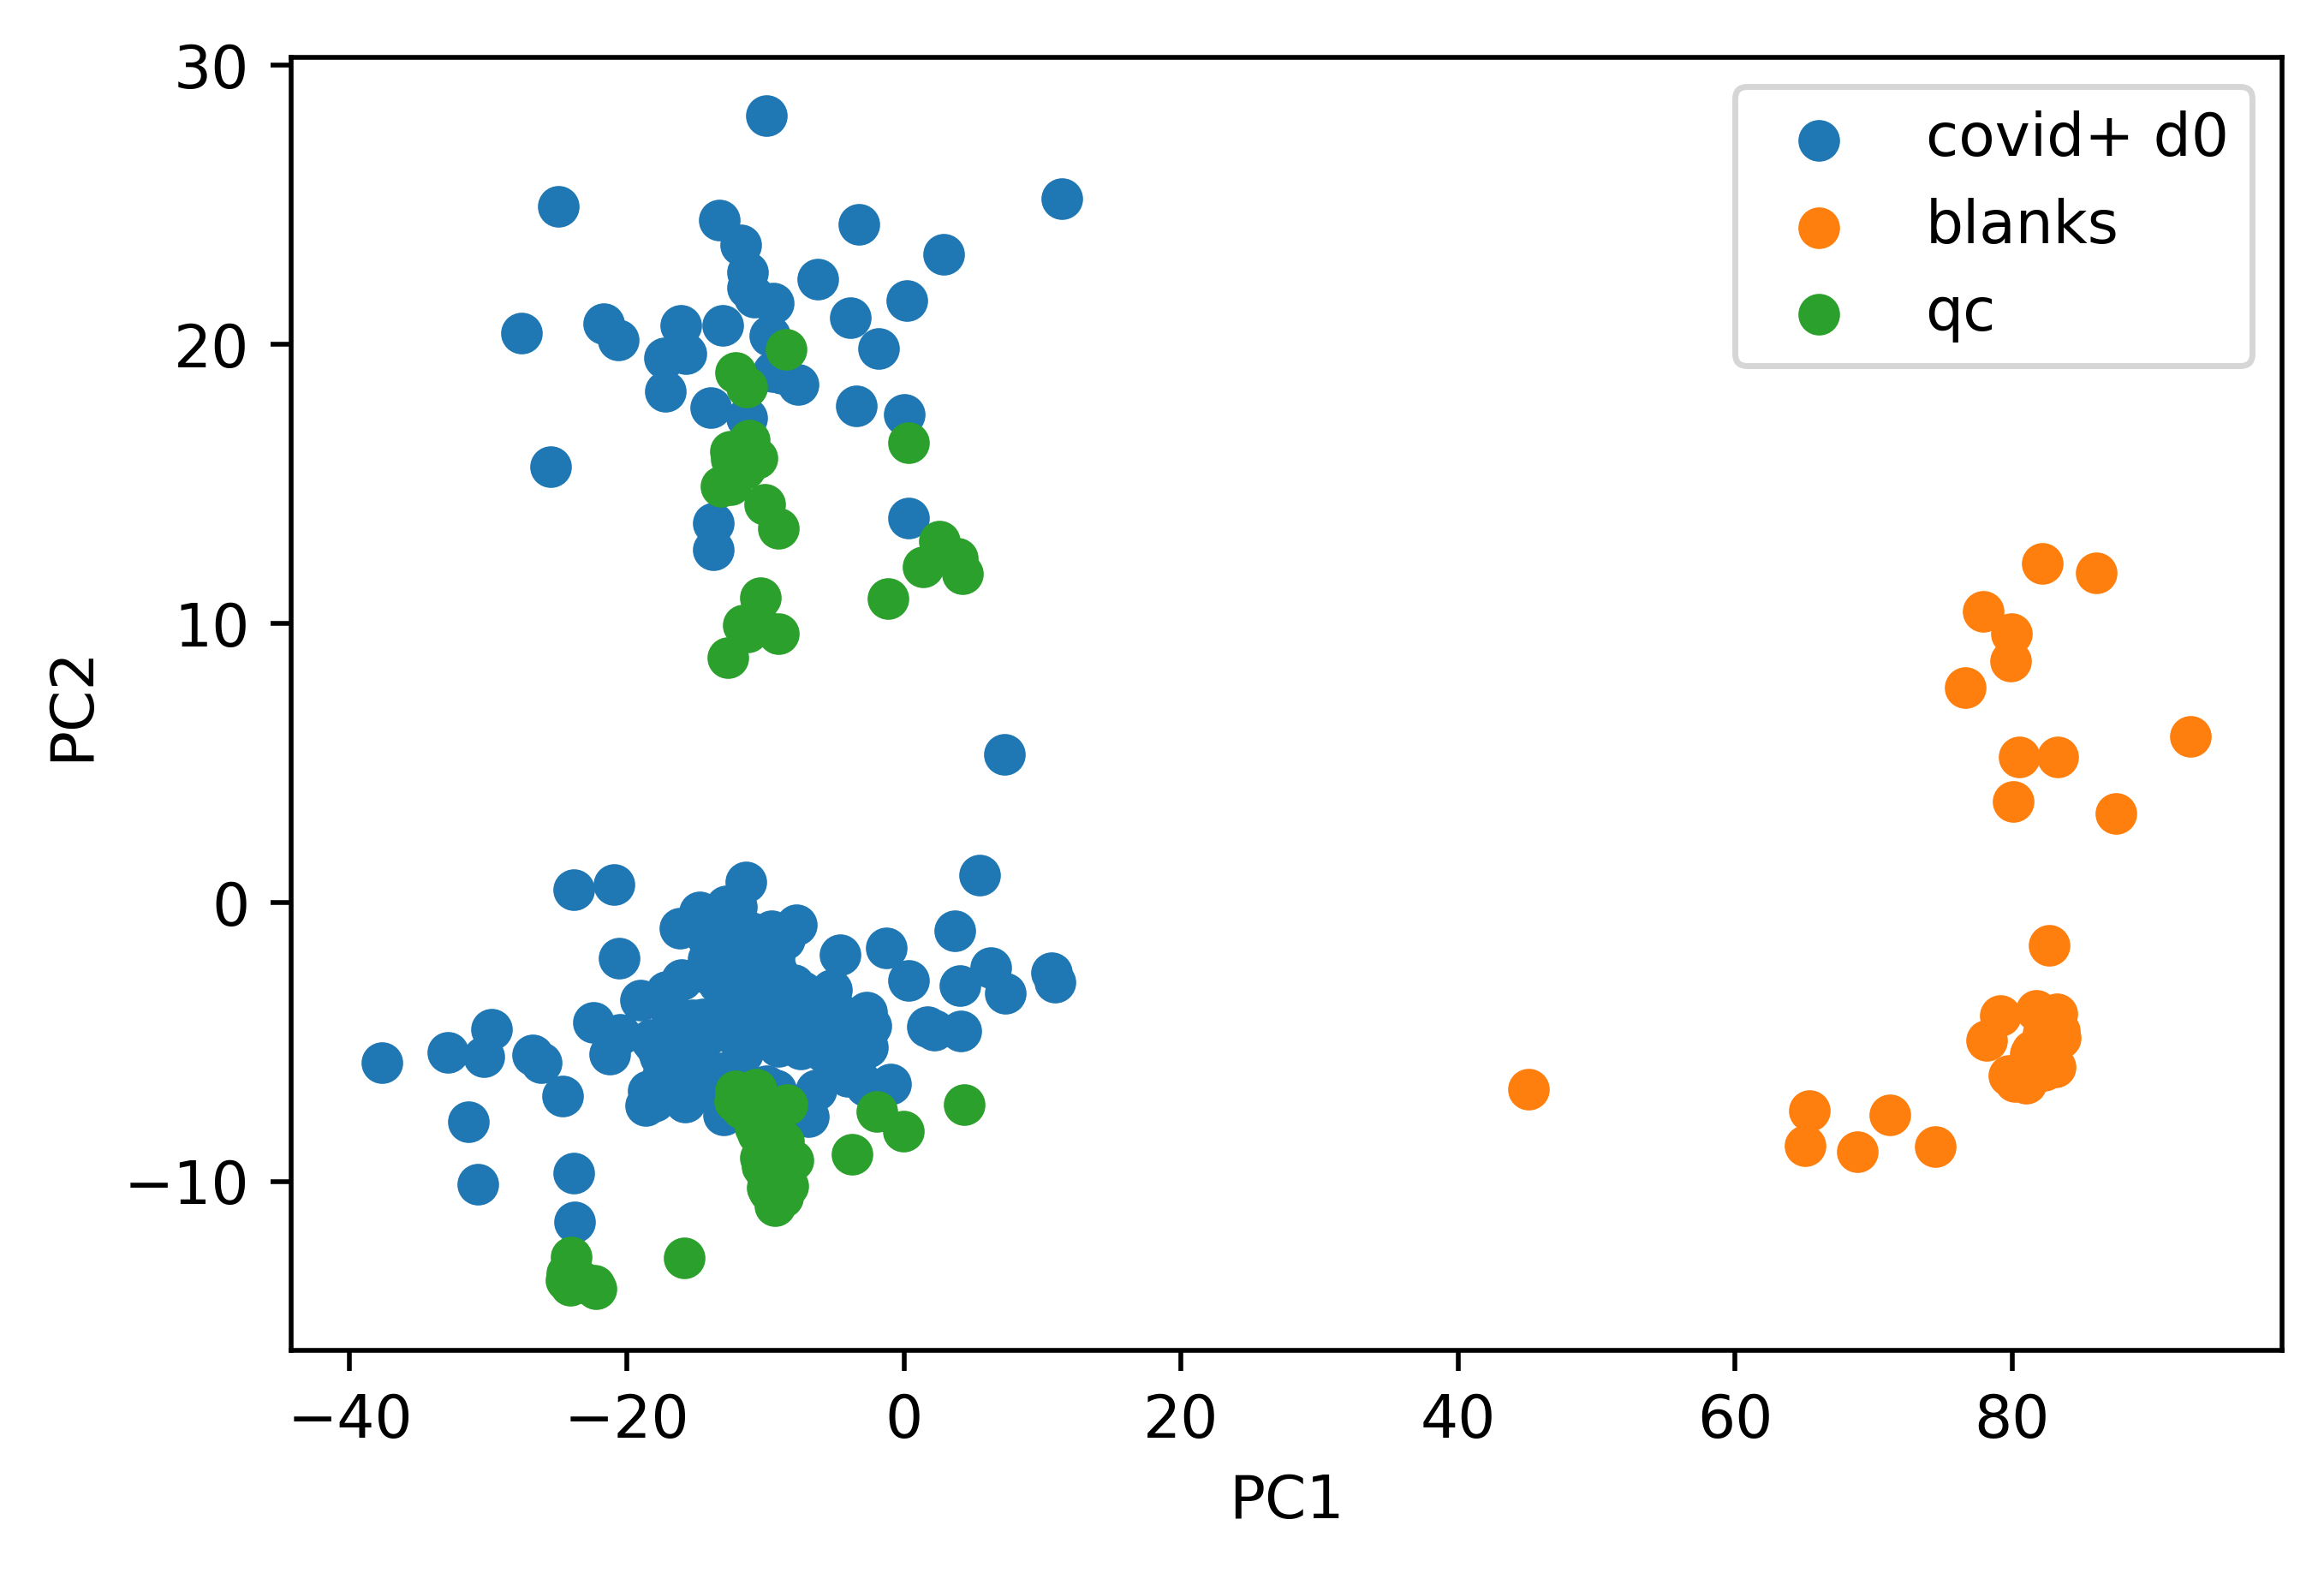

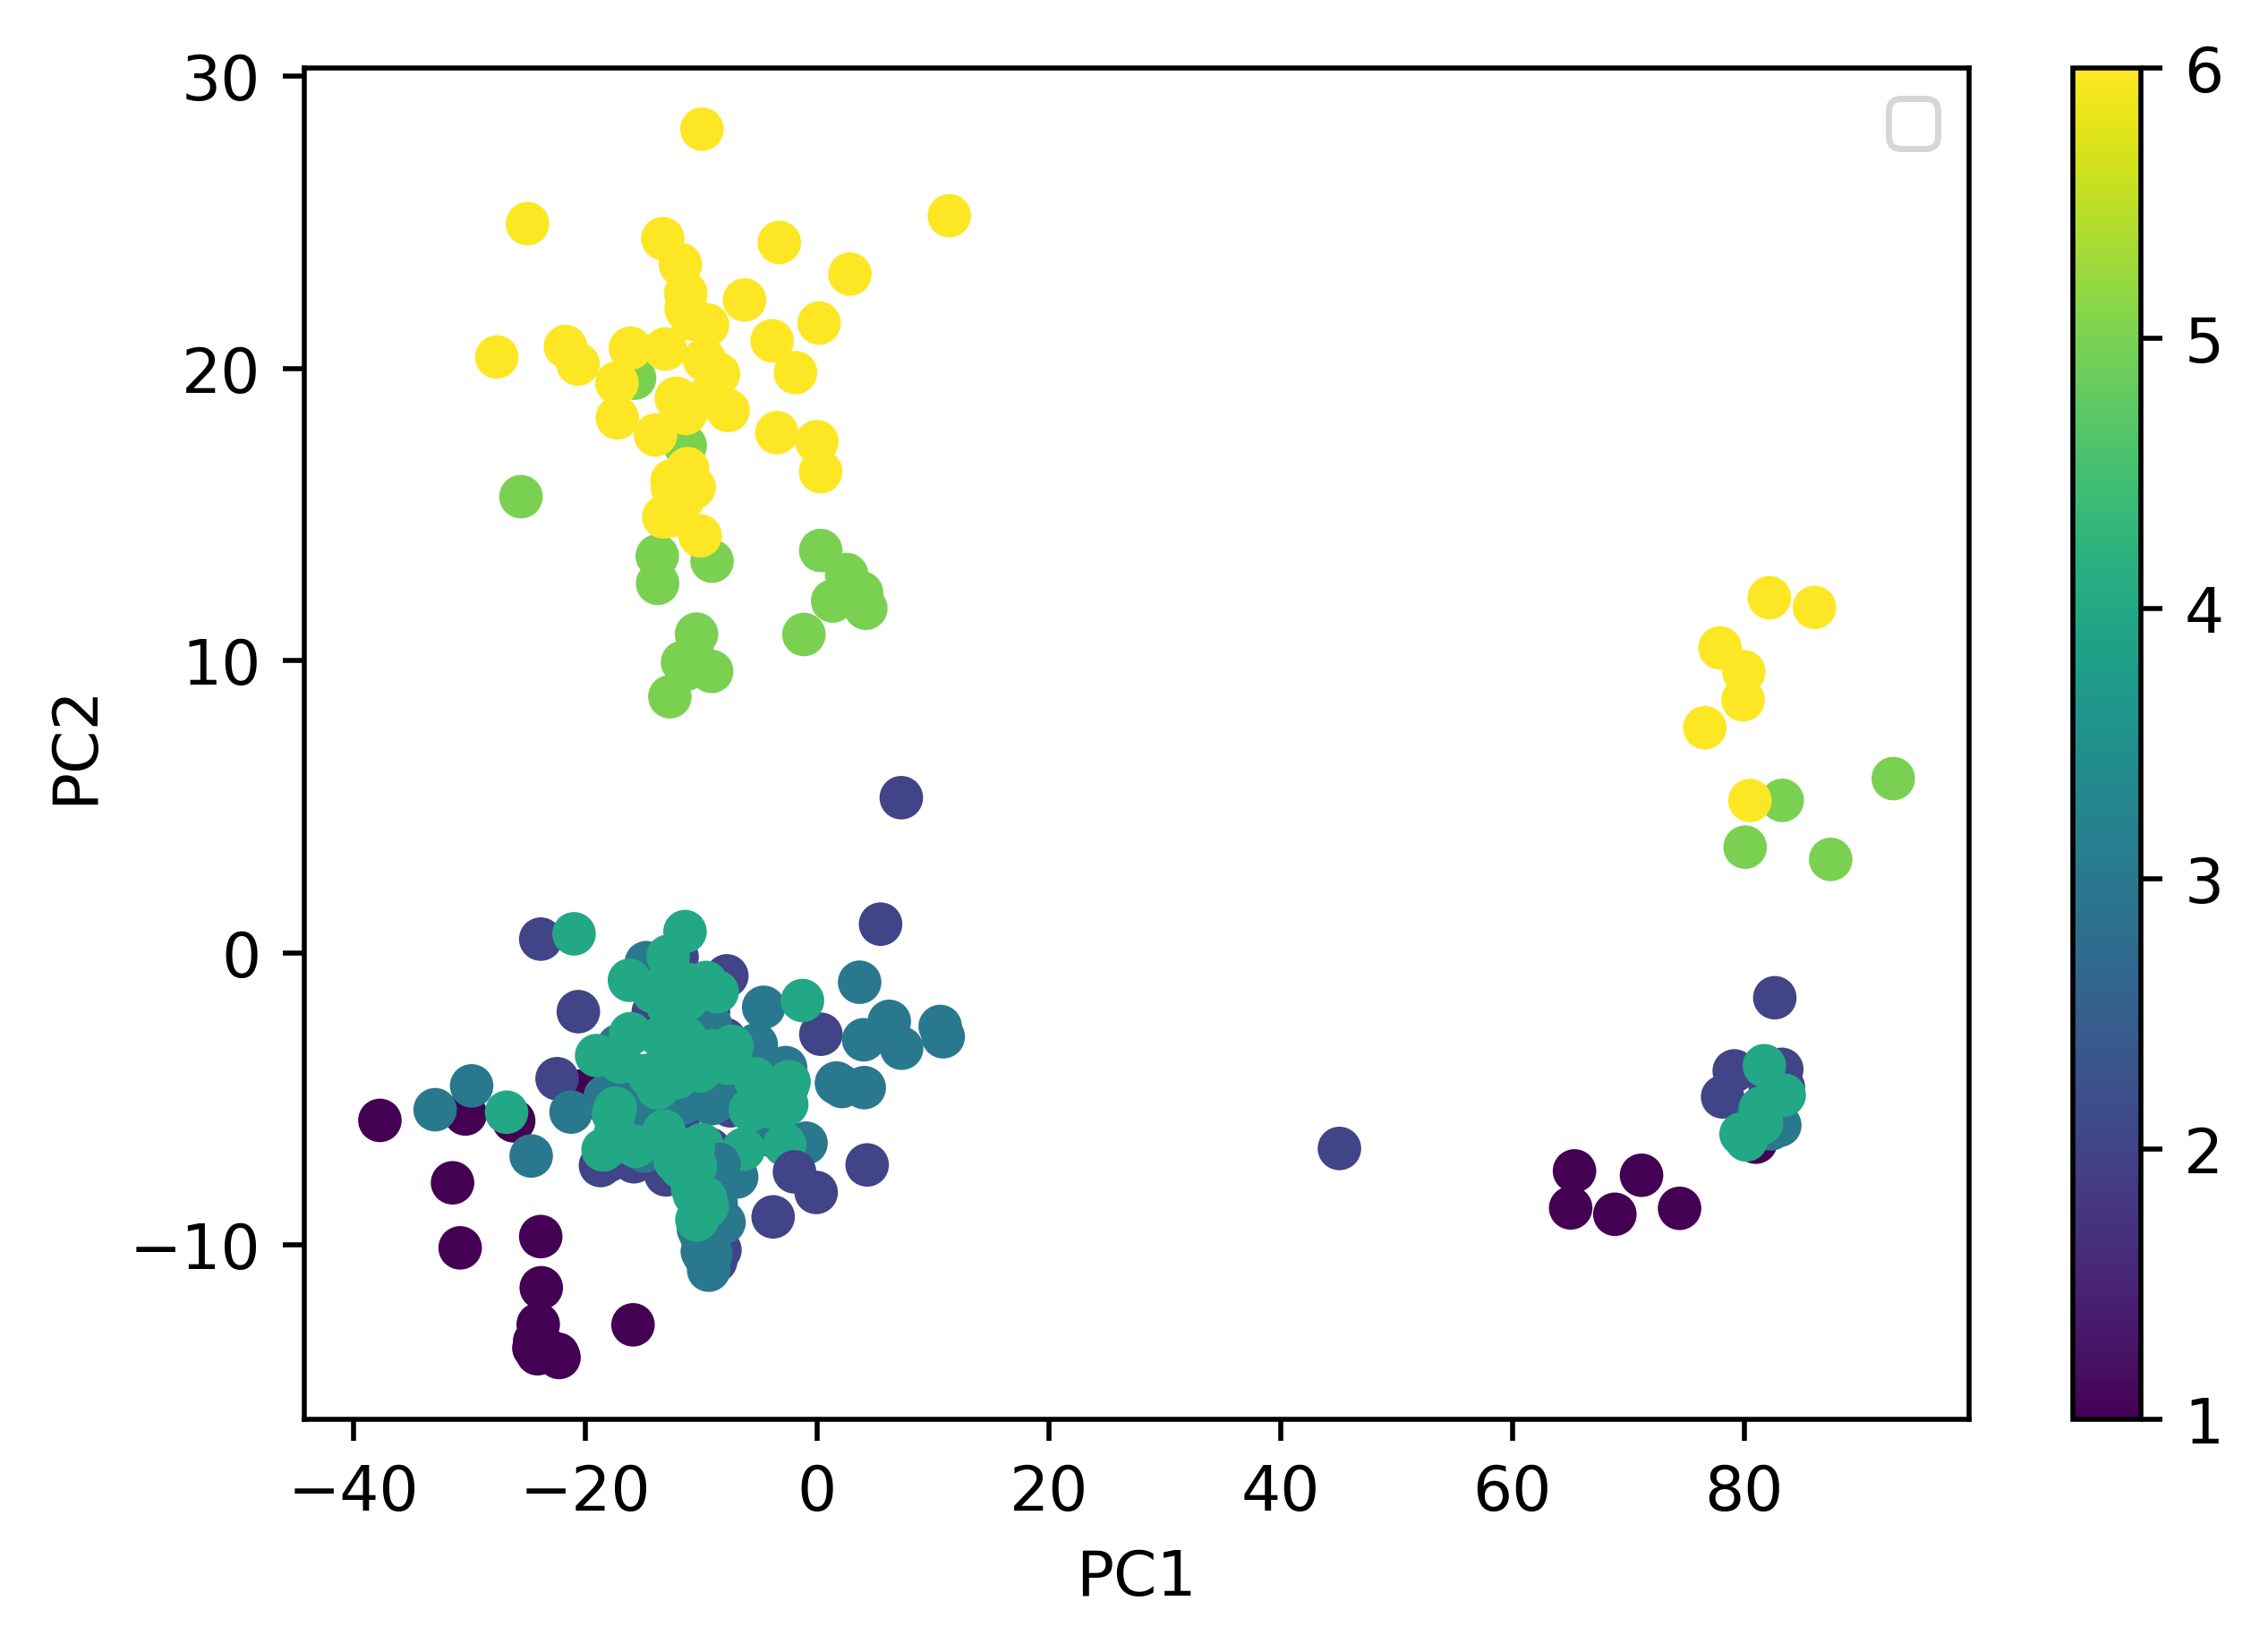

In [3]:
#visualize complete dataset

#first impute dataset
d_whole = np.concatenate((samp_int,blank_int,qc_int))
d_whole_imput = imputeRowMin(d_whole)

#log2 normalize
d_whole_imput = np.log2(d_whole_imput) 

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_imput)
loads = pca.transform(d_whole_imput)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")


No handles with labels found to put in legend.


1.6298794181363305
0.012767105860882958 0.0035234492412216925 1.6298794181363305


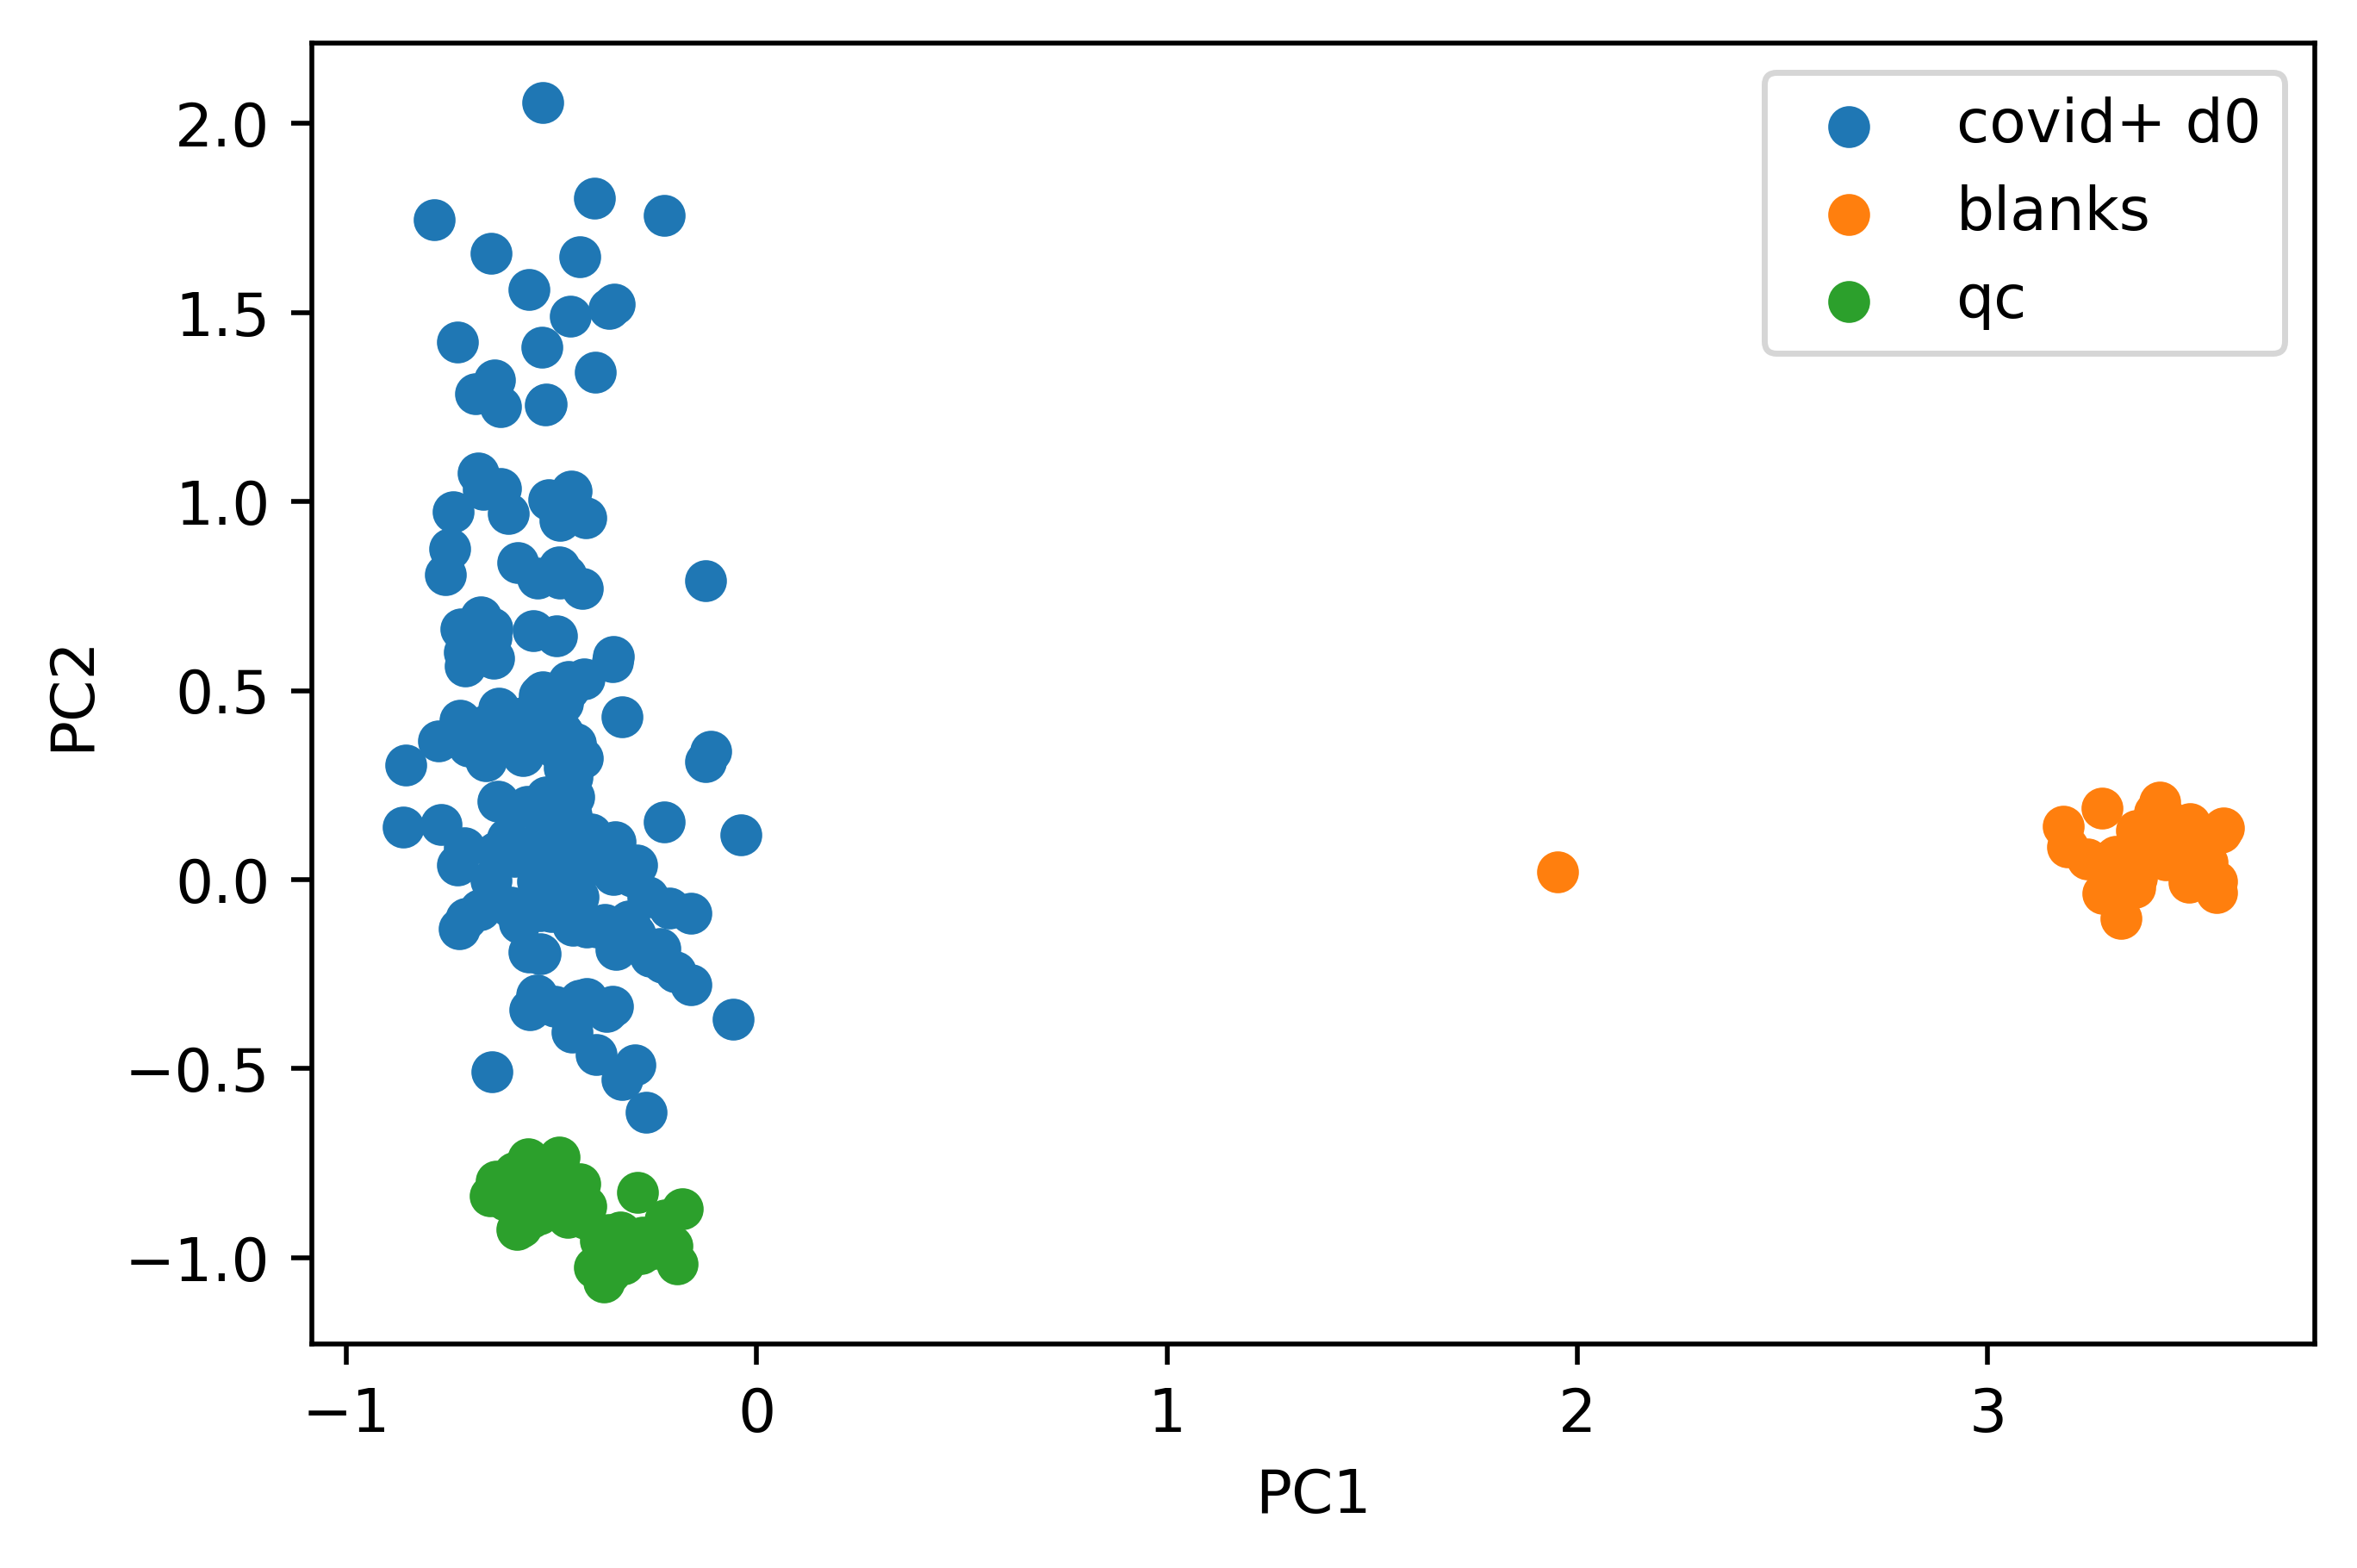

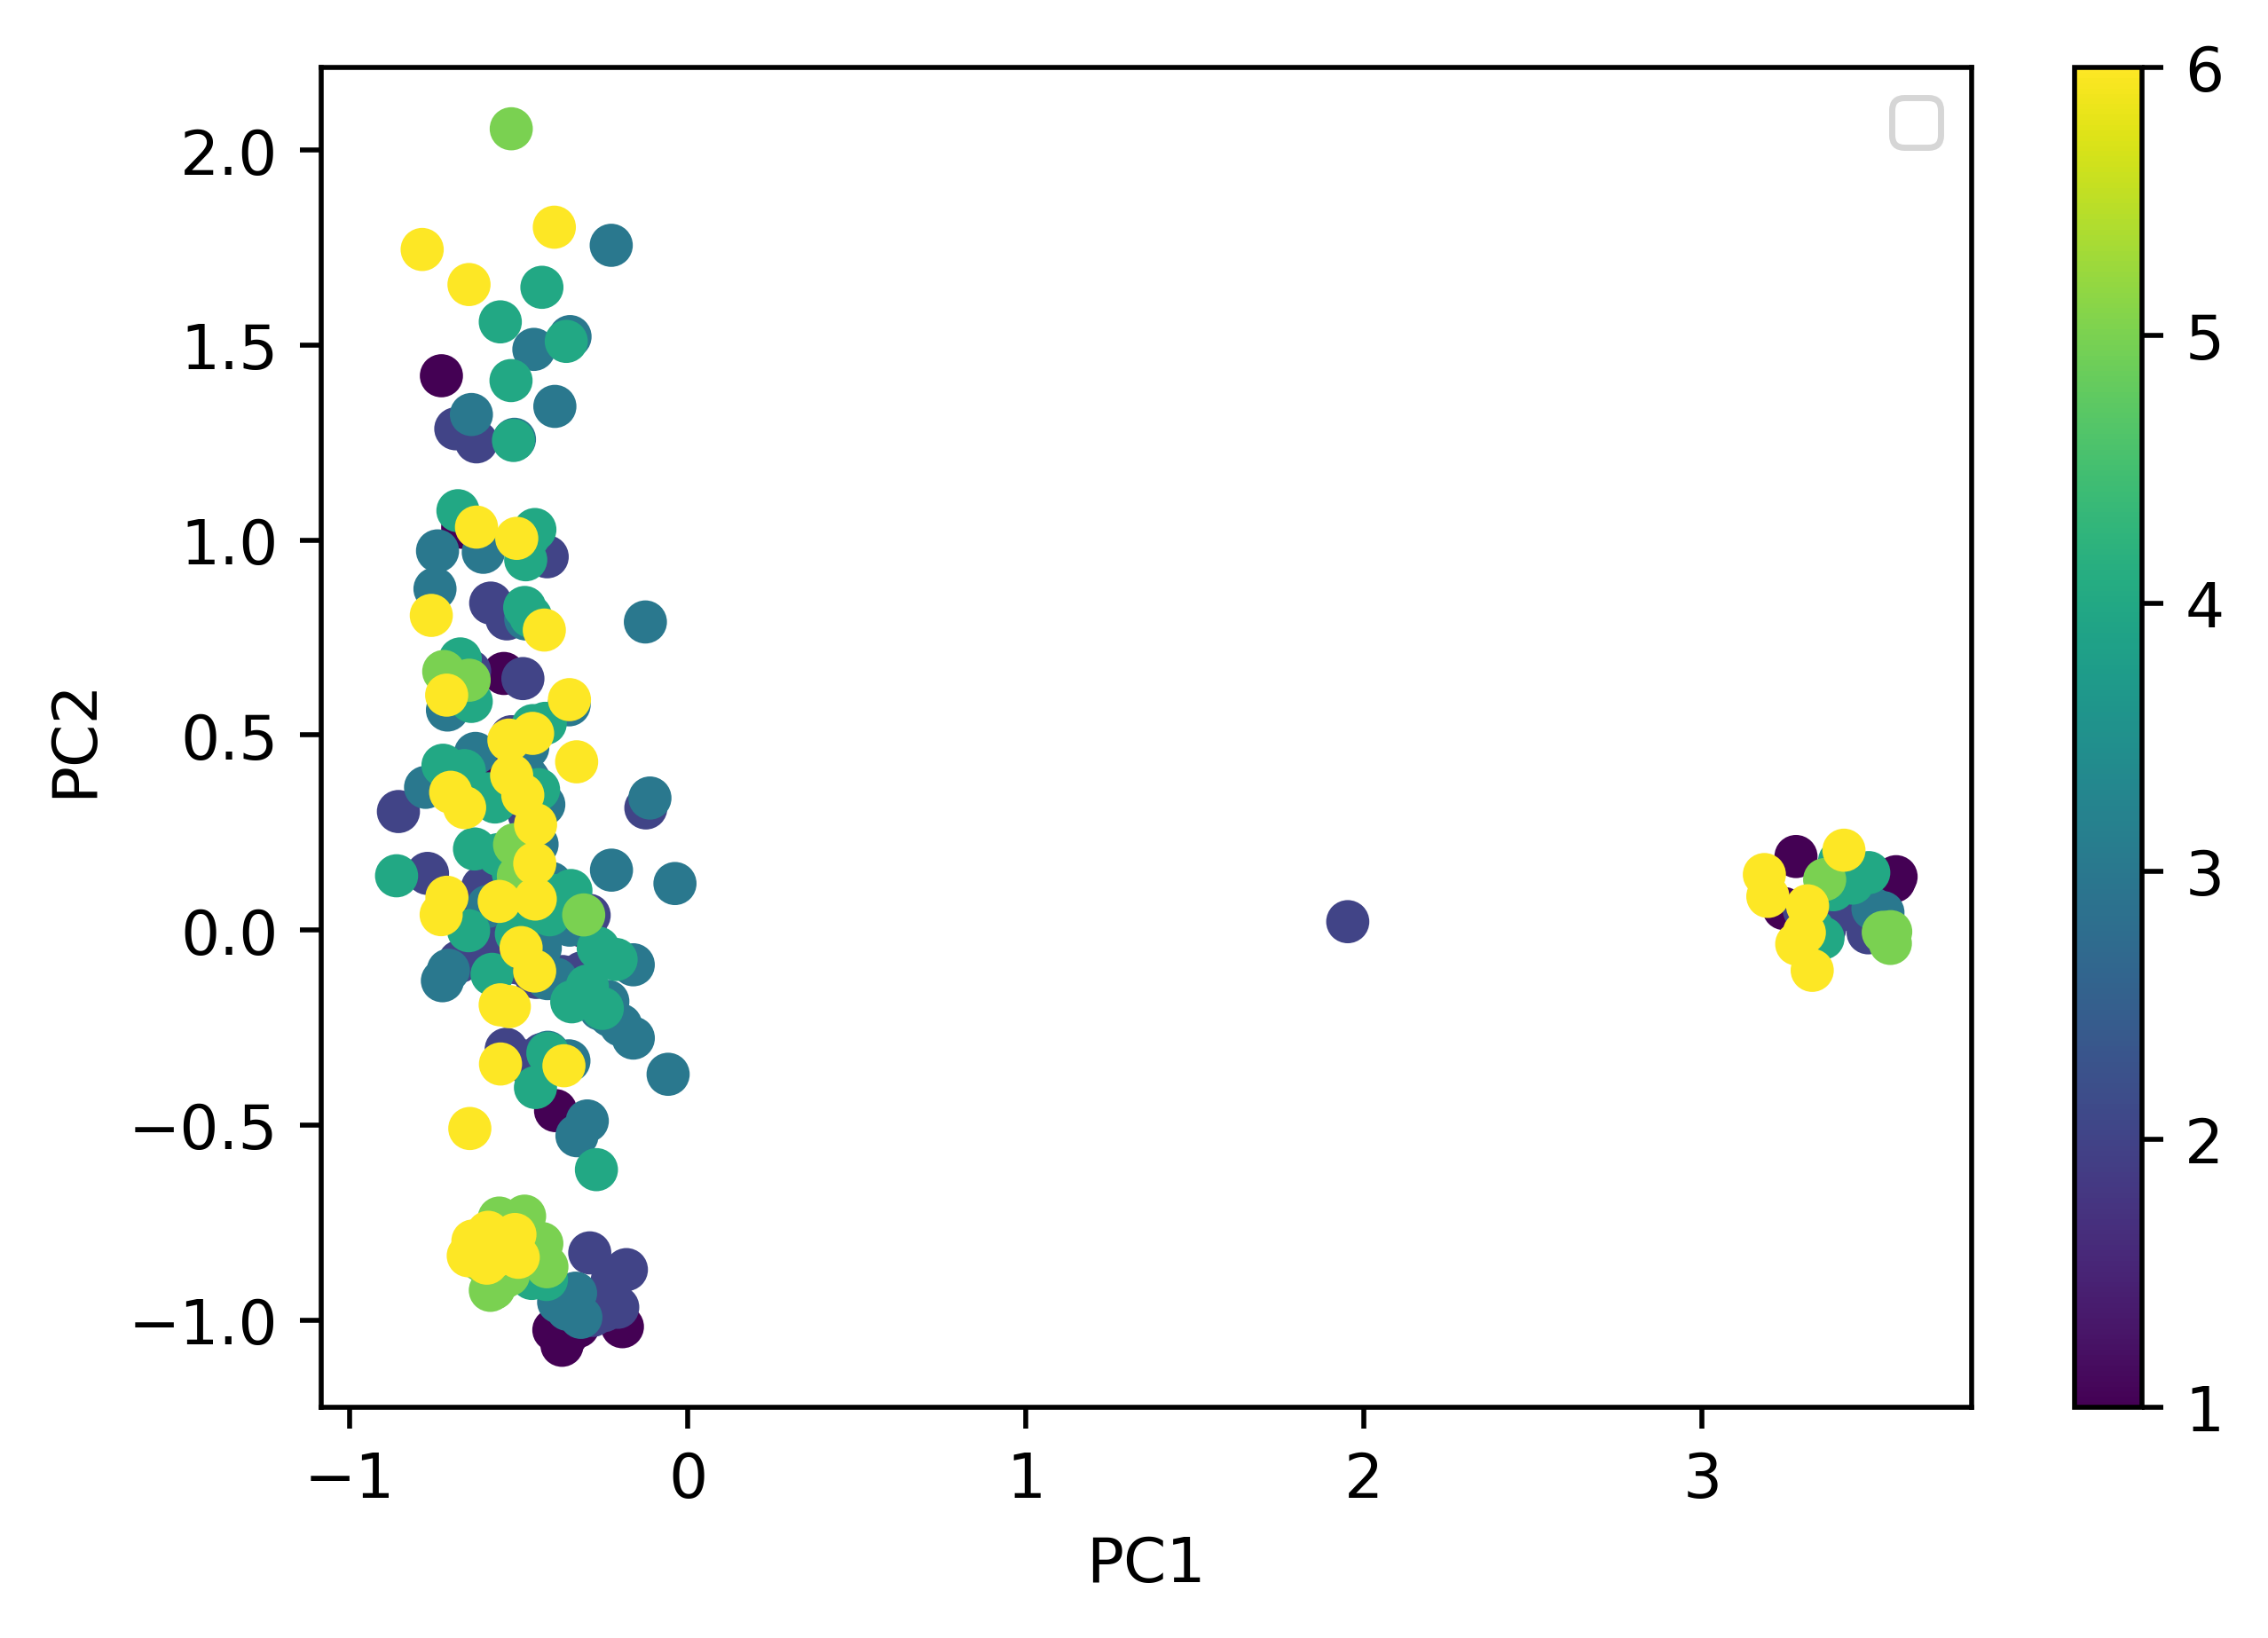

In [17]:
#now quantile normalize

d_whole_norm = quantile_transform(d_whole_imput,1)

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#separate samples
samp_whole_int = d_whole_norm[:len(samp_int)]
qc_whole_int = d_whole_norm[len(samp_int)+len(blank_int):]

#compute variances
sample_variance = np.var(samp_whole_int,axis=0)
qc_variance = np.var(qc_whole_int,axis=0)

norm_var = np.linalg.norm(sample_variance)/np.linalg.norm(qc_variance)

print(norm_var)

print(np.mean(sample_variance),np.mean(qc_variance),np.mean(norm_var))


No handles with labels found to put in legend.


0.8670260924830757
0.18604867256824492 0.0831301979102204 0.8670260924830757


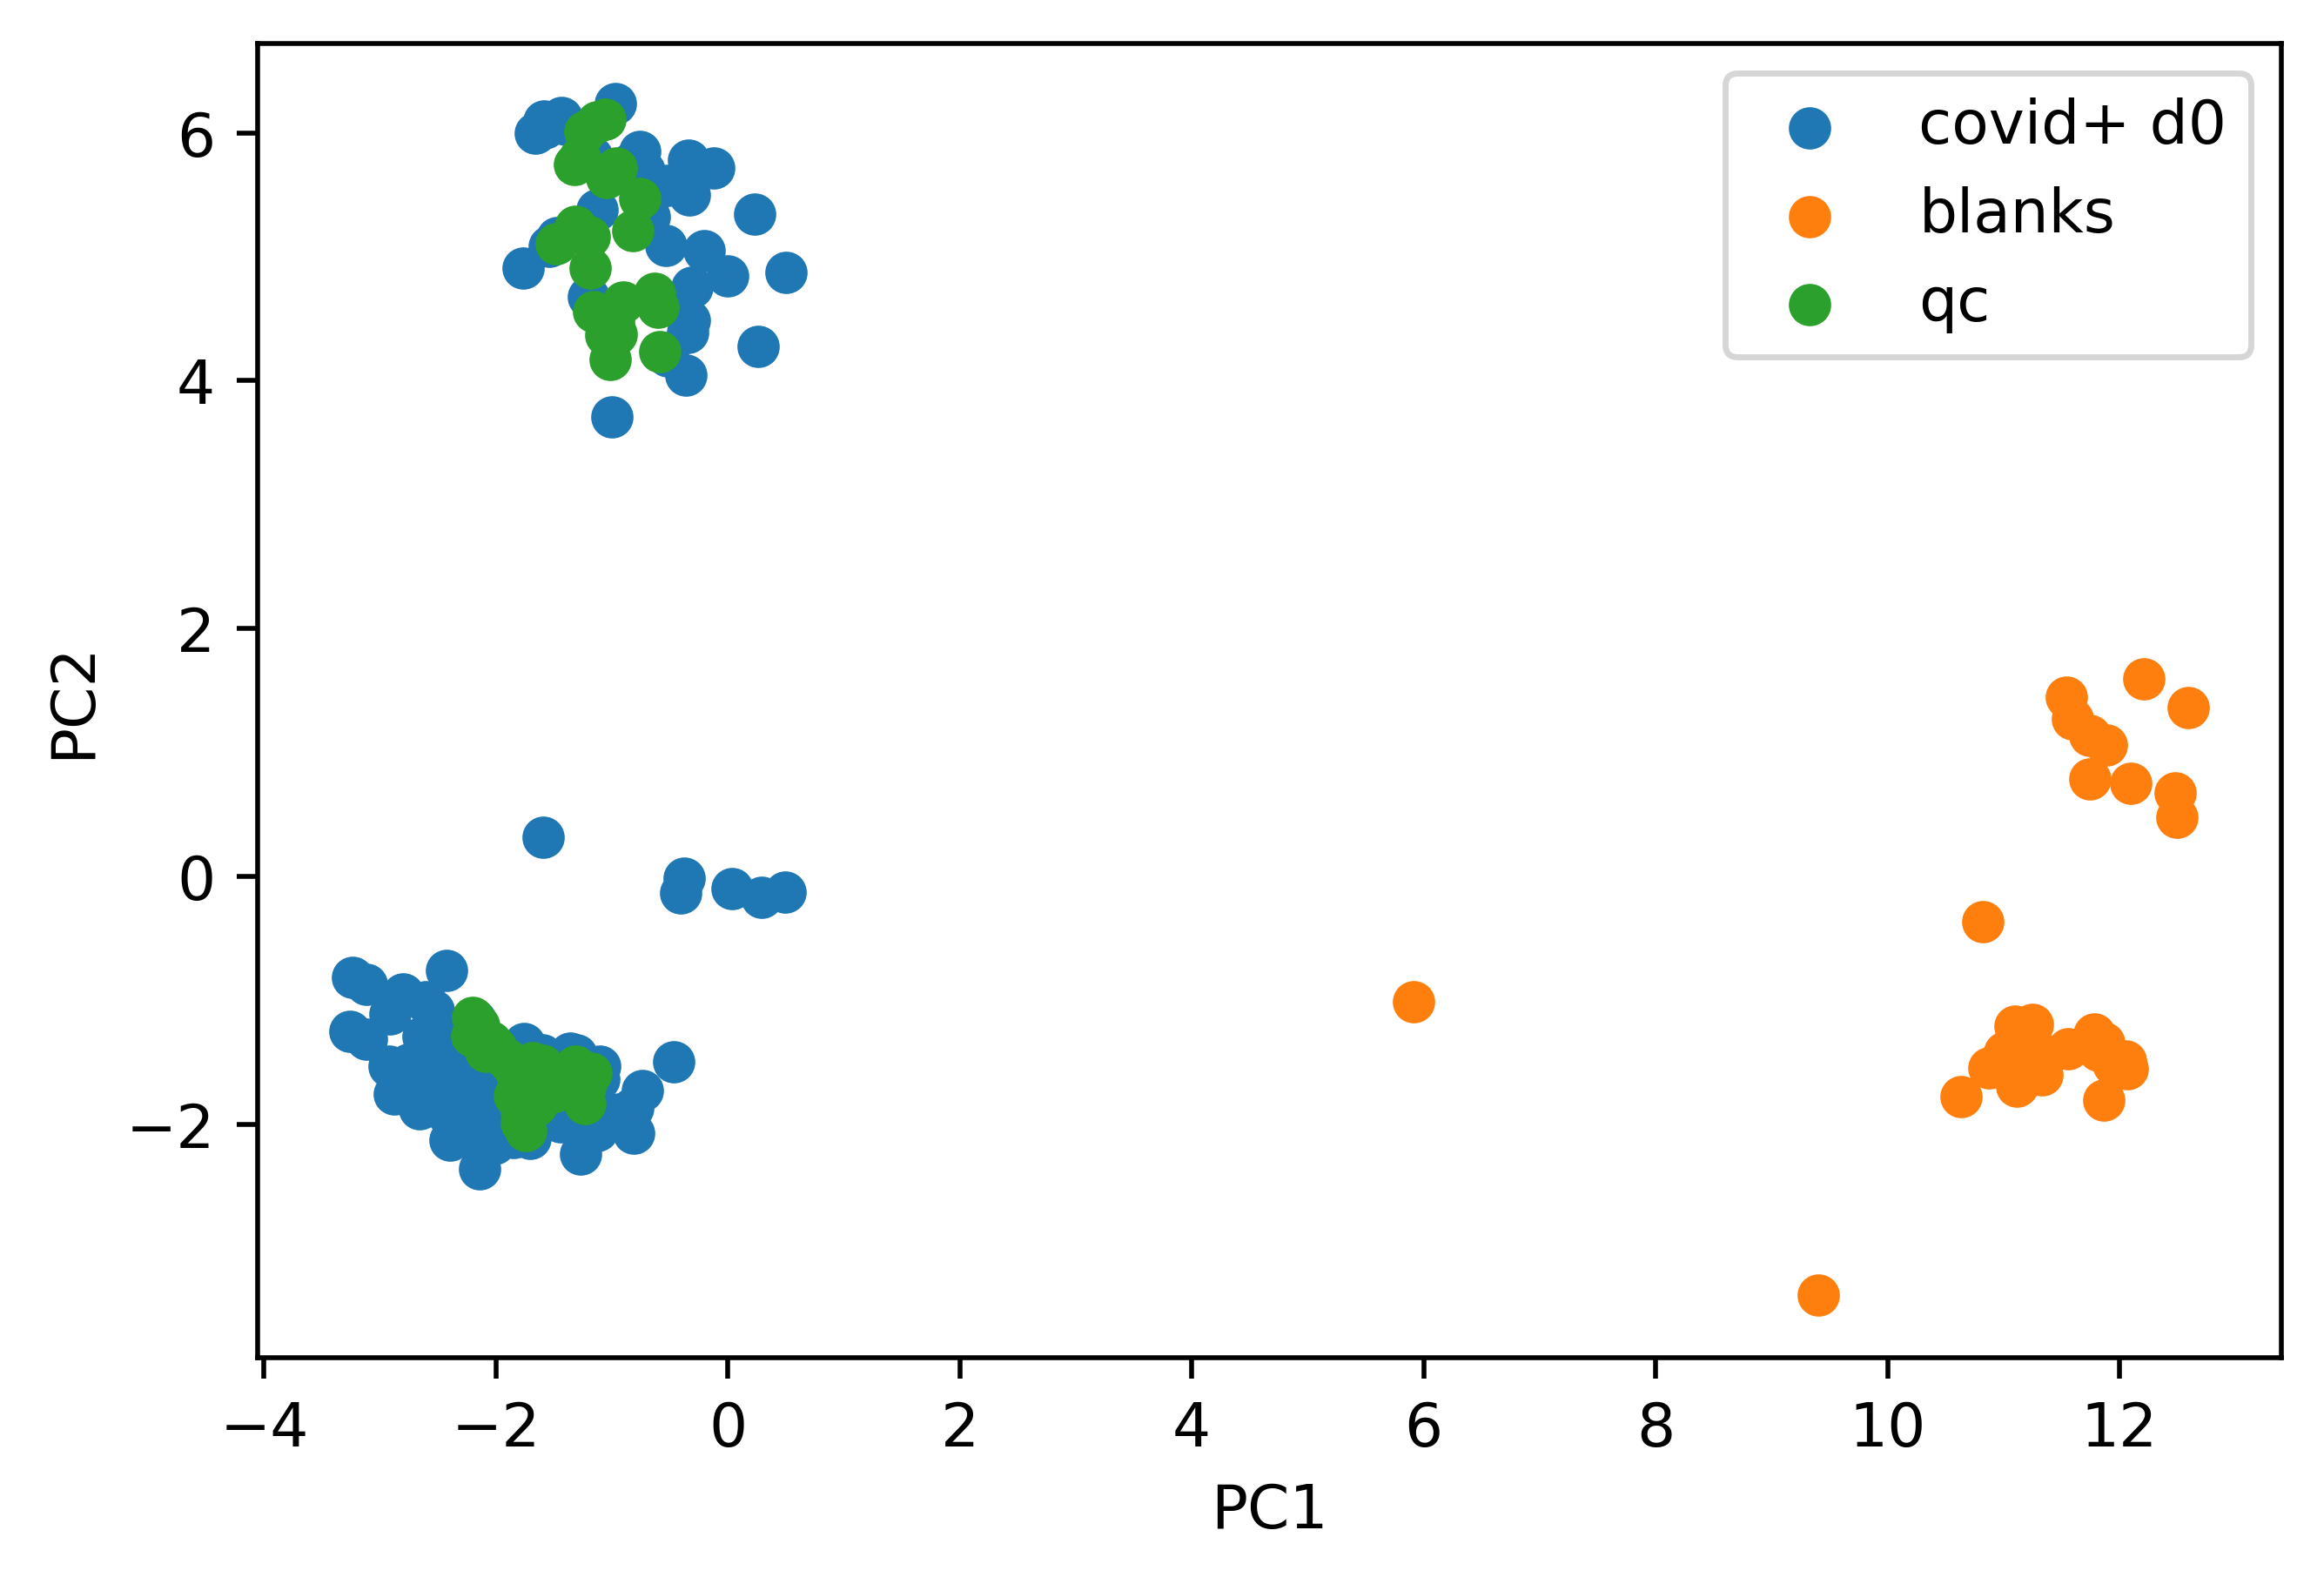

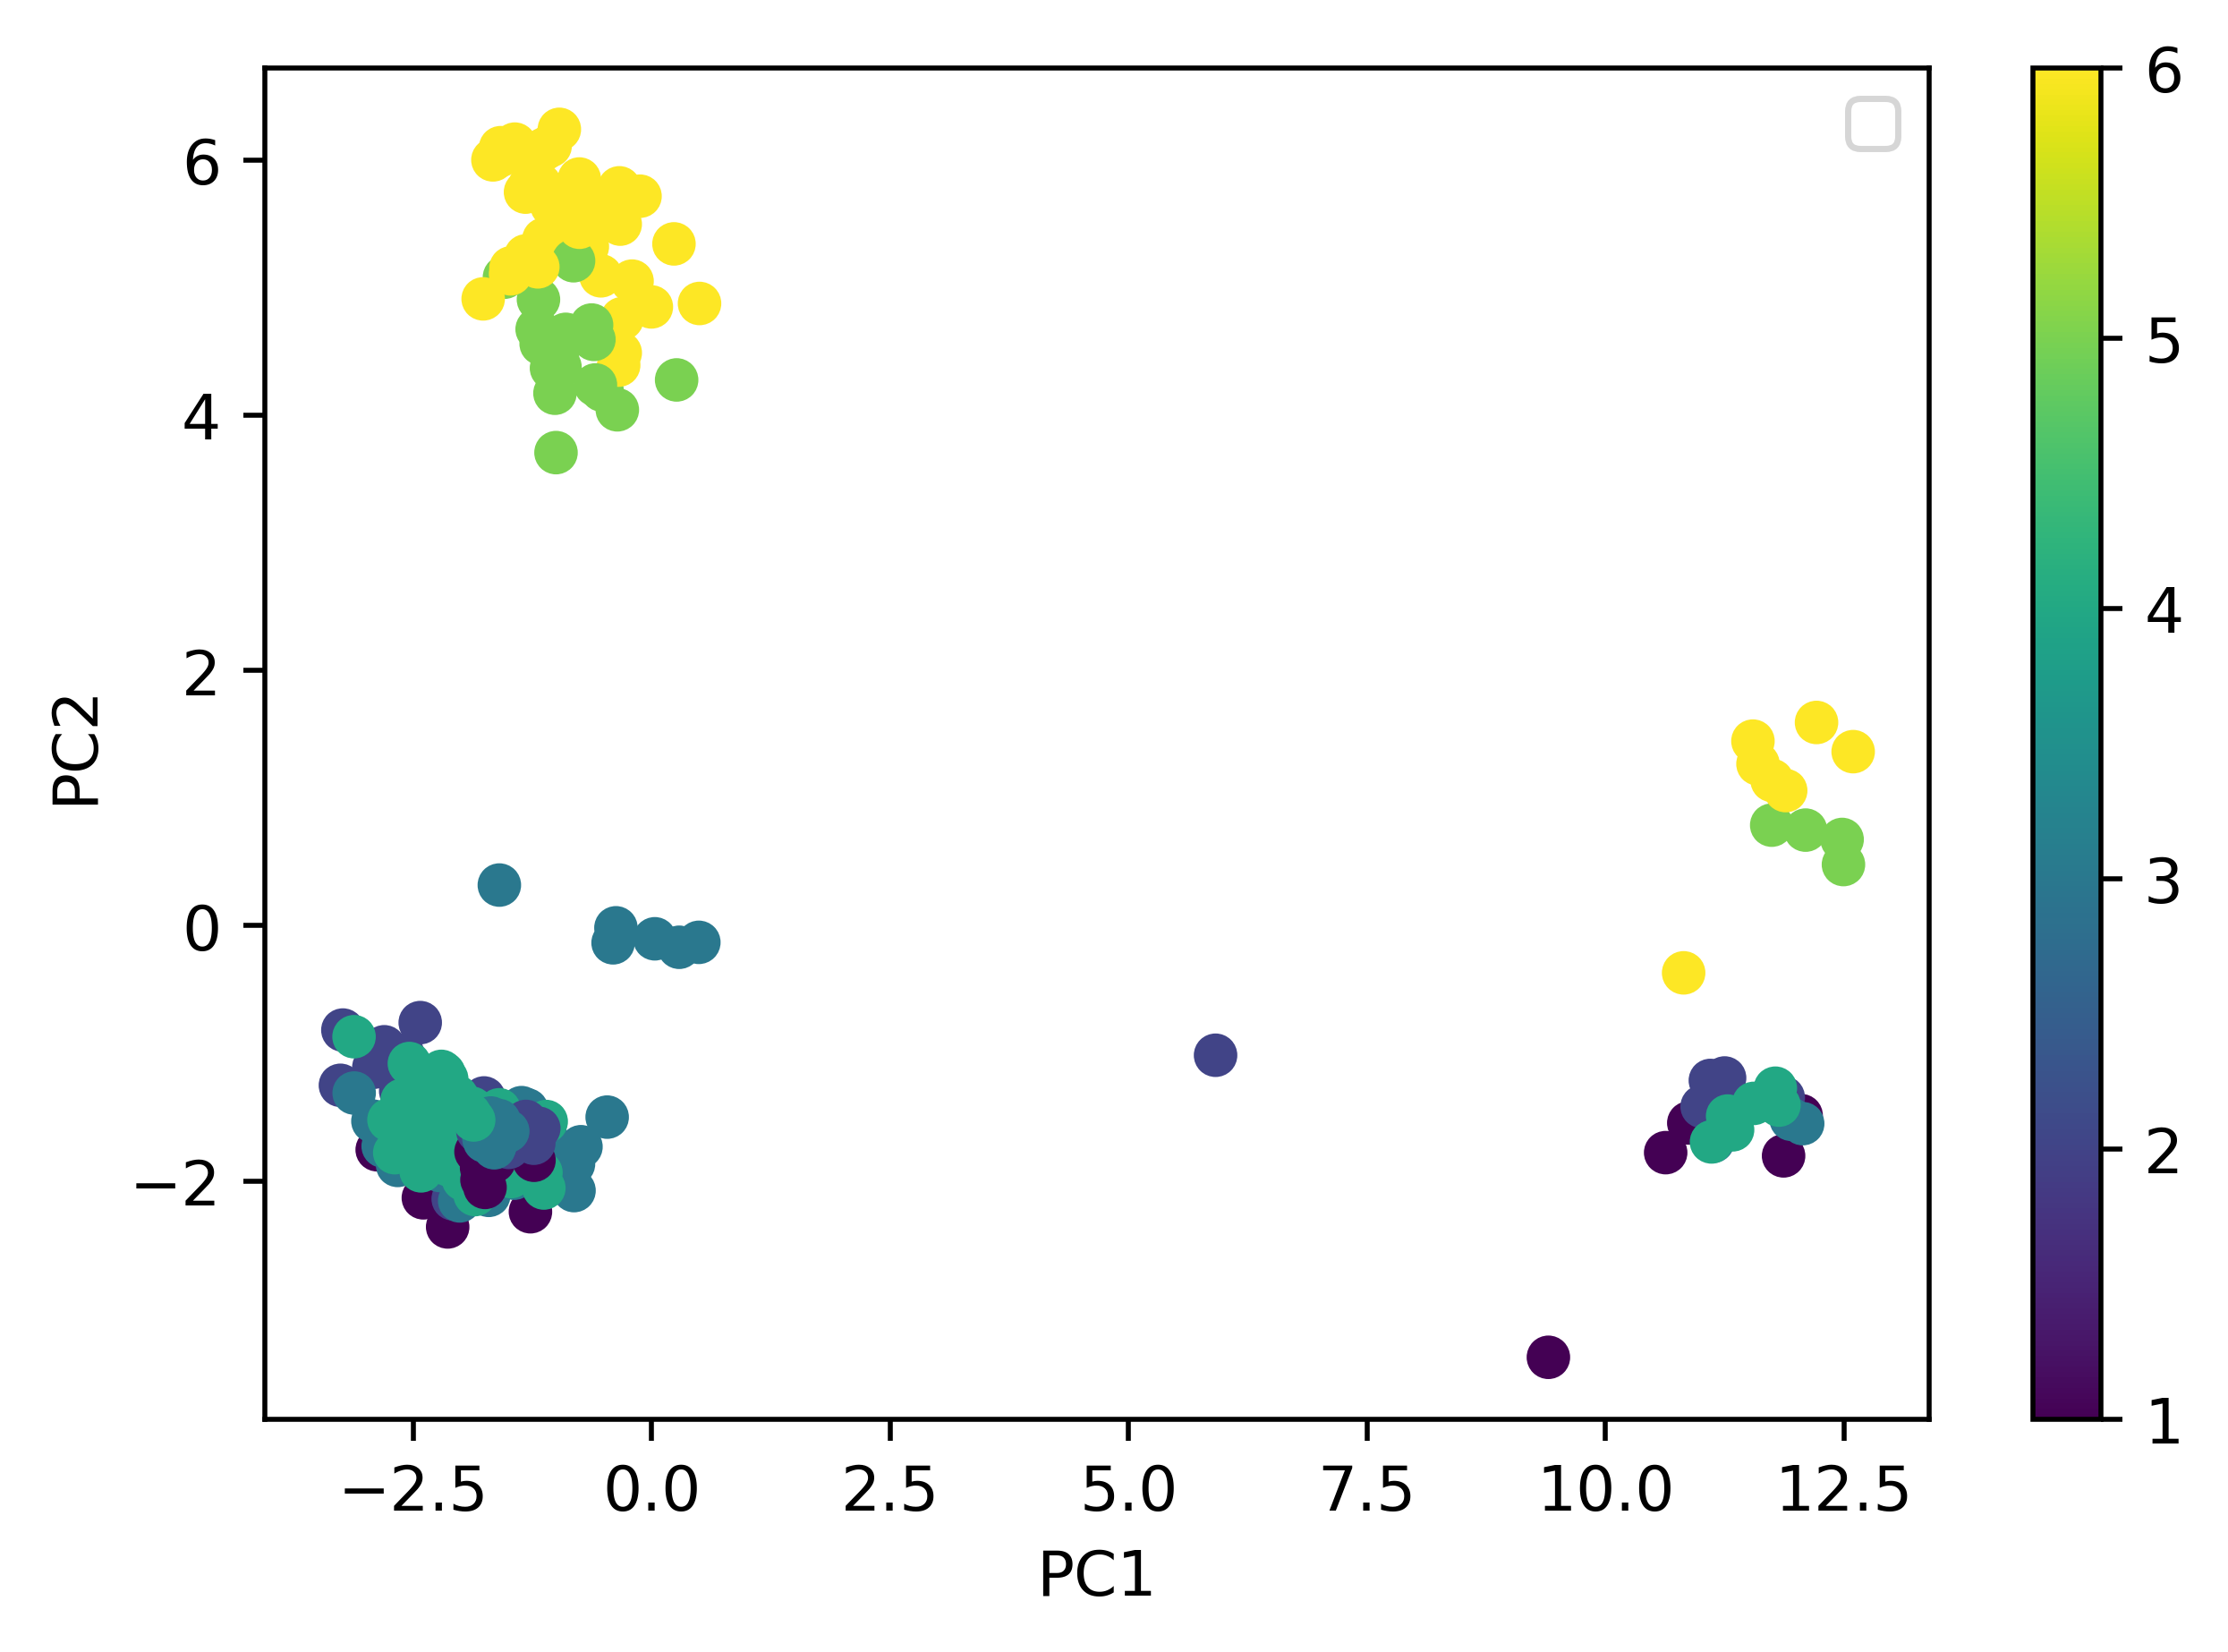

In [15]:
#now quantile normalize

d_whole_norm = quantile_transform(d_whole_imput,1,output_distribution="normal")

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#separate samples
samp_whole_int = d_whole_norm[:len(samp_int)]
qc_whole_int = d_whole_norm[len(samp_int)+len(blank_int):]

#compute variances
sample_variance = np.var(samp_whole_int,axis=0)
qc_variance = np.var(qc_whole_int,axis=0)

norm_var = np.linalg.norm(sample_variance)/np.linalg.norm(qc_variance)

print(norm_var)

print(np.mean(sample_variance),np.mean(qc_variance),np.mean(norm_var))

found 6 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


No handles with labels found to put in legend.


3.6202052448605446
3.0975391893938413 0.5969499047406215 3.6202052448605446


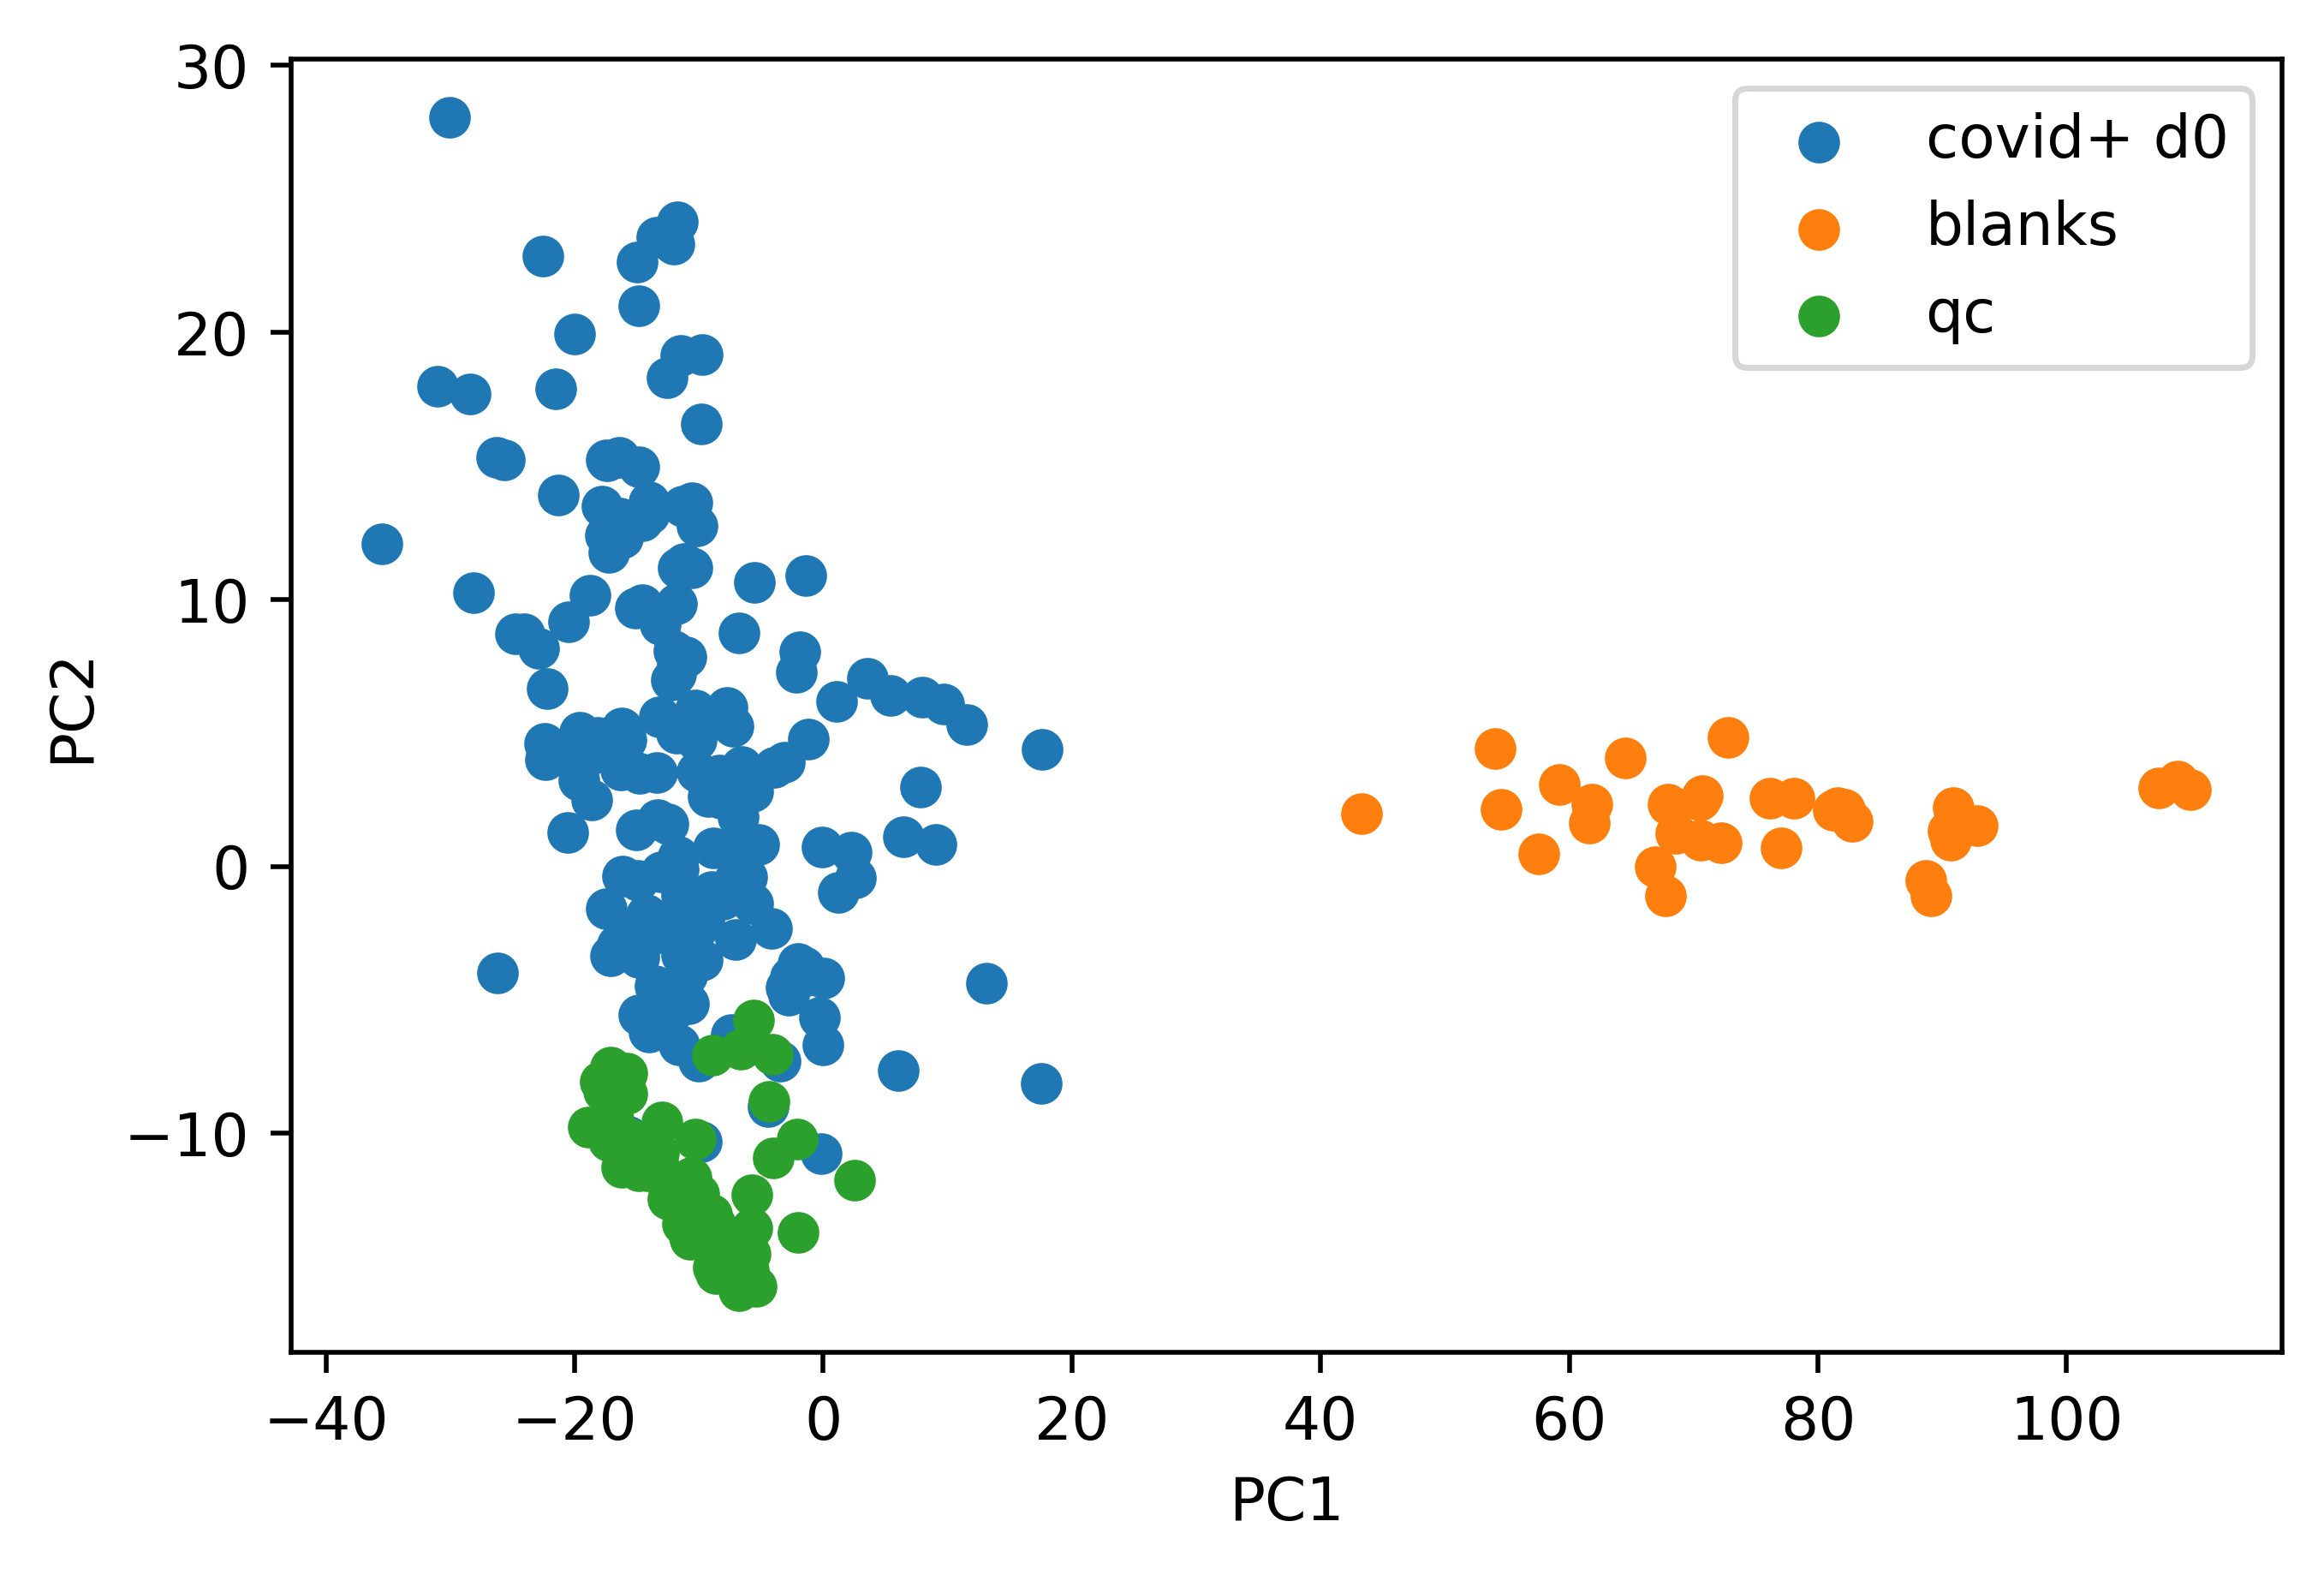

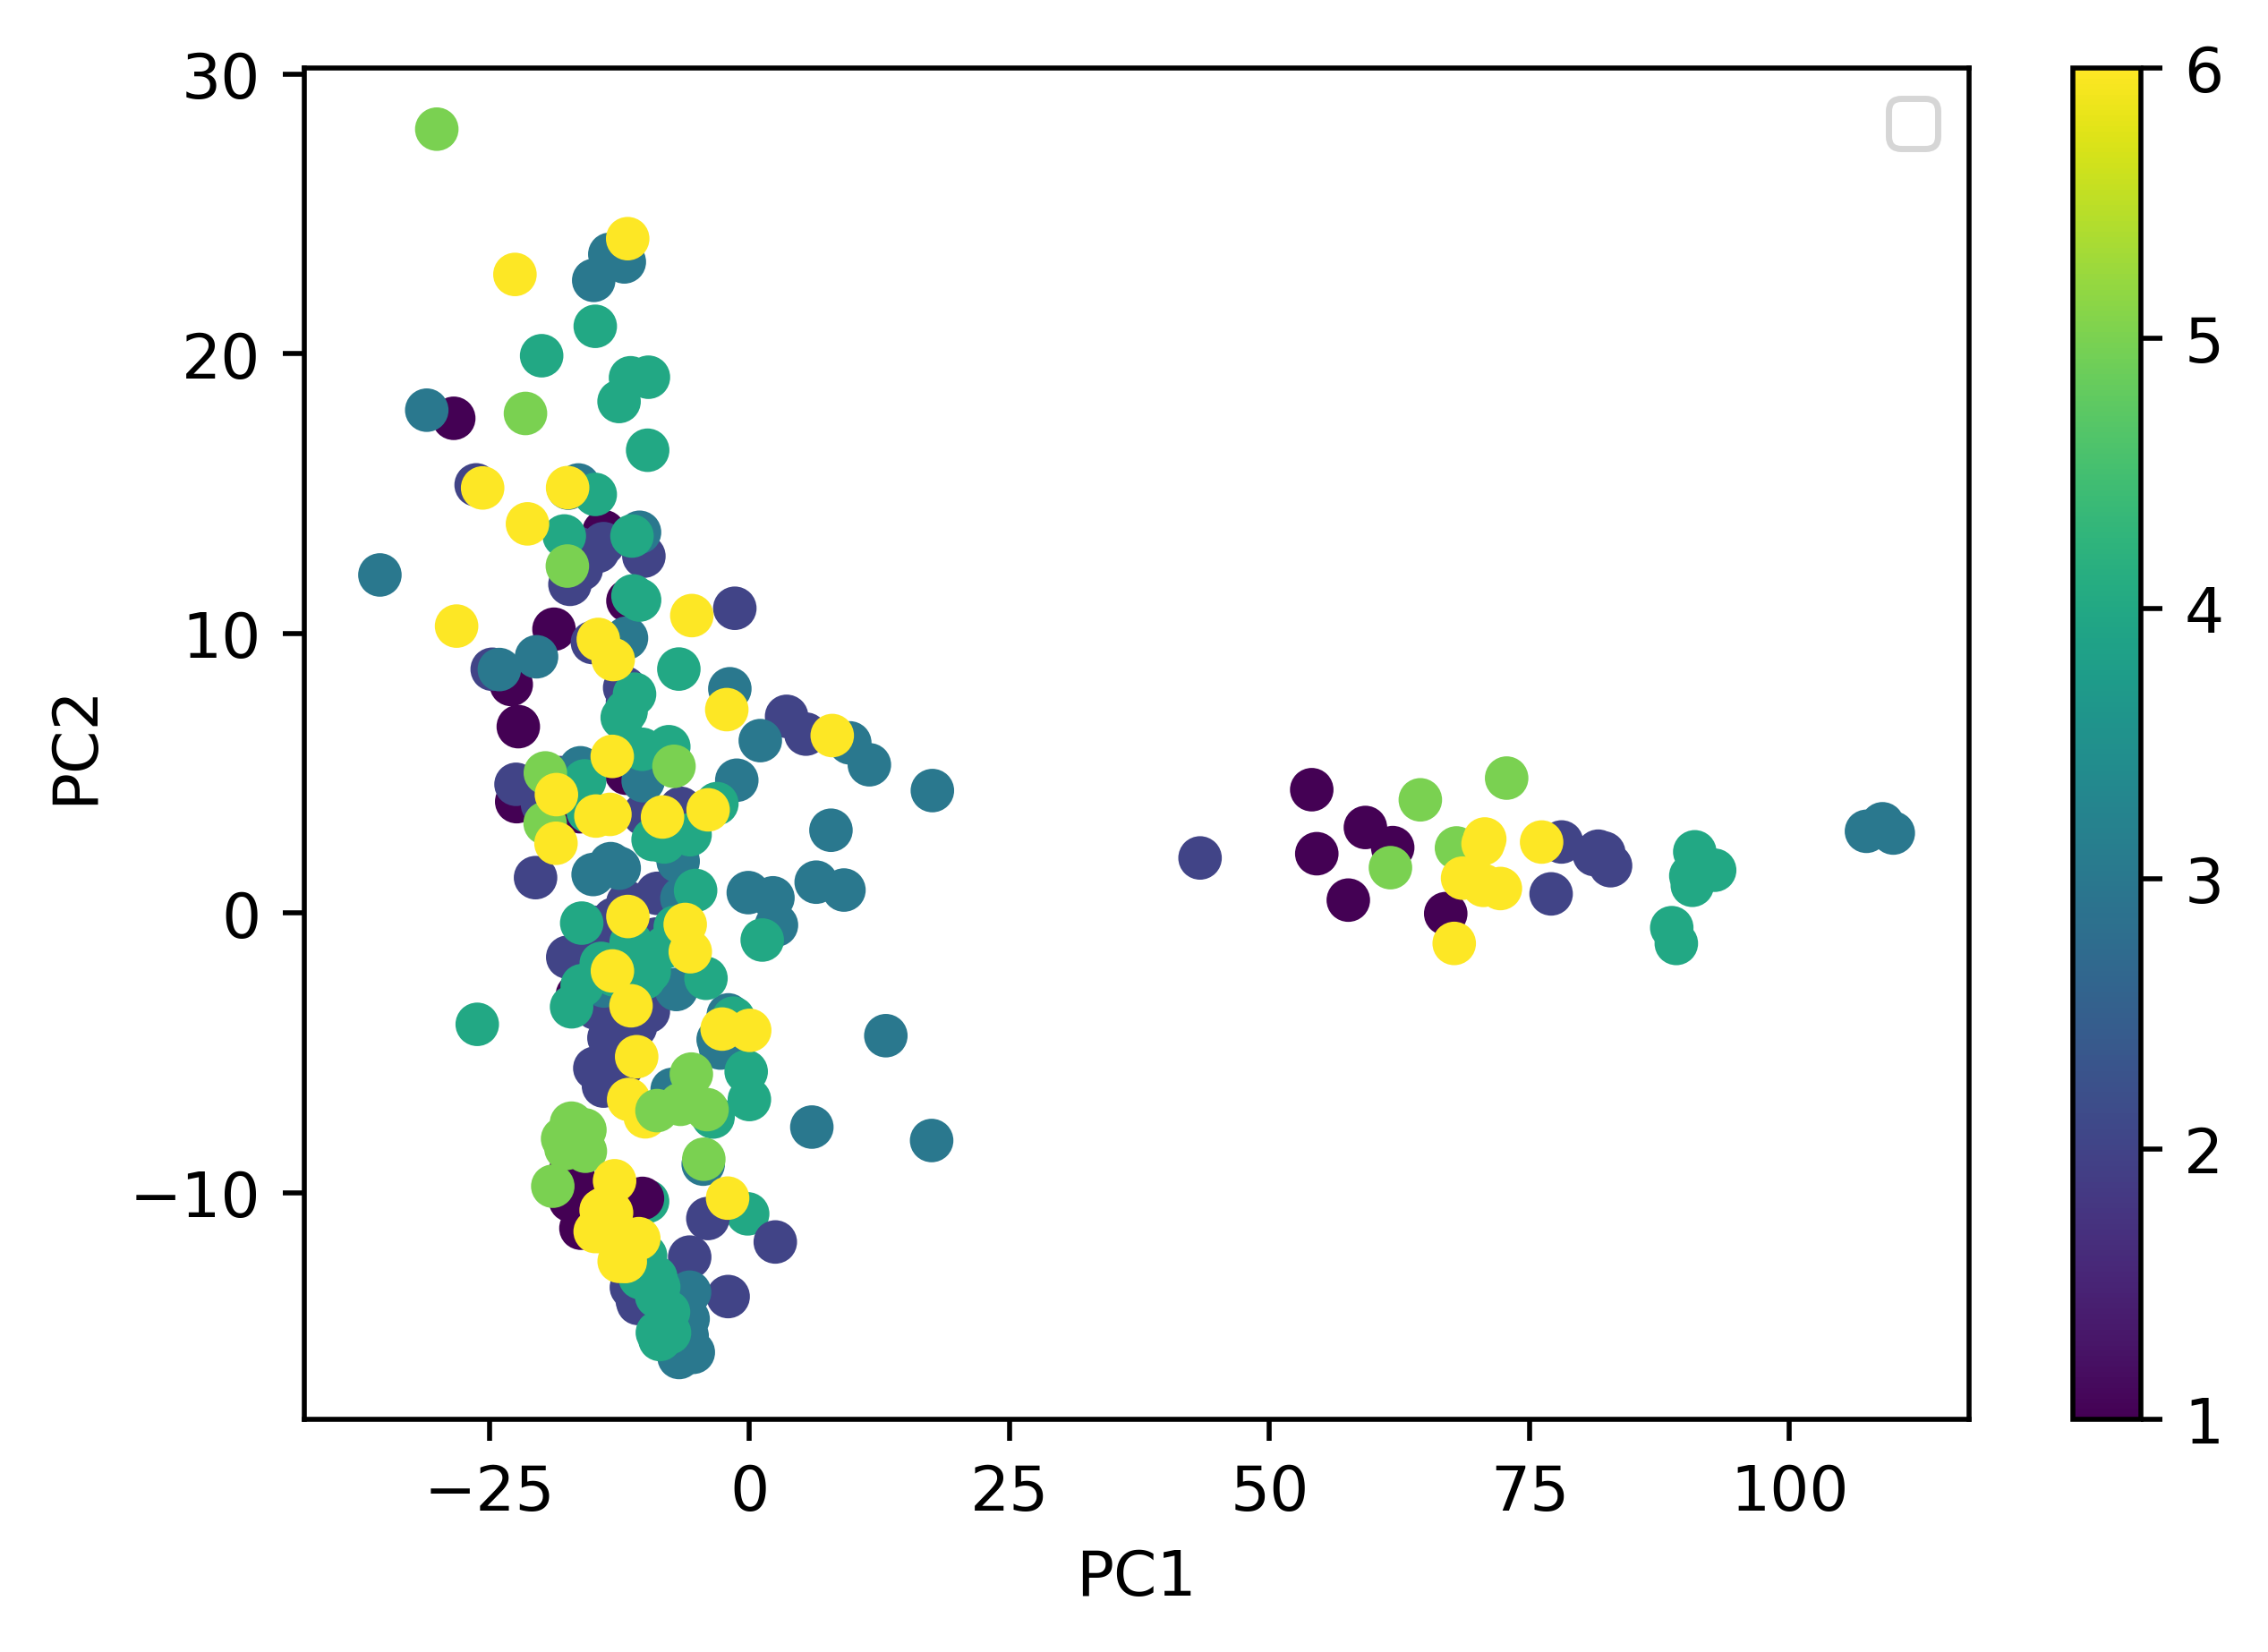

In [5]:
#now combat normalize

d_whole_norm =  combat.combat(pd.DataFrame(d_whole_imput.transpose()),np.concatenate((samp_batch,blank_batch,qc_batch))).transpose().to_numpy()

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#separate samples
samp_whole_int = d_whole_norm[:len(samp_int)]
qc_whole_int = d_whole_norm[len(samp_int)+len(blank_int):]

#compute variances
sample_variance = np.var(samp_whole_int,axis=0)
qc_variance = np.var(qc_whole_int,axis=0)

norm_var = np.linalg.norm(sample_variance)/np.linalg.norm(qc_variance)

print(norm_var)

print(np.mean(sample_variance),np.mean(qc_variance),np.mean(norm_var))

No handles with labels found to put in legend.


1.247662302725896
3.583503013346553 1.4164414177815903 1.247662302725896


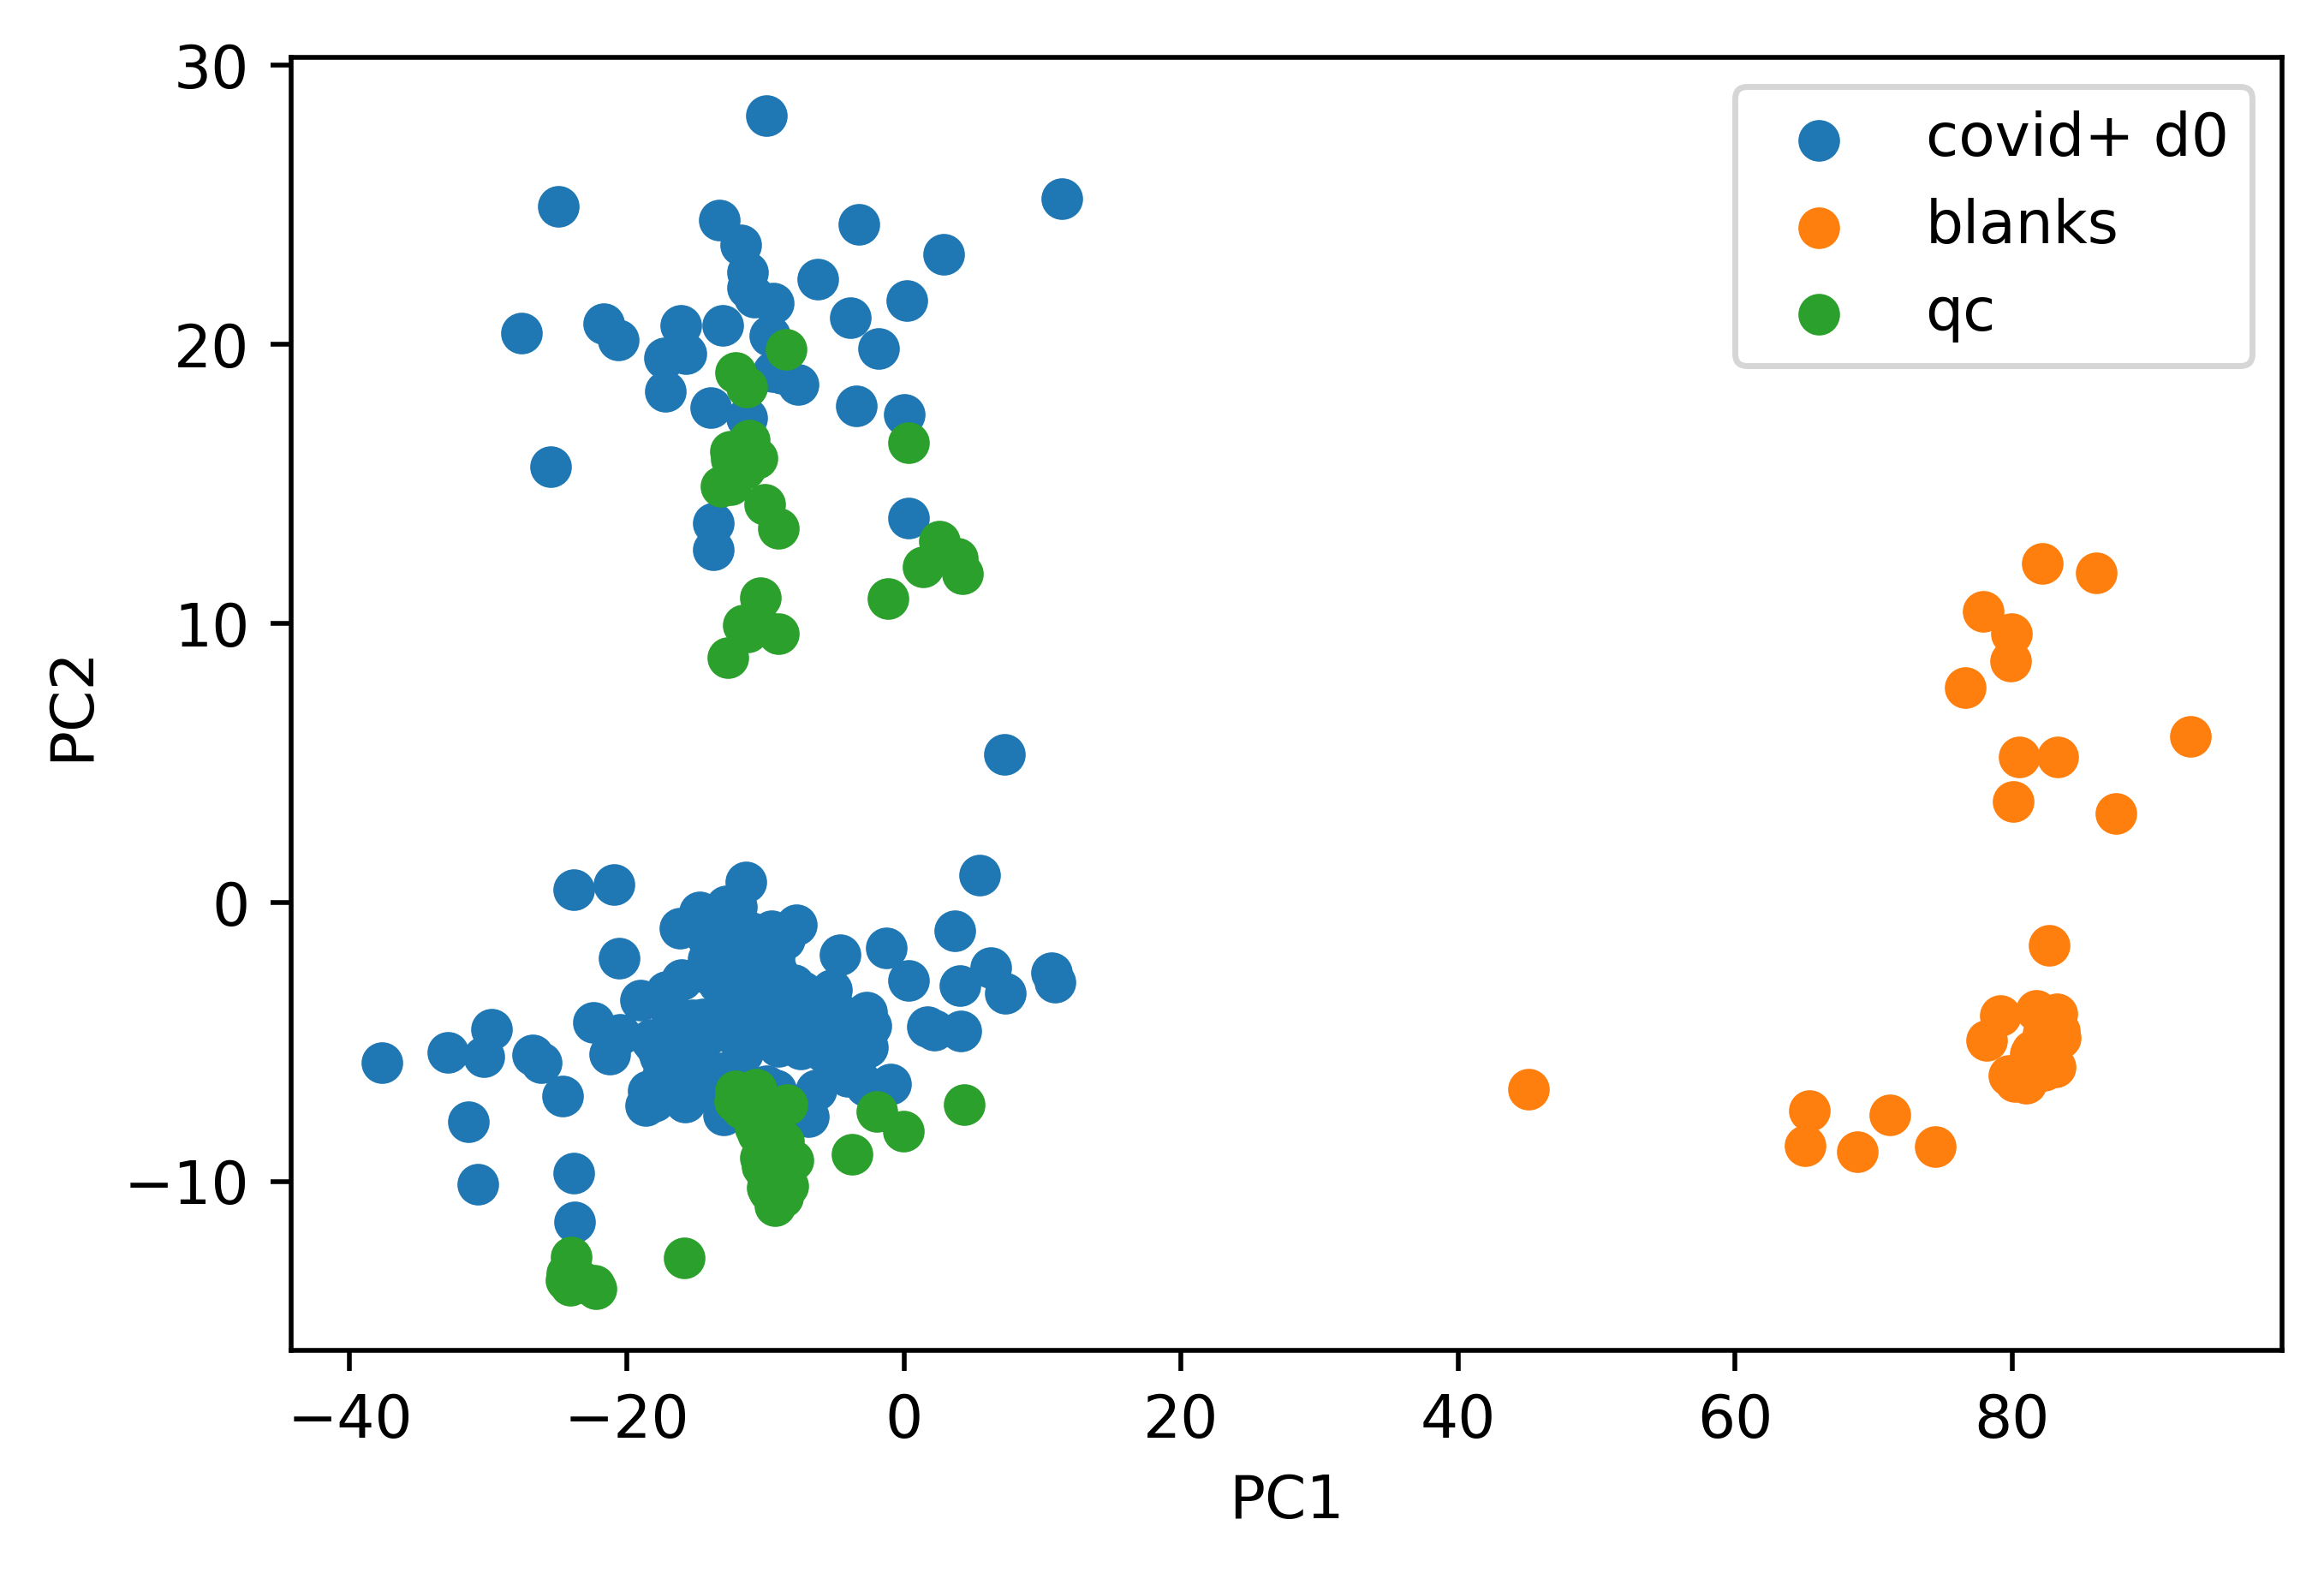

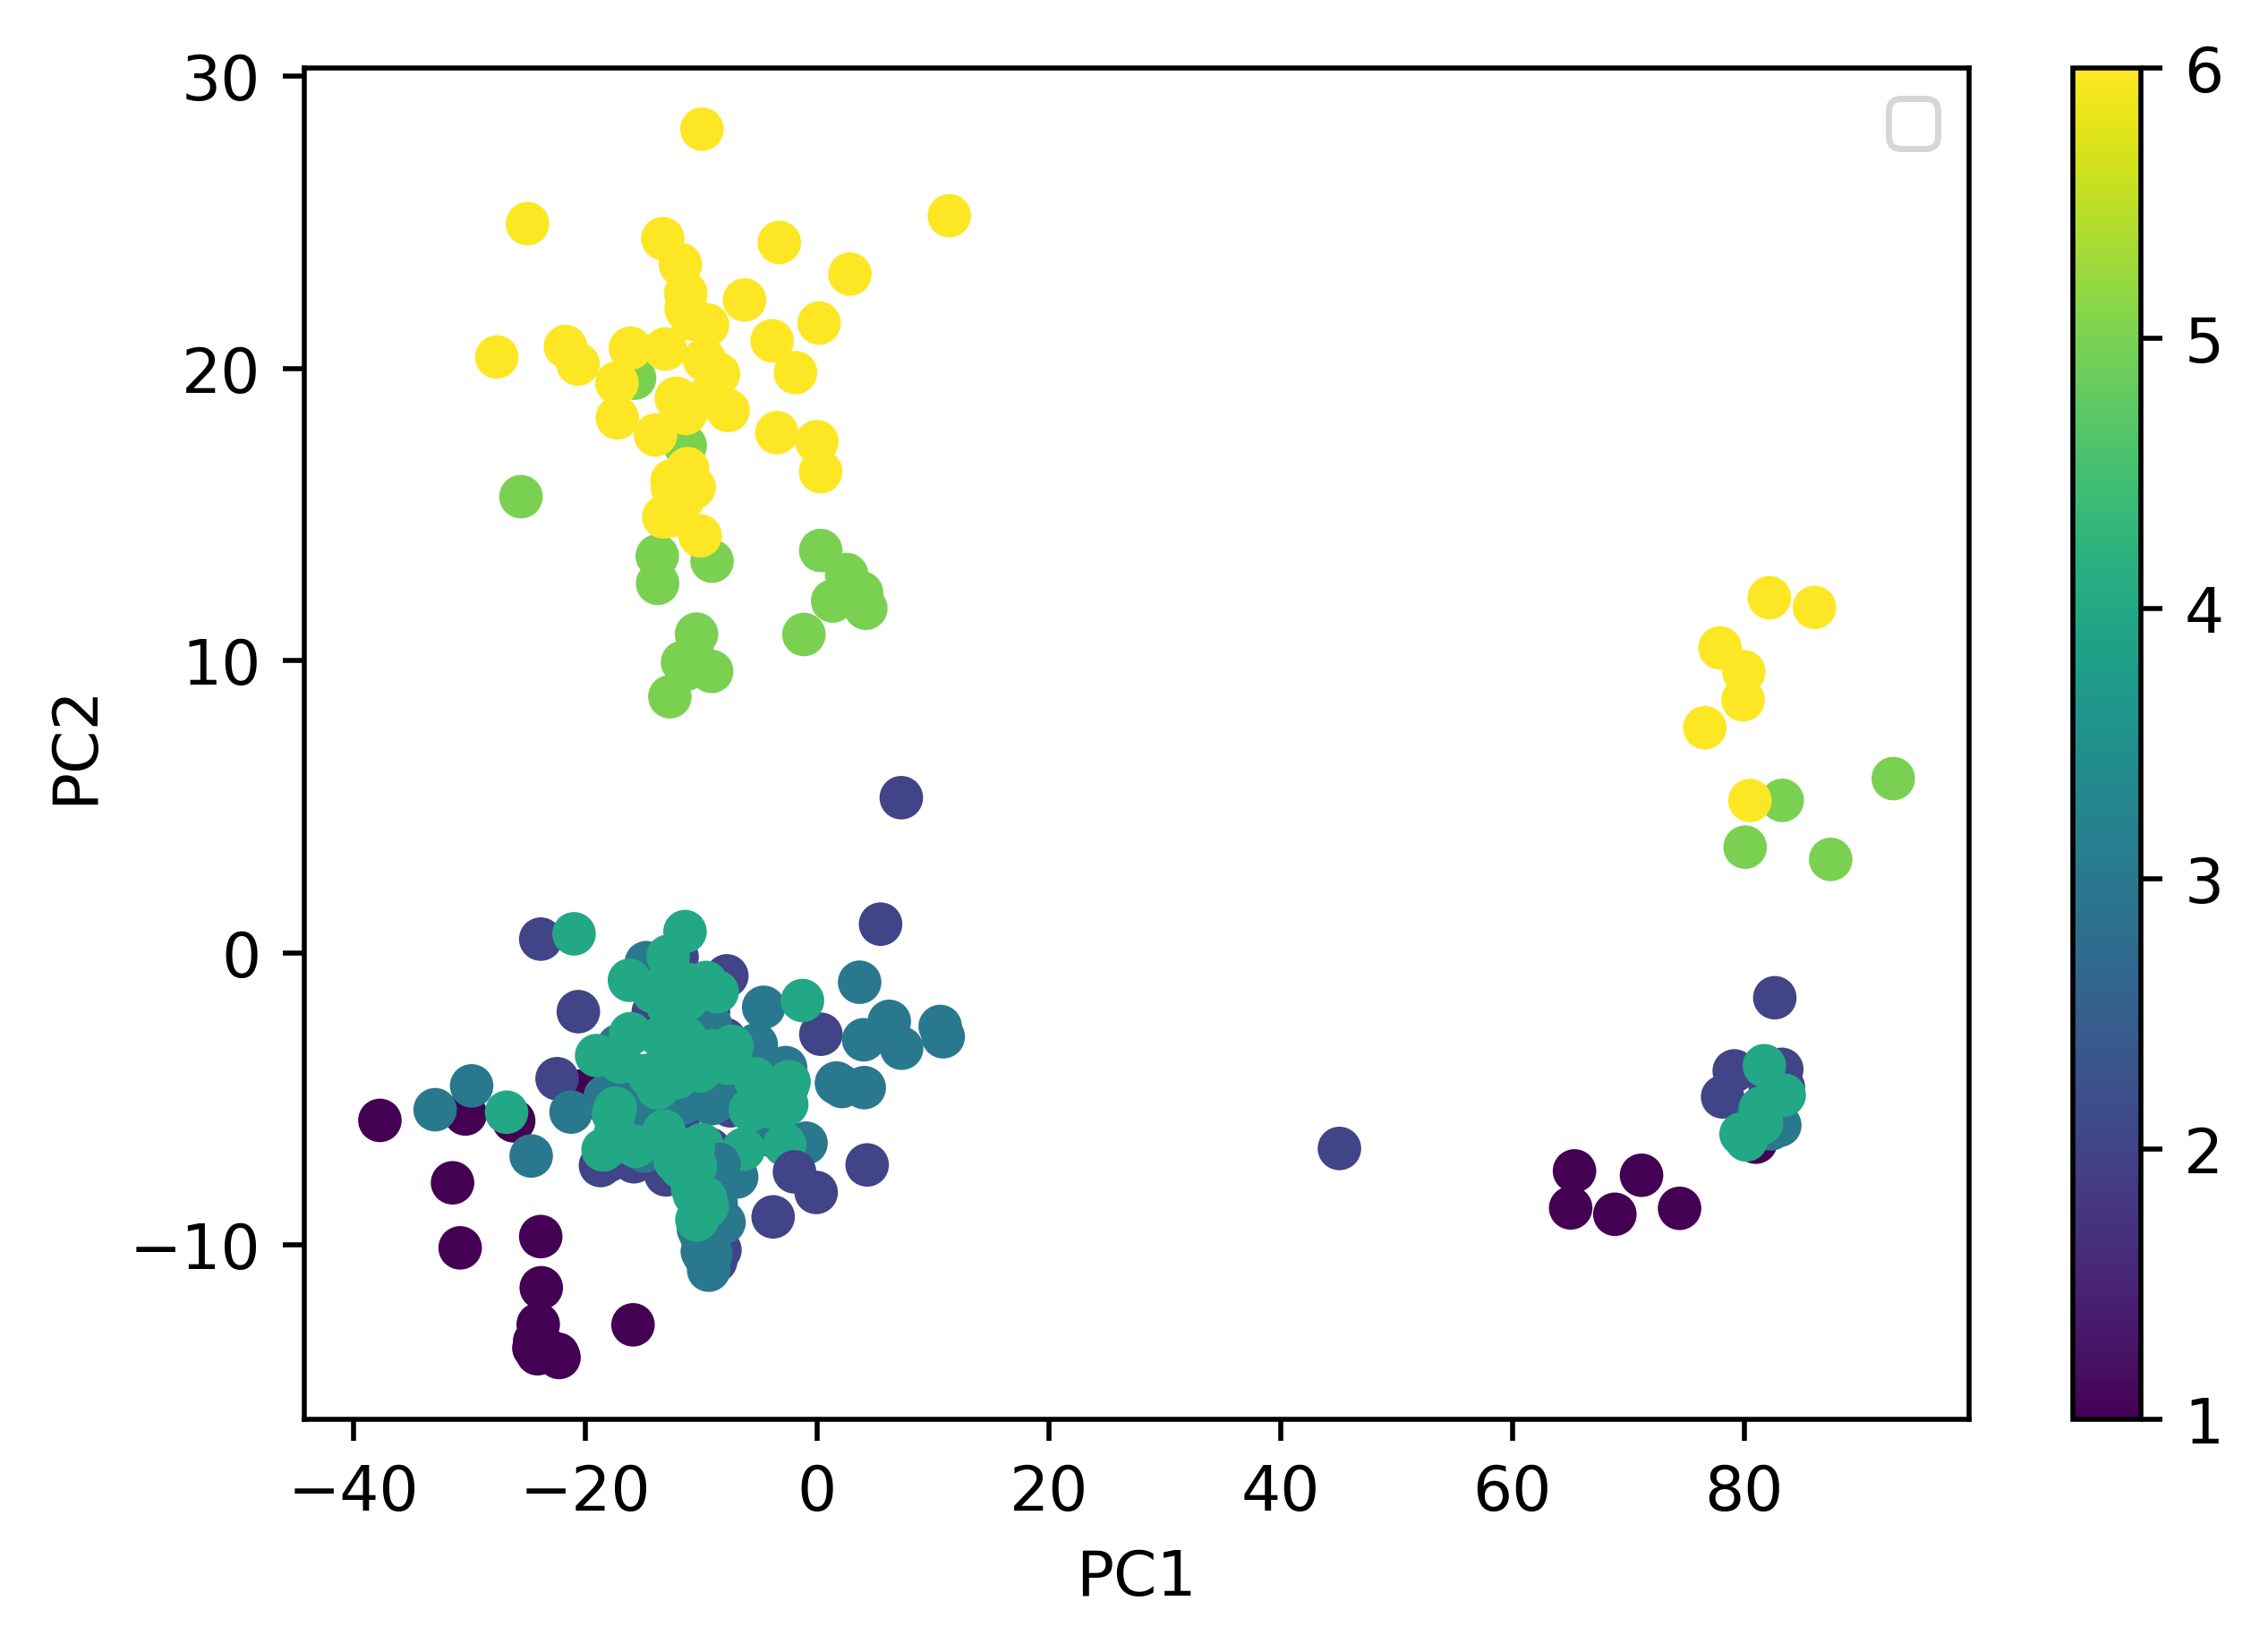

In [6]:
#now no normalize

d_whole_norm = np.array(d_whole_imput)

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#separate samples
samp_whole_int = d_whole_norm[:len(samp_int)]
qc_whole_int = d_whole_norm[len(samp_int)+len(blank_int):]

#compute variances
sample_variance = np.var(samp_whole_int,axis=0)
qc_variance = np.var(qc_whole_int,axis=0)

norm_var = np.linalg.norm(sample_variance)/np.linalg.norm(qc_variance)

print(norm_var)

print(np.mean(sample_variance),np.mean(qc_variance),np.mean(norm_var))

No handles with labels found to put in legend.


1.1711556723910026
1.5236769881781946e-07 5.5541063768029805e-08 1.1711556723910026


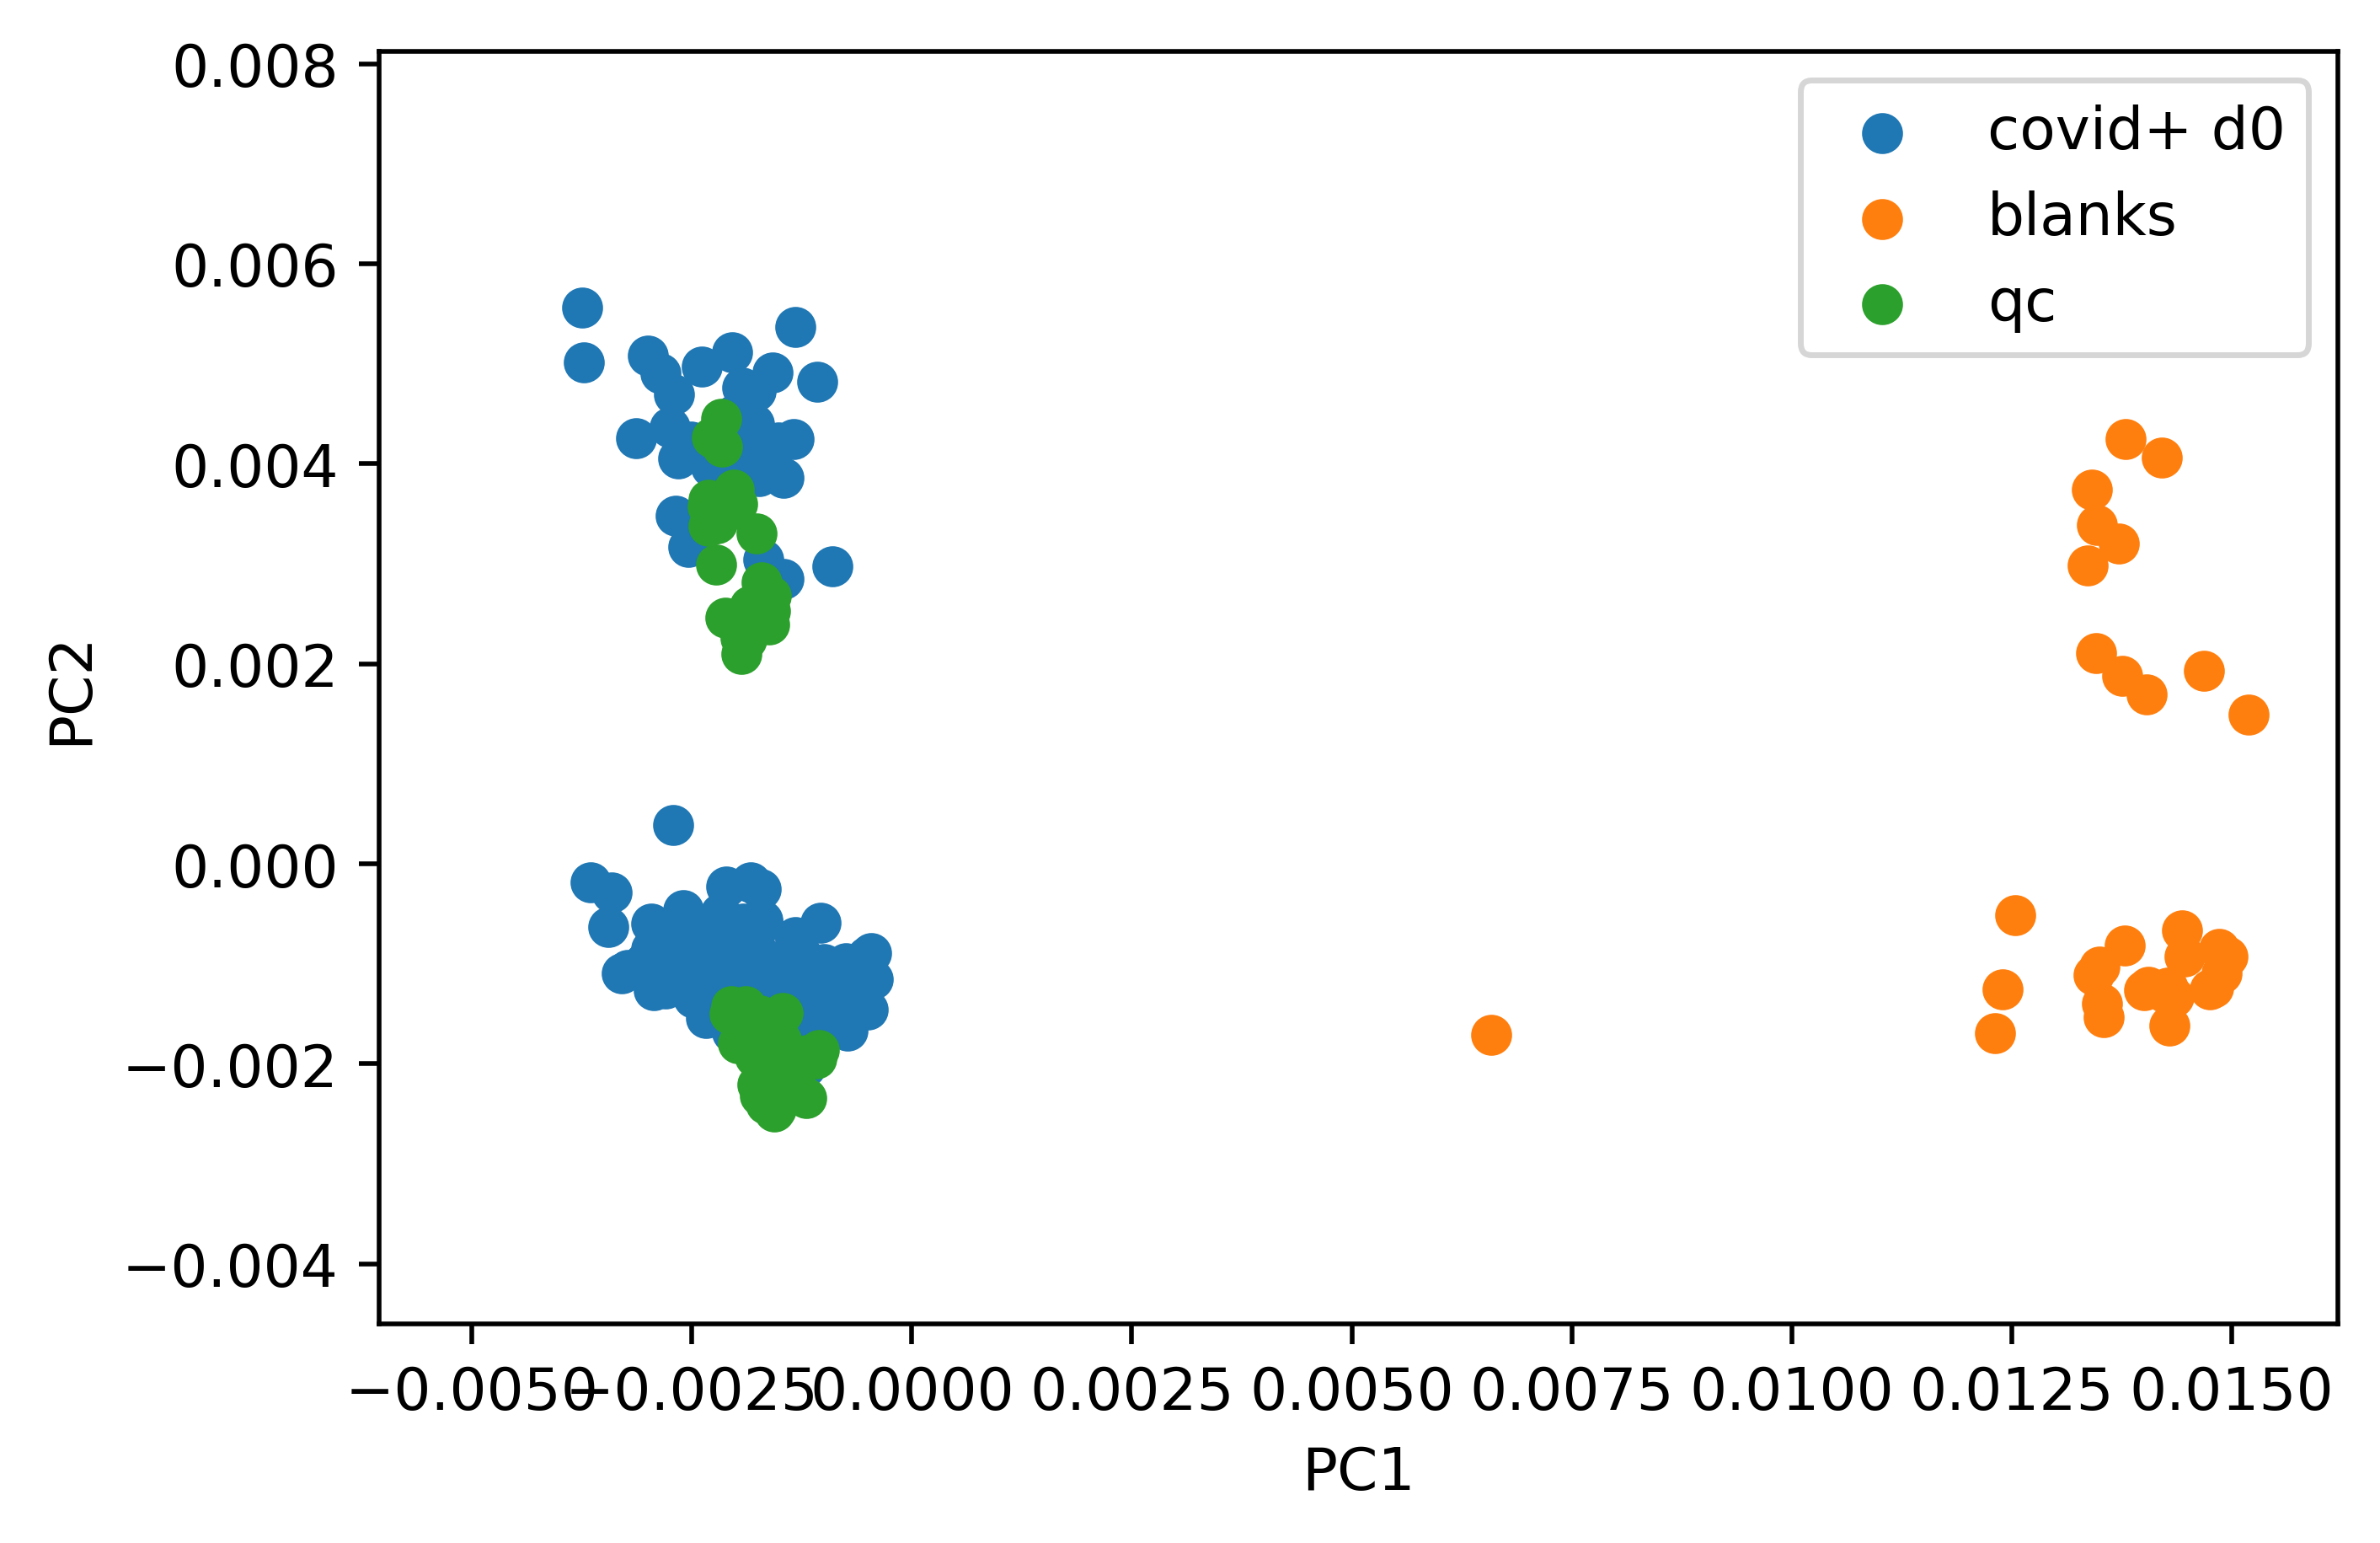

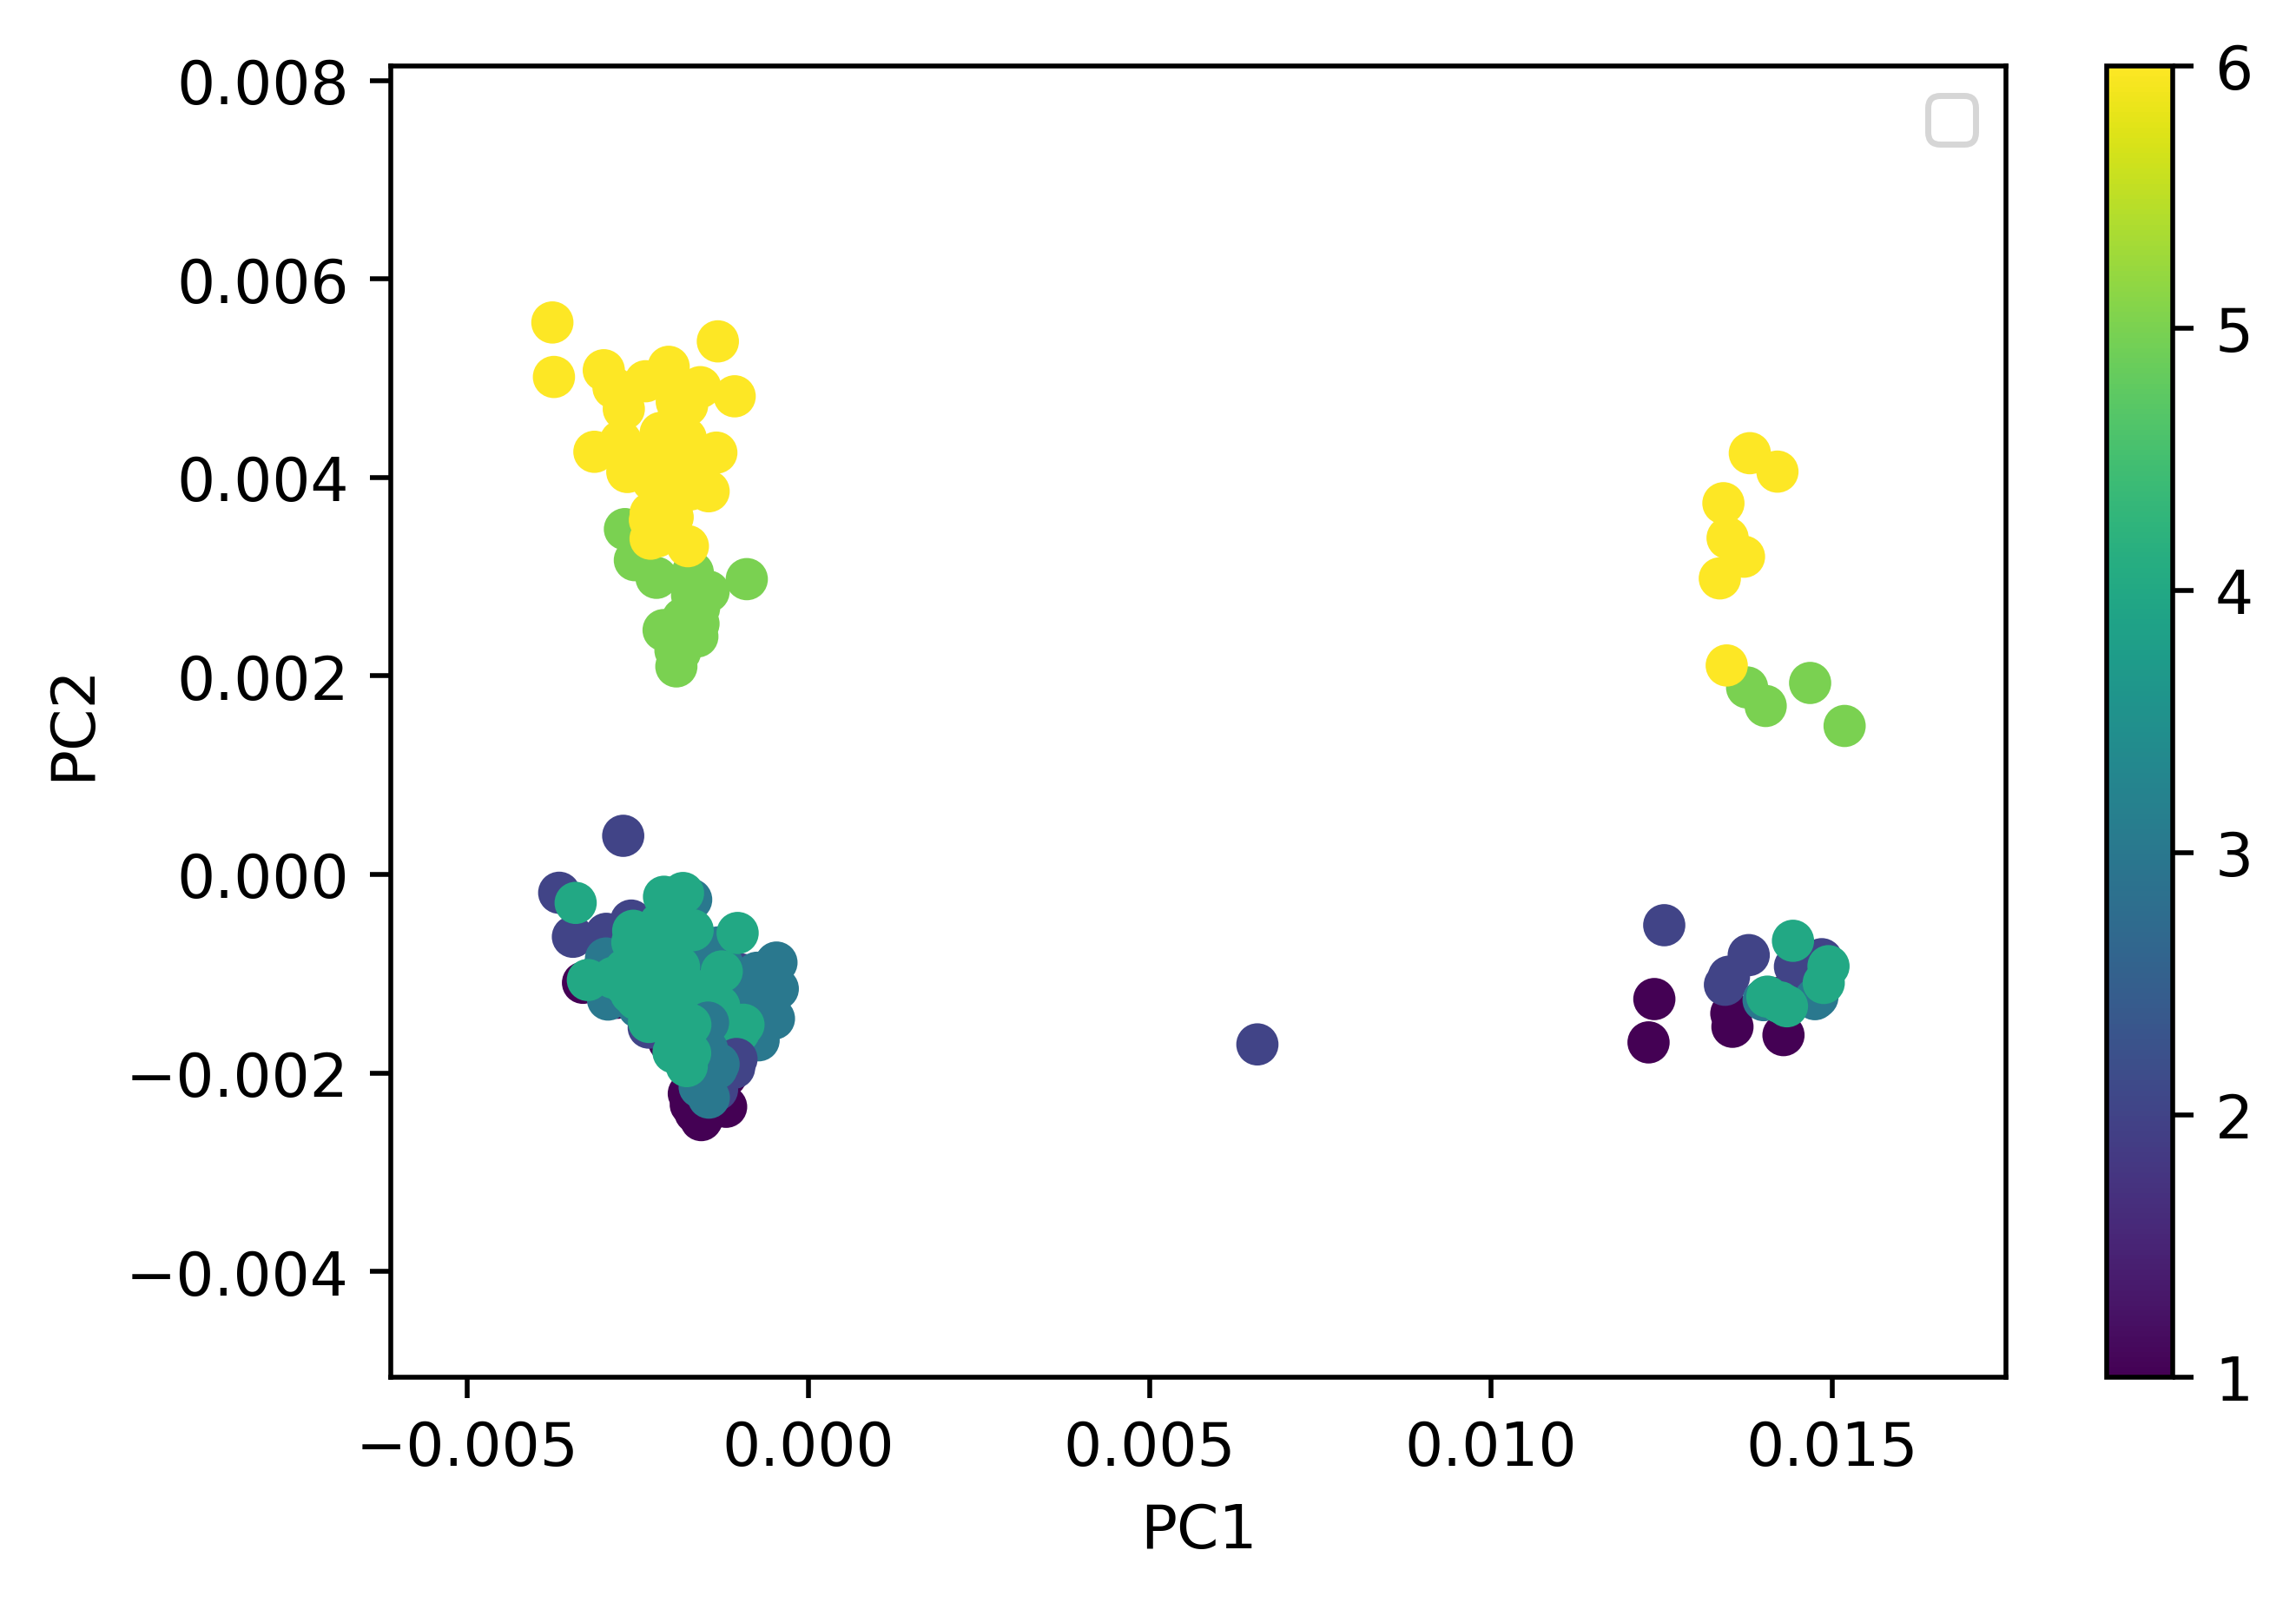

In [7]:
#now constant normalize

d_whole_norm = sklearn.preprocessing.normalize(d_whole_imput,norm="l1")

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#separate samples
samp_whole_int = d_whole_norm[:len(samp_int)]
qc_whole_int = d_whole_norm[len(samp_int)+len(blank_int):]

#compute variances
sample_variance = np.var(samp_whole_int,axis=0)
qc_variance = np.var(qc_whole_int,axis=0)

norm_var = np.linalg.norm(sample_variance)/np.linalg.norm(qc_variance)

print(norm_var)

print(np.mean(sample_variance),np.mean(qc_variance),np.mean(norm_var))

No handles with labels found to put in legend.


1.1490796665053198
0.18031461780618369 0.06779925642481674 1.1490796665053198


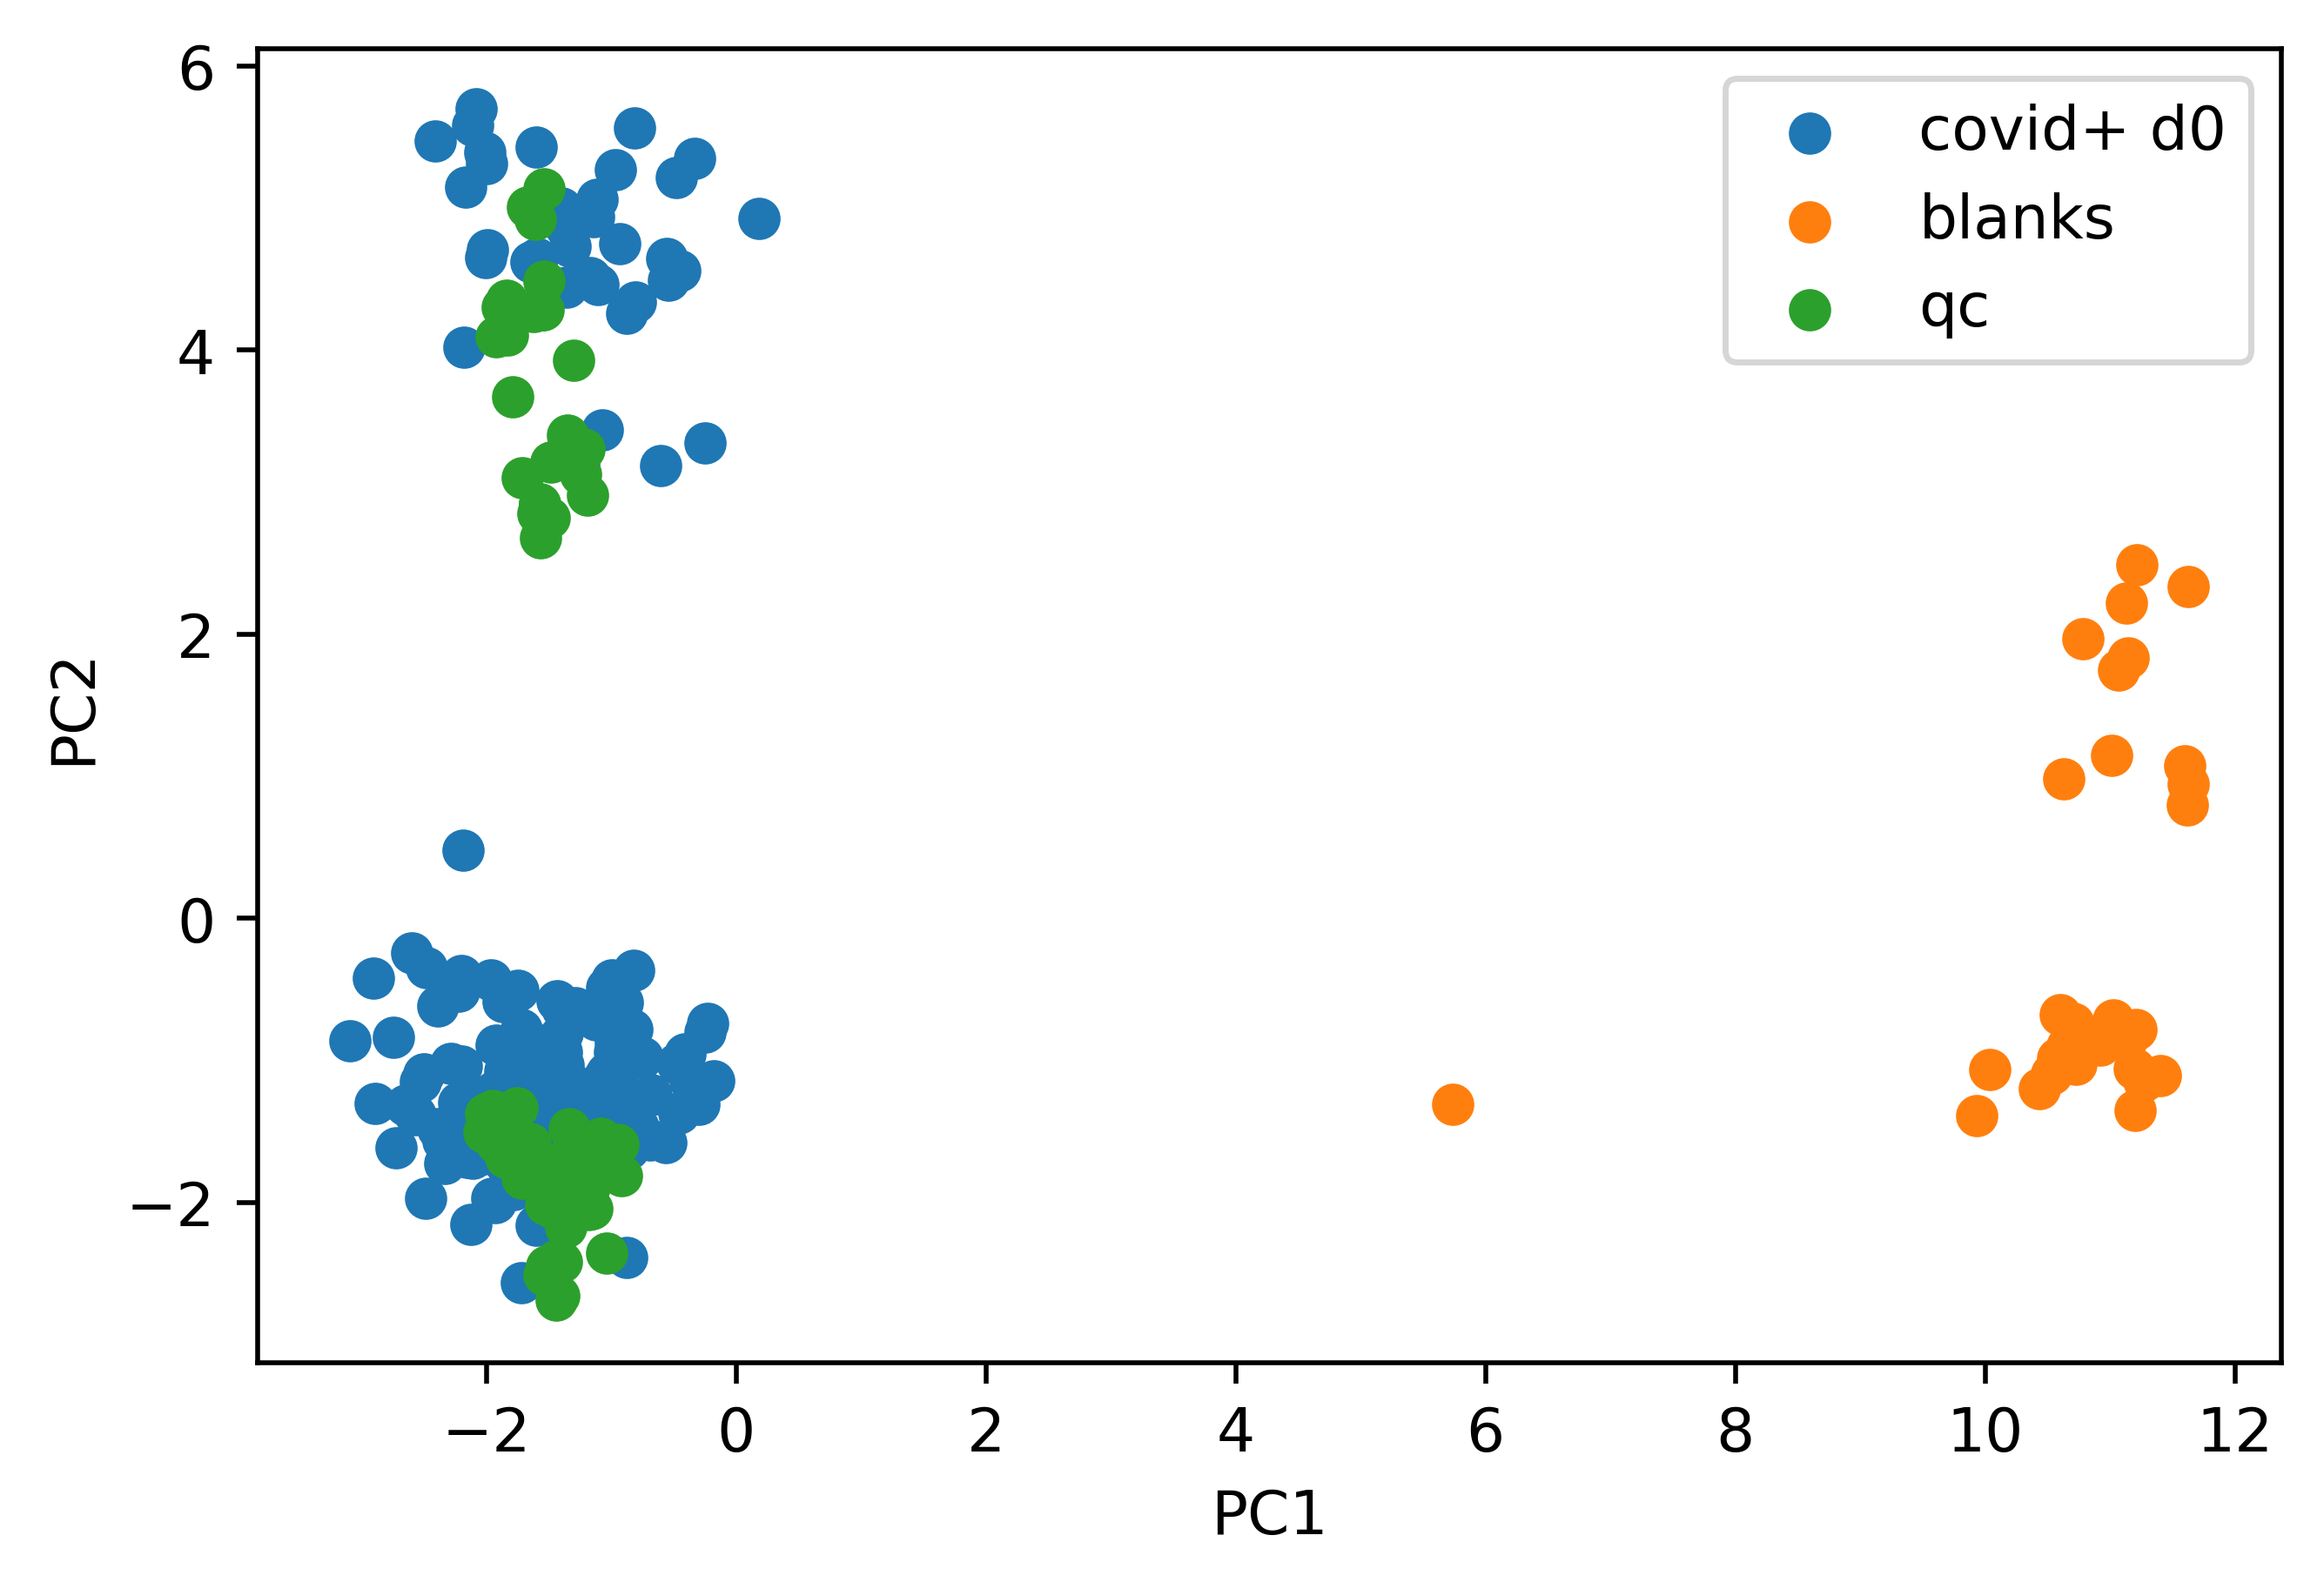

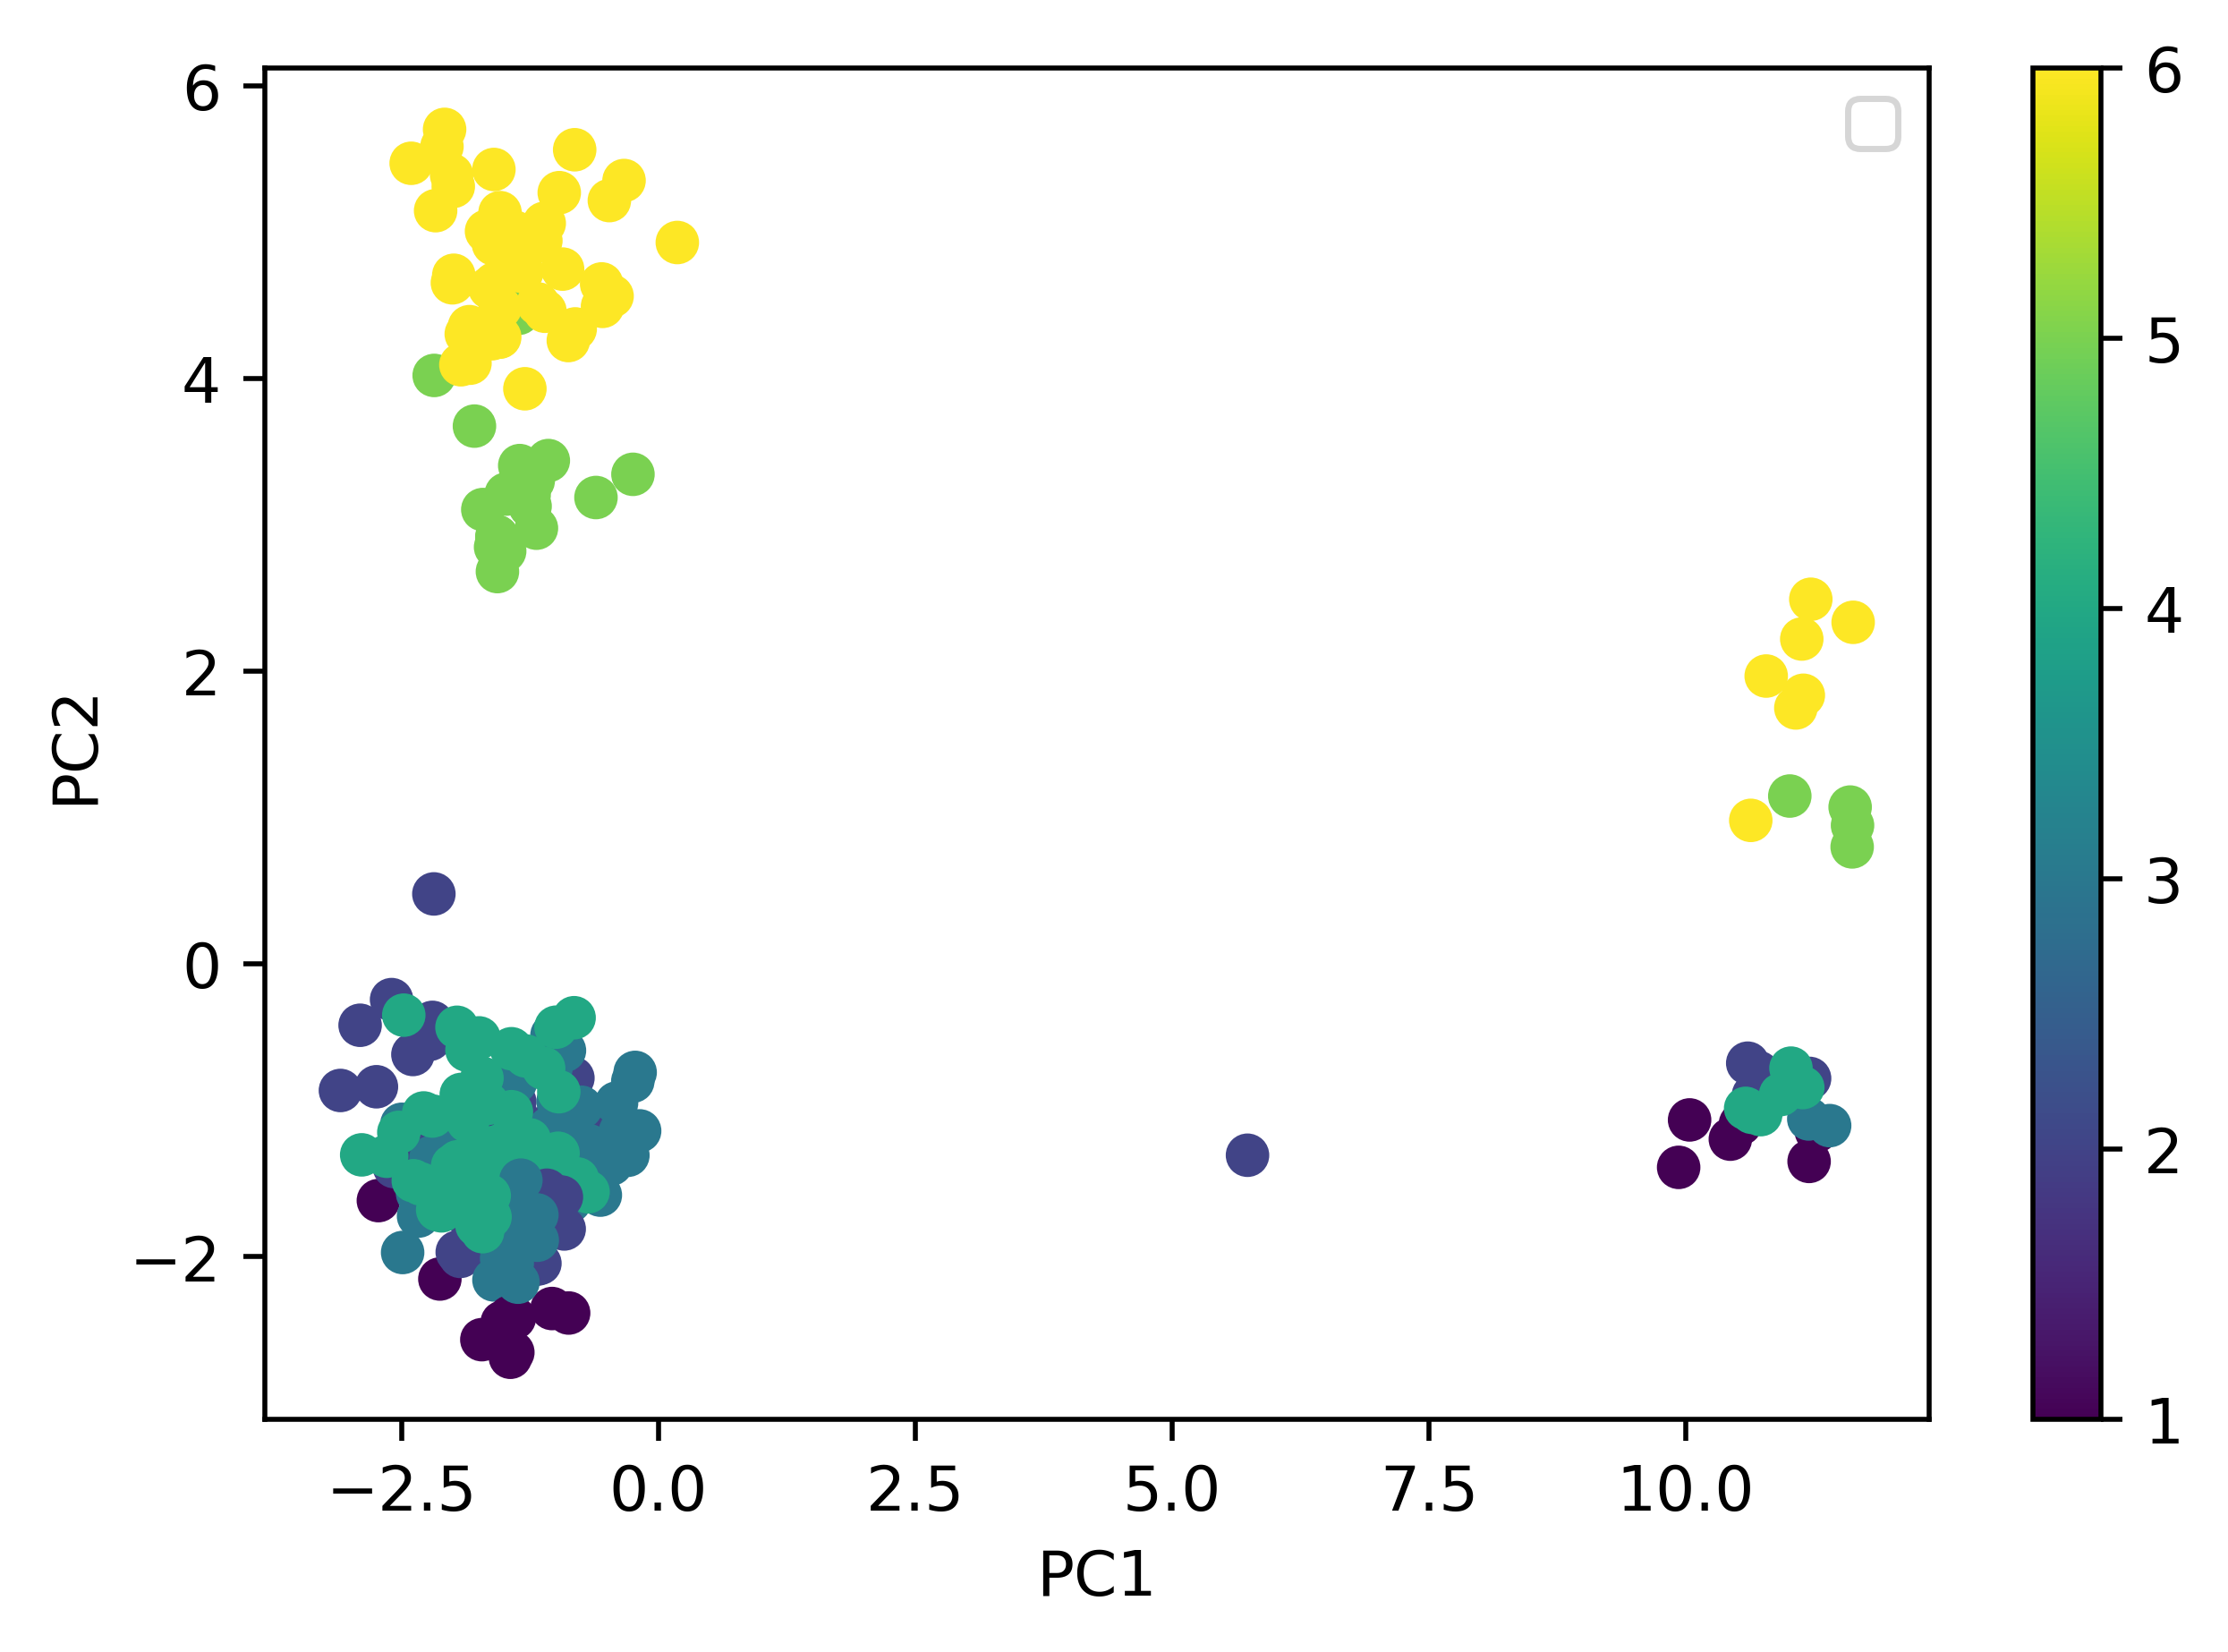

In [8]:
#now mean center and unit variance


d_whole_norm = sklearn.preprocessing.scale(d_whole_imput,axis=1)

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#separate samples
samp_whole_int = d_whole_norm[:len(samp_int)]
qc_whole_int = d_whole_norm[len(samp_int)+len(blank_int):]

#compute variances
sample_variance = np.var(samp_whole_int,axis=0)
qc_variance = np.var(qc_whole_int,axis=0)

norm_var = np.linalg.norm(sample_variance)/np.linalg.norm(qc_variance)

print(norm_var)

print(np.mean(sample_variance),np.mean(qc_variance),np.mean(norm_var))

No handles with labels found to put in legend.


1.1693872665303362
3.406495801582136e-05 1.2437227294246783e-05 1.1693872665303362


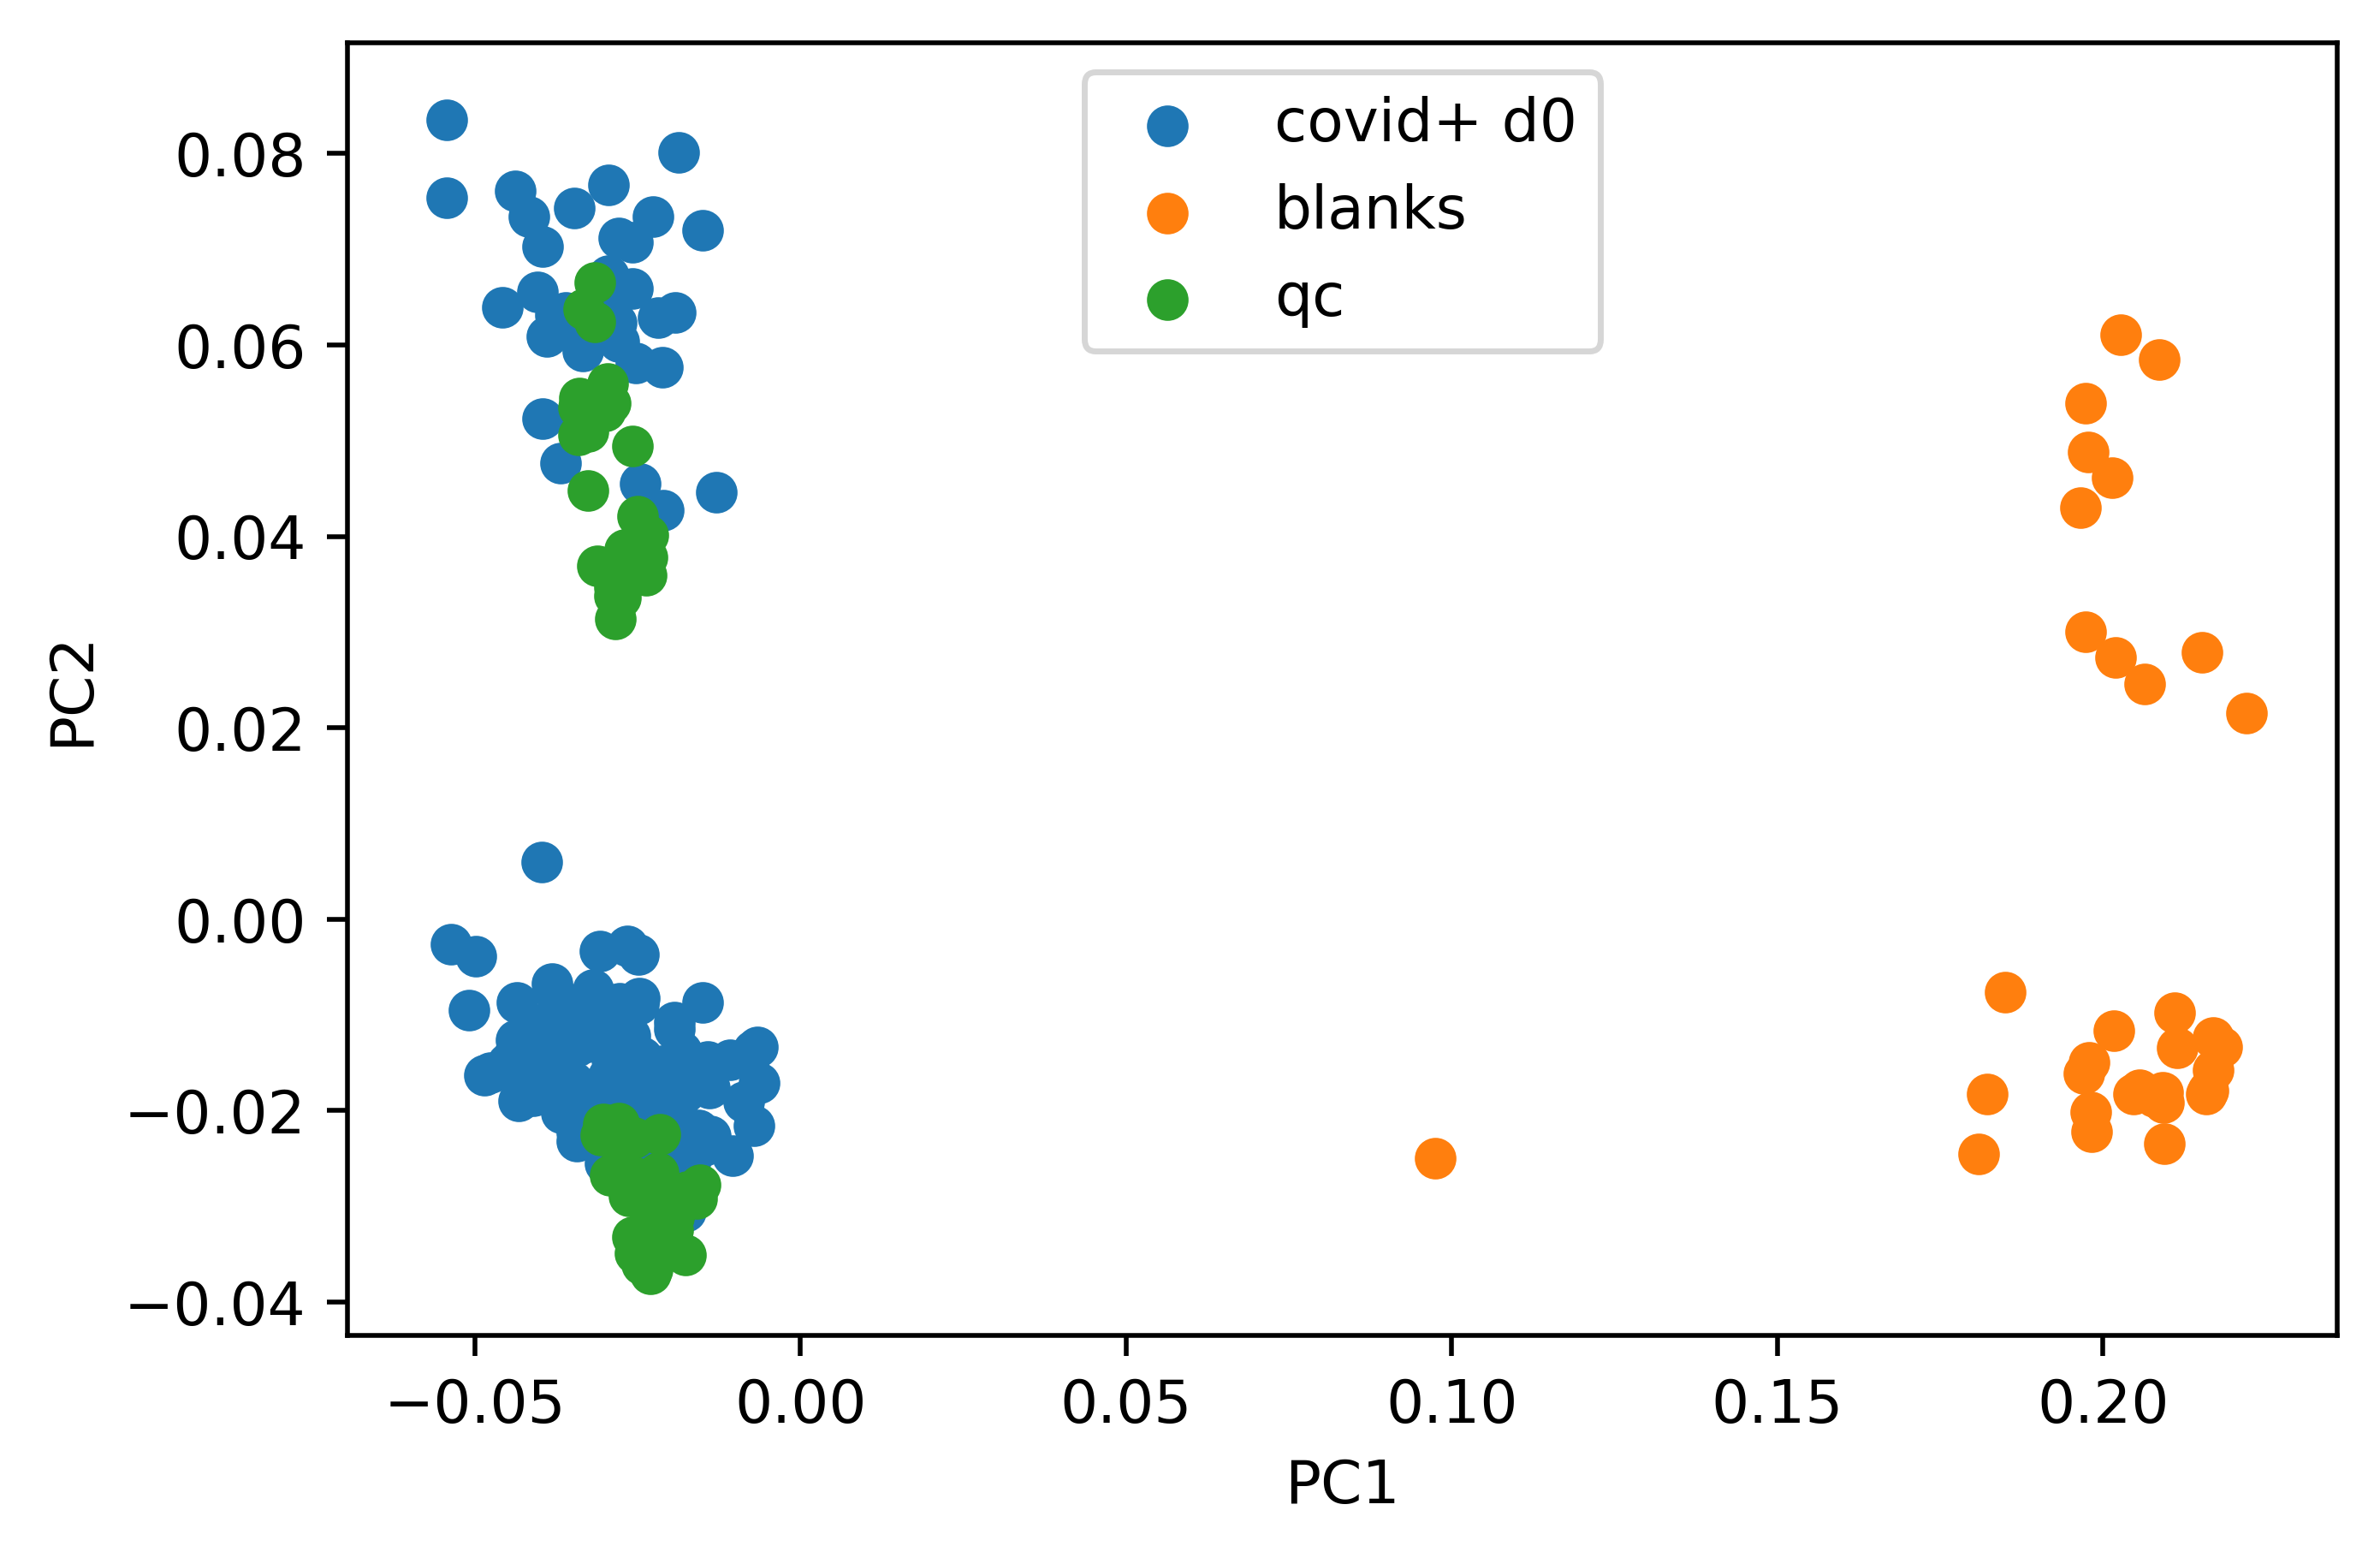

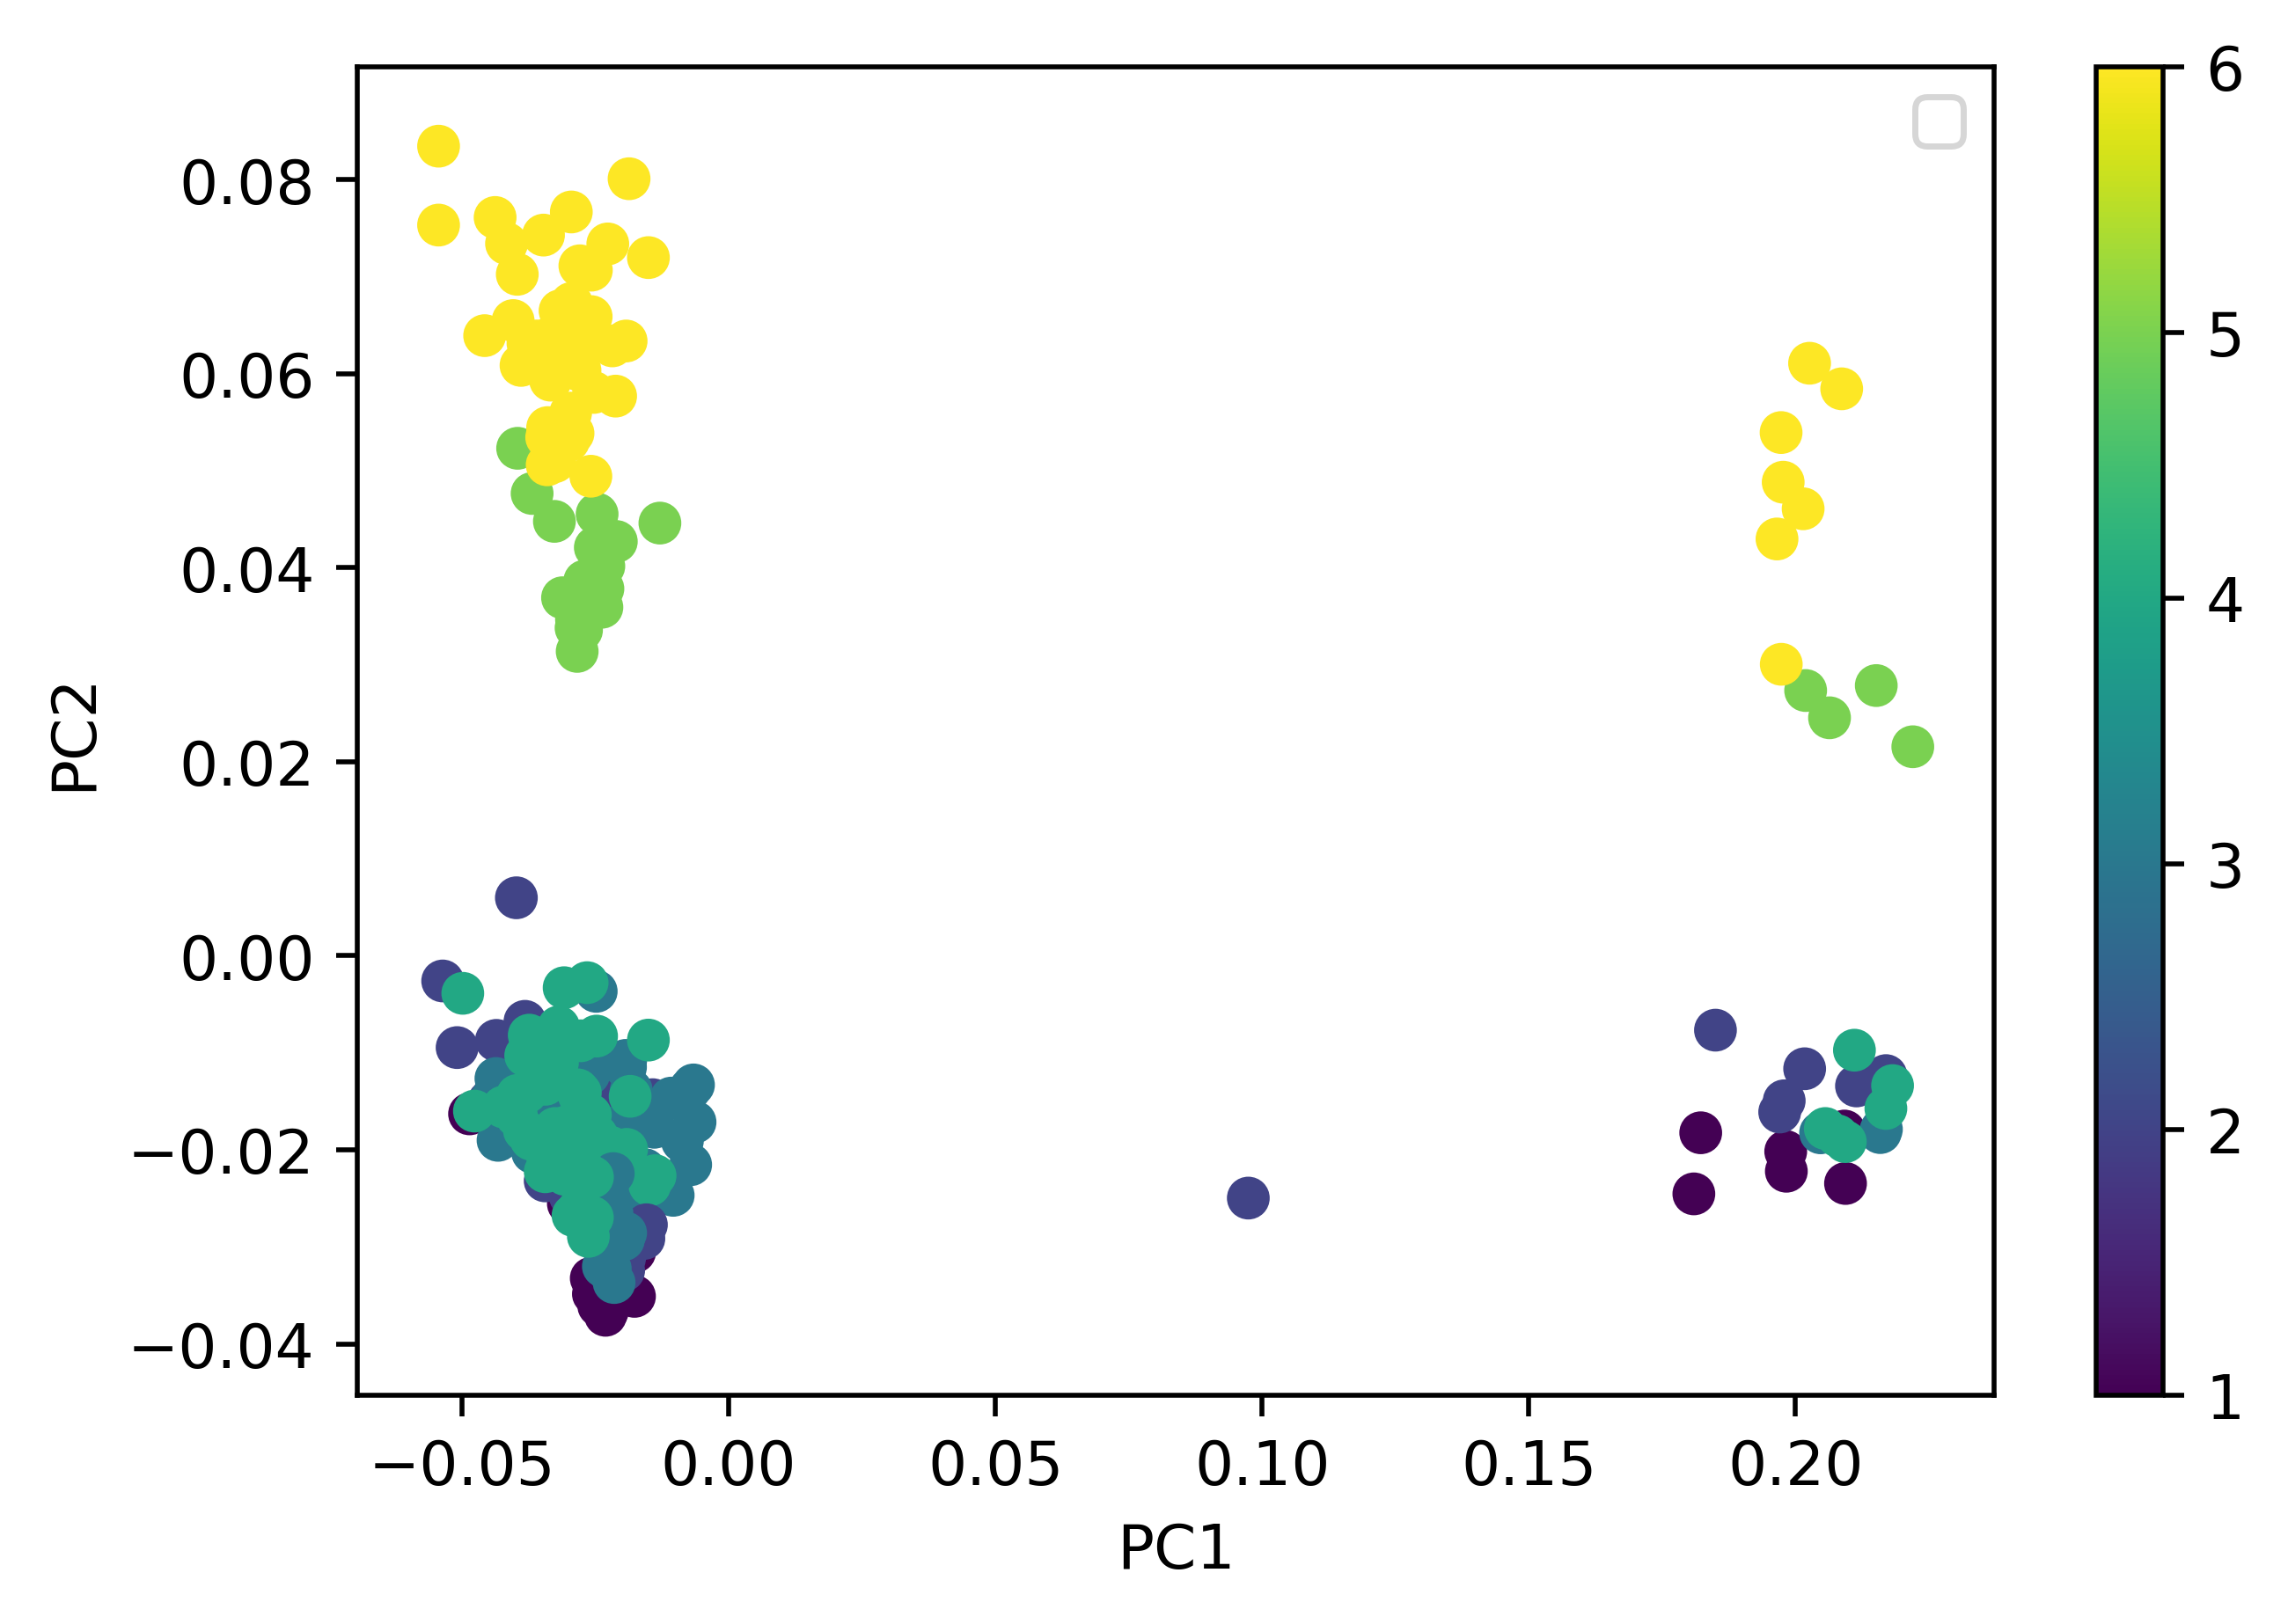

In [9]:
#normalize with l2 norm

d_whole_norm = sklearn.preprocessing.normalize(d_whole_imput,norm="l2")

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#separate samples
samp_whole_int = d_whole_norm[:len(samp_int)]
qc_whole_int = d_whole_norm[len(samp_int)+len(blank_int):]

#compute variances
sample_variance = np.var(samp_whole_int,axis=0)
qc_variance = np.var(qc_whole_int,axis=0)

norm_var = np.linalg.norm(sample_variance)/np.linalg.norm(qc_variance)

print(norm_var)

print(np.mean(sample_variance),np.mean(qc_variance),np.mean(norm_var))

No handles with labels found to put in legend.


1.3372277902609135
0.005534503504729082 0.0021796266297084677 1.3372277902609135


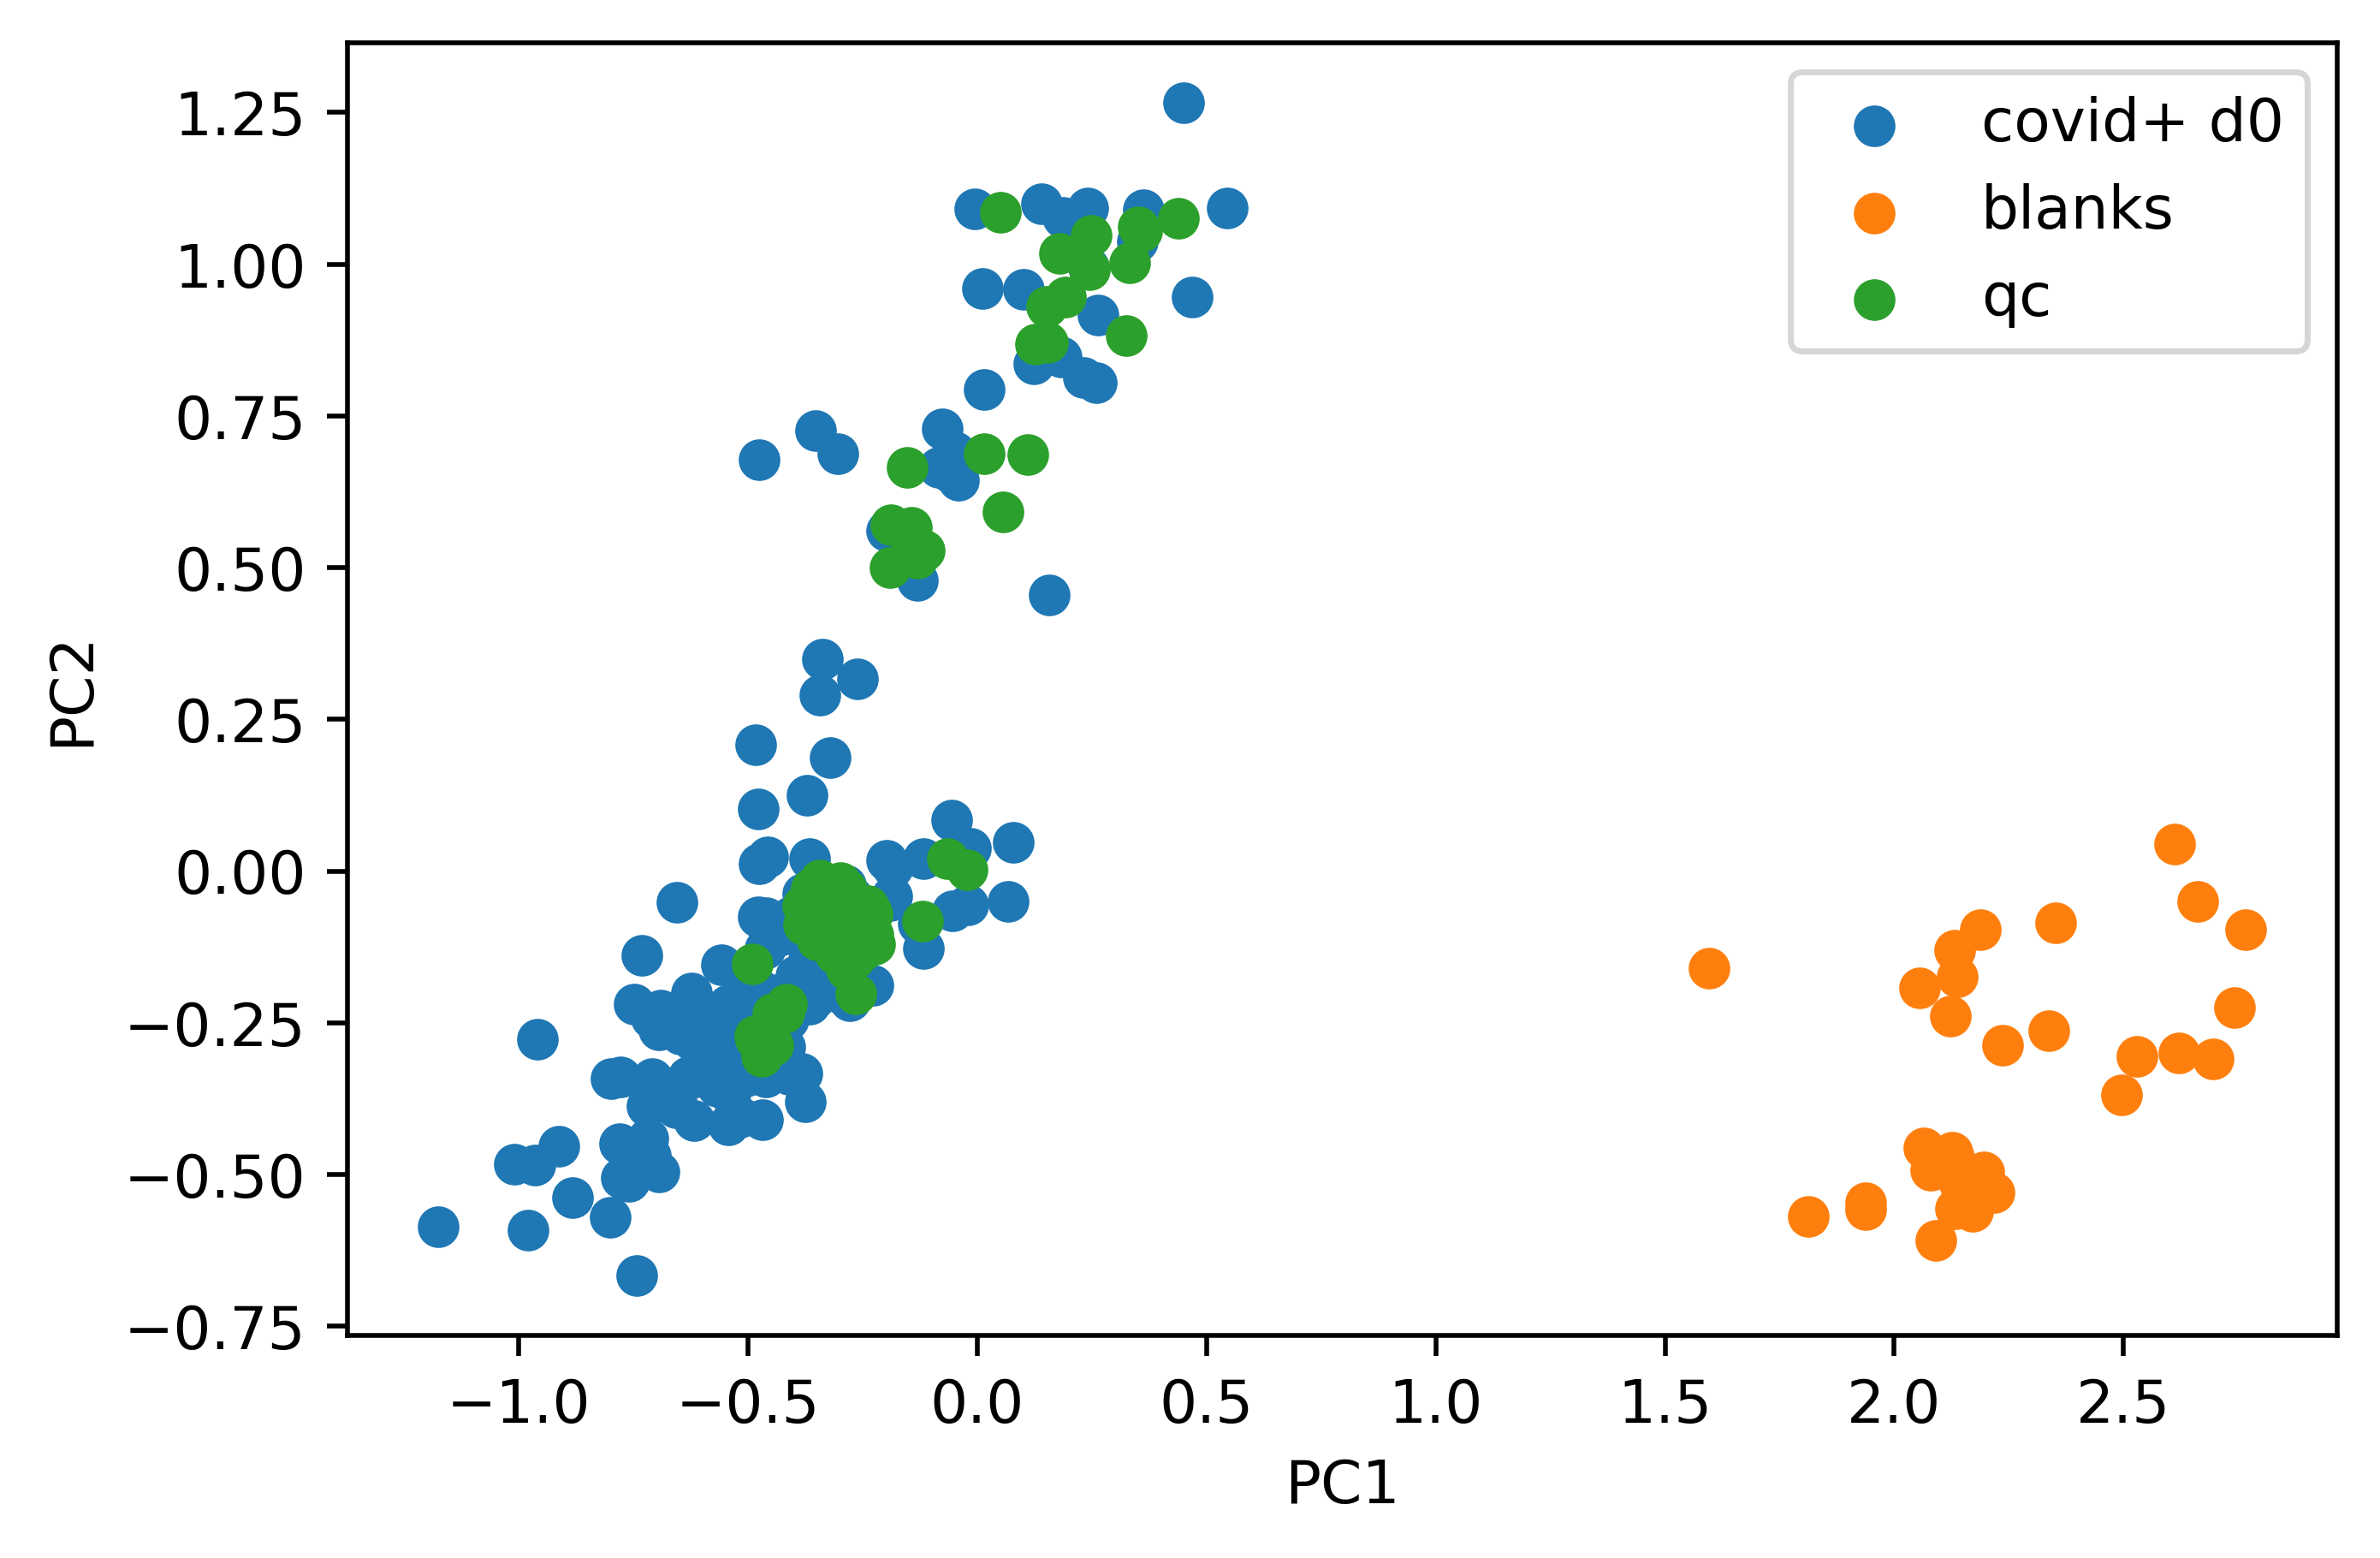

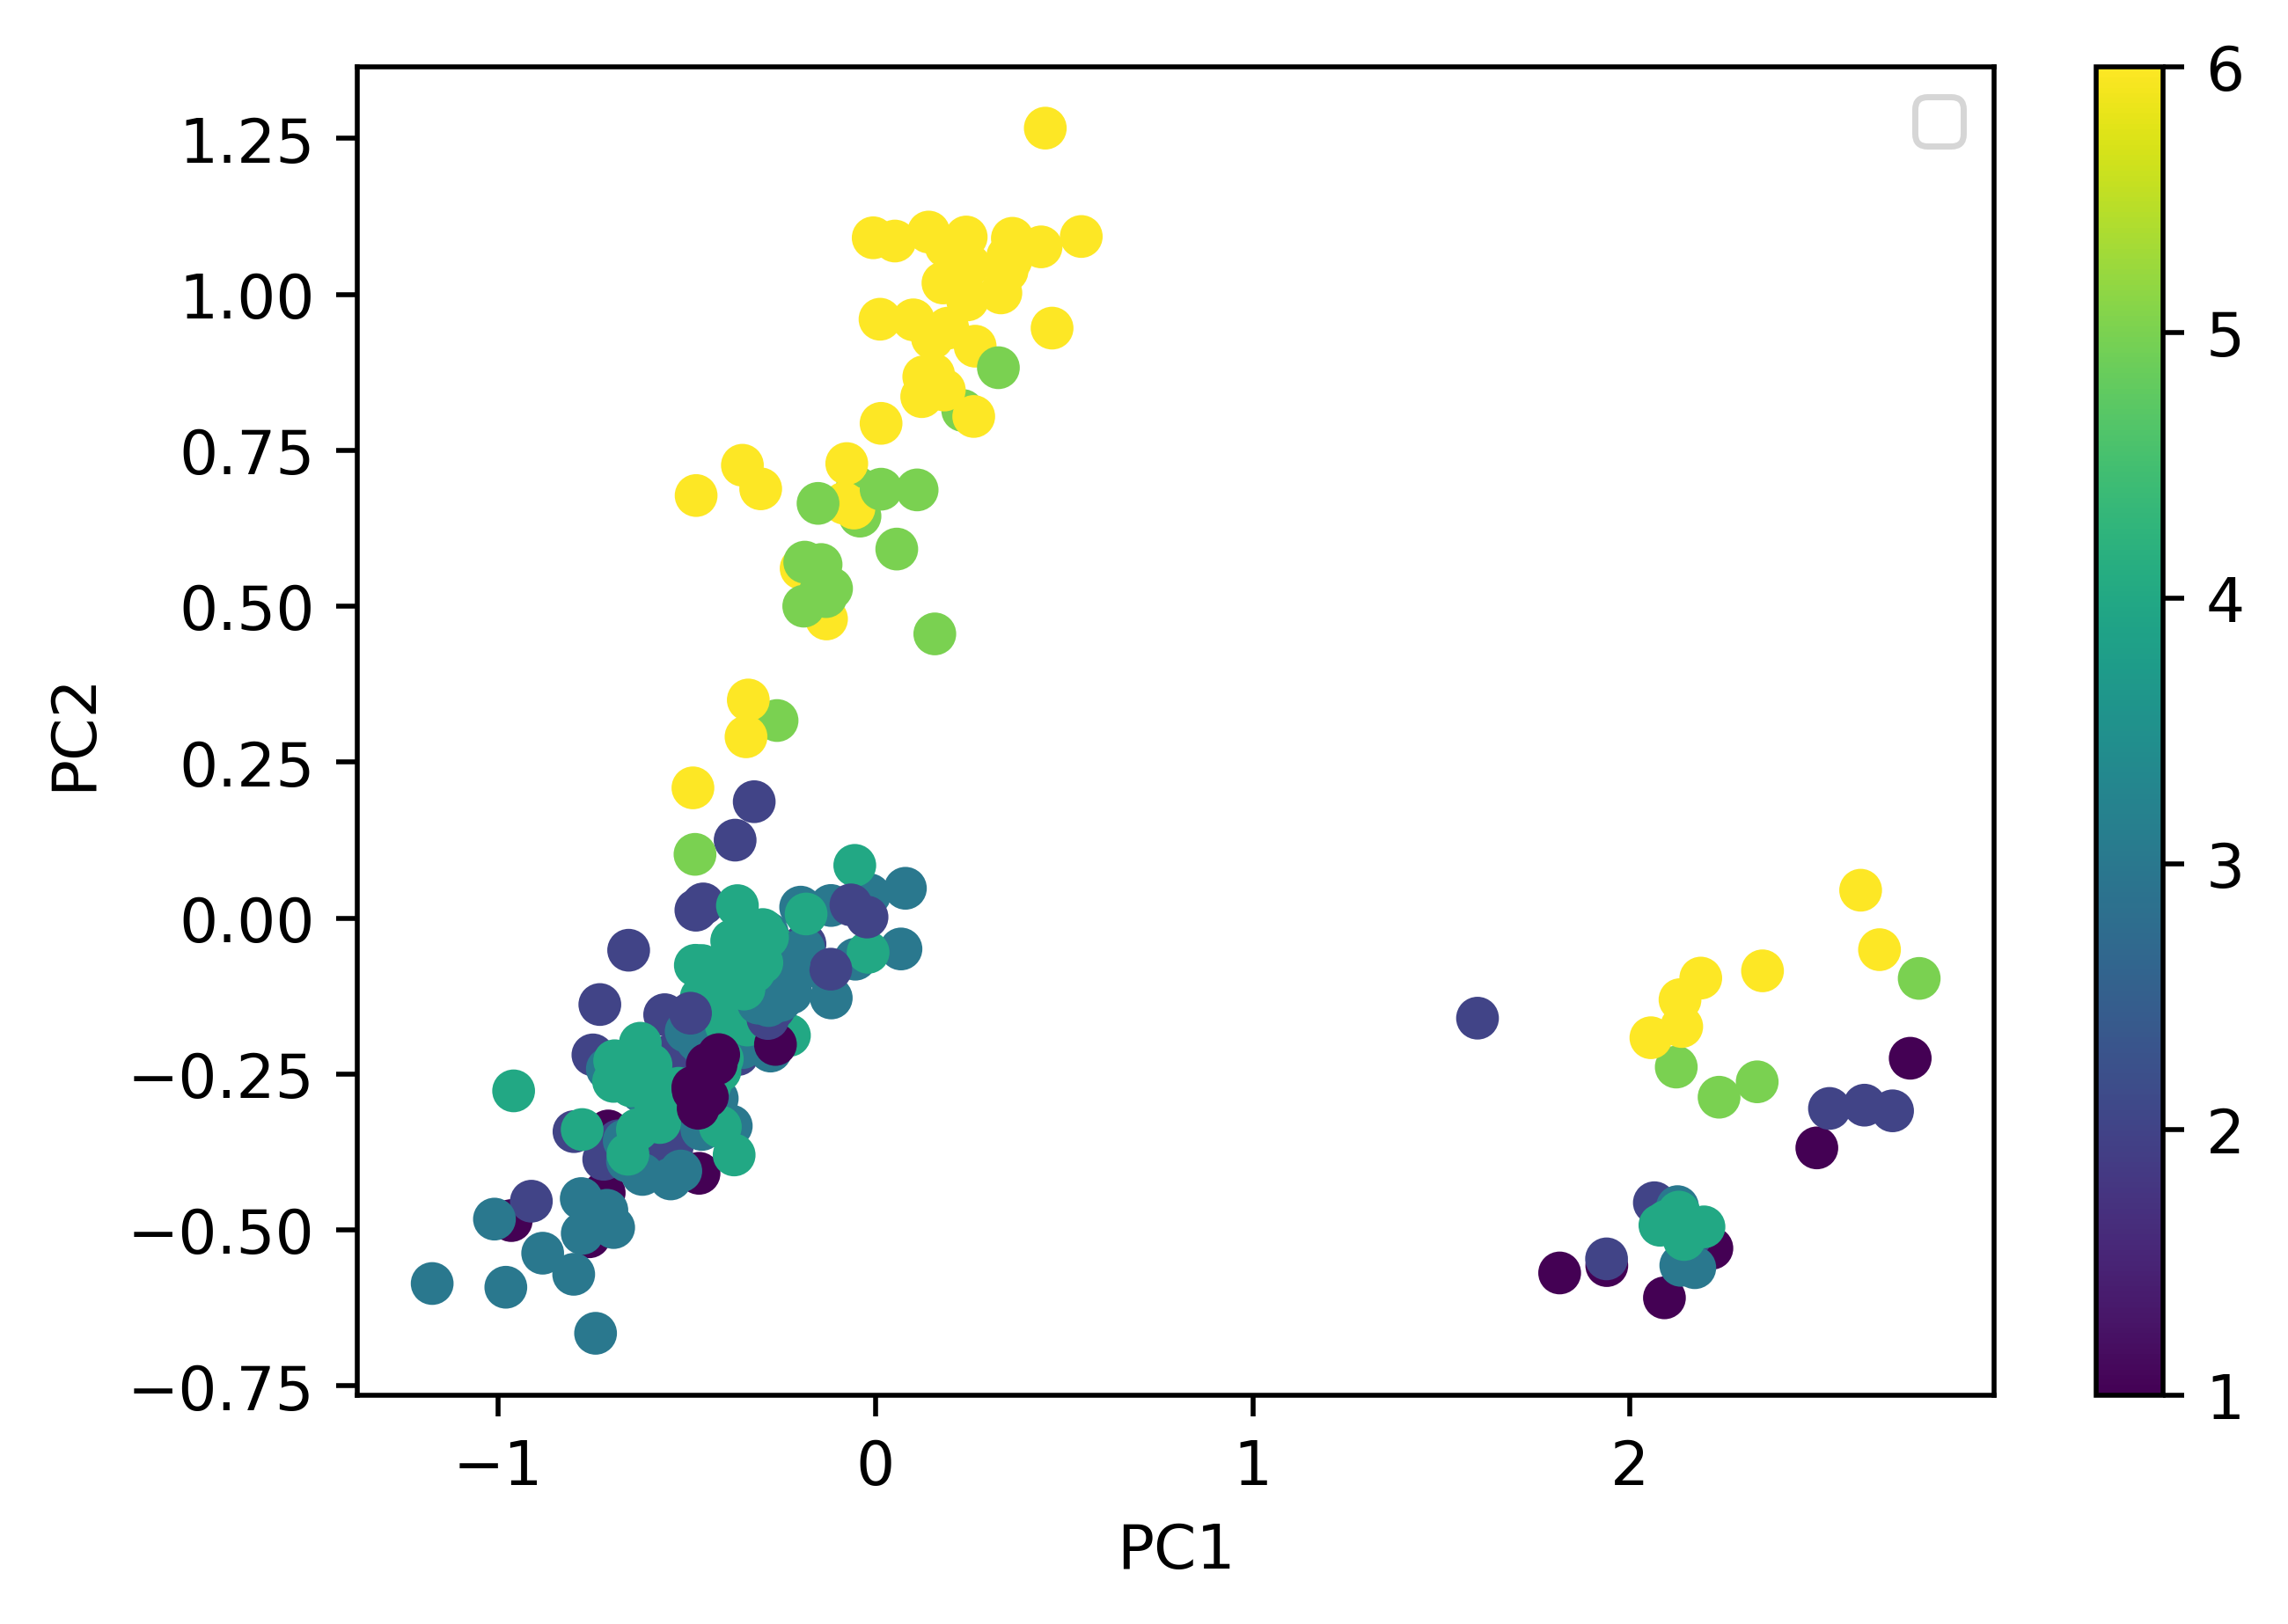

In [10]:
#now 100 percentile shift

d_whole_norm = []
for s in d_whole_imput:
    mi,ma = np.percentile(s,[0,100])
    d_whole_norm.append([(x-mi)/(ma-mi) for x in s])
    
d_whole_norm = np.array(d_whole_norm)

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(Zsamp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#separate samples
samp_whole_int = d_whole_norm[:len(samp_int)]
qc_whole_int = d_whole_norm[len(samp_int)+len(blank_int):]

#compute variances
sample_variance = np.var(samp_whole_int,axis=0)
qc_variance = np.var(qc_whole_int,axis=0)

norm_var = np.linalg.norm(sample_variance)/np.linalg.norm(qc_variance)

print(norm_var)

print(np.mean(sample_variance),np.mean(qc_variance),np.mean(norm_var))

No handles with labels found to put in legend.


1.1867795489139623
0.13179064382071232 0.046970506561219684 1.1867795489139623


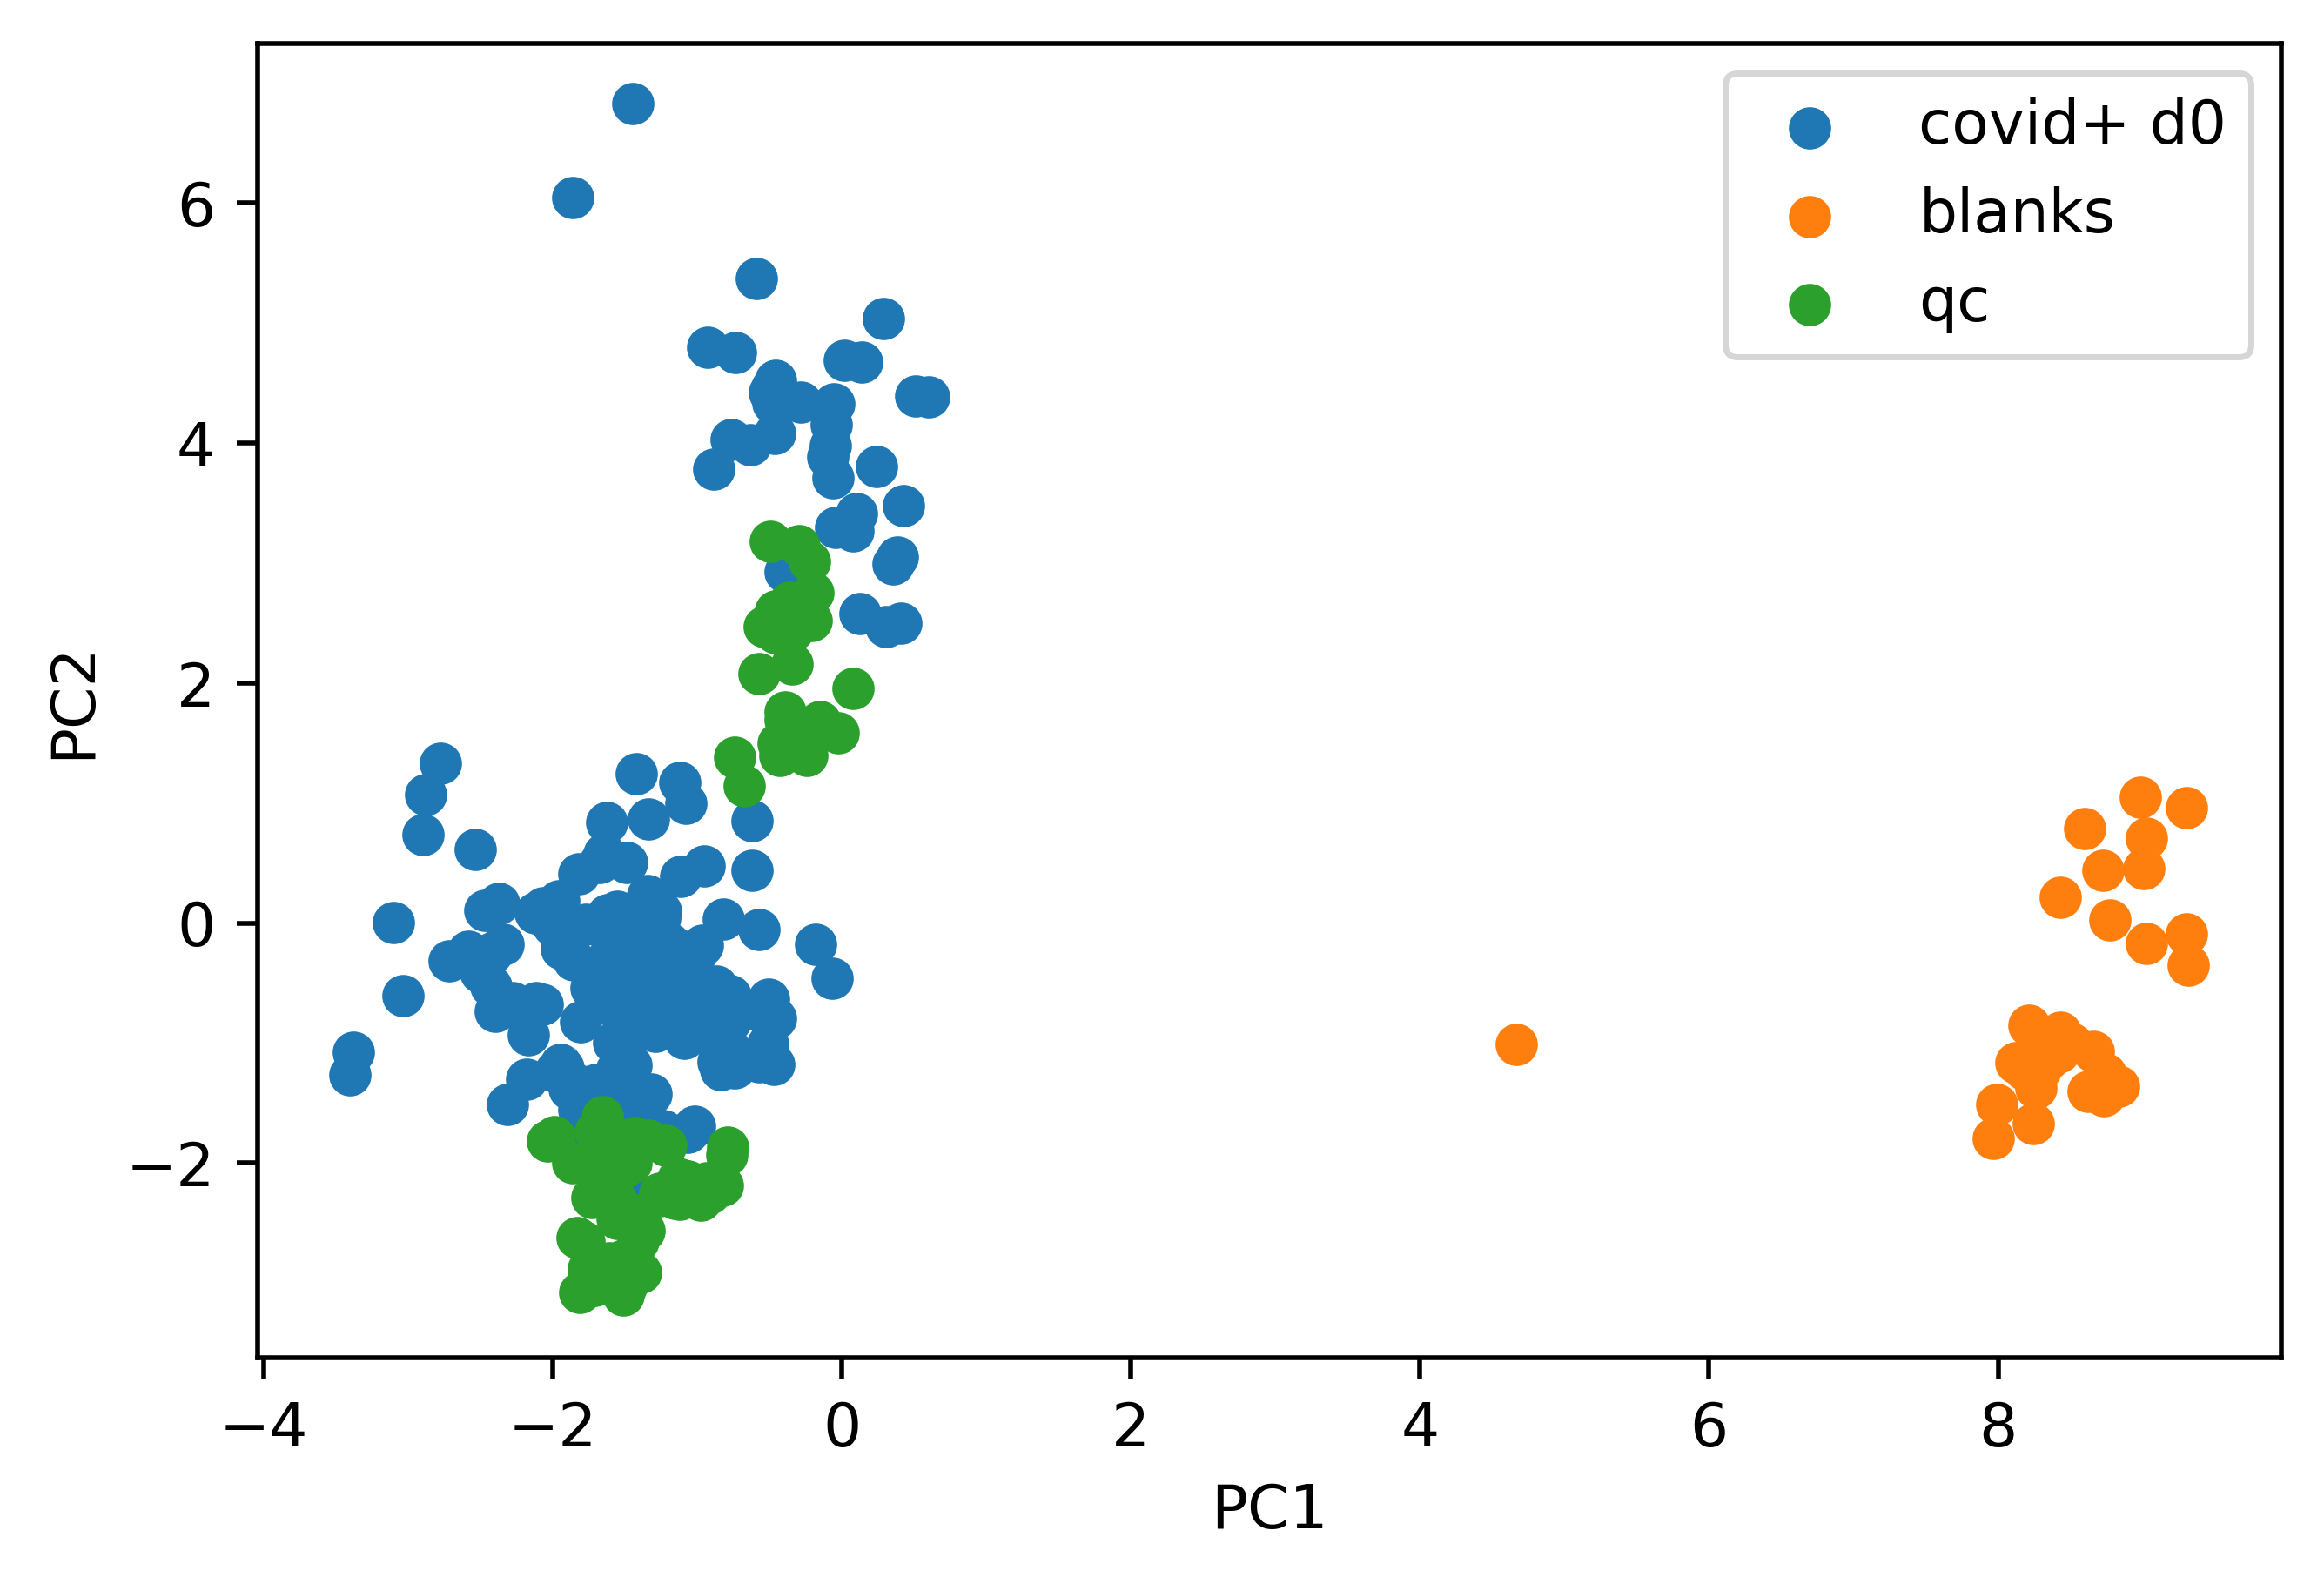

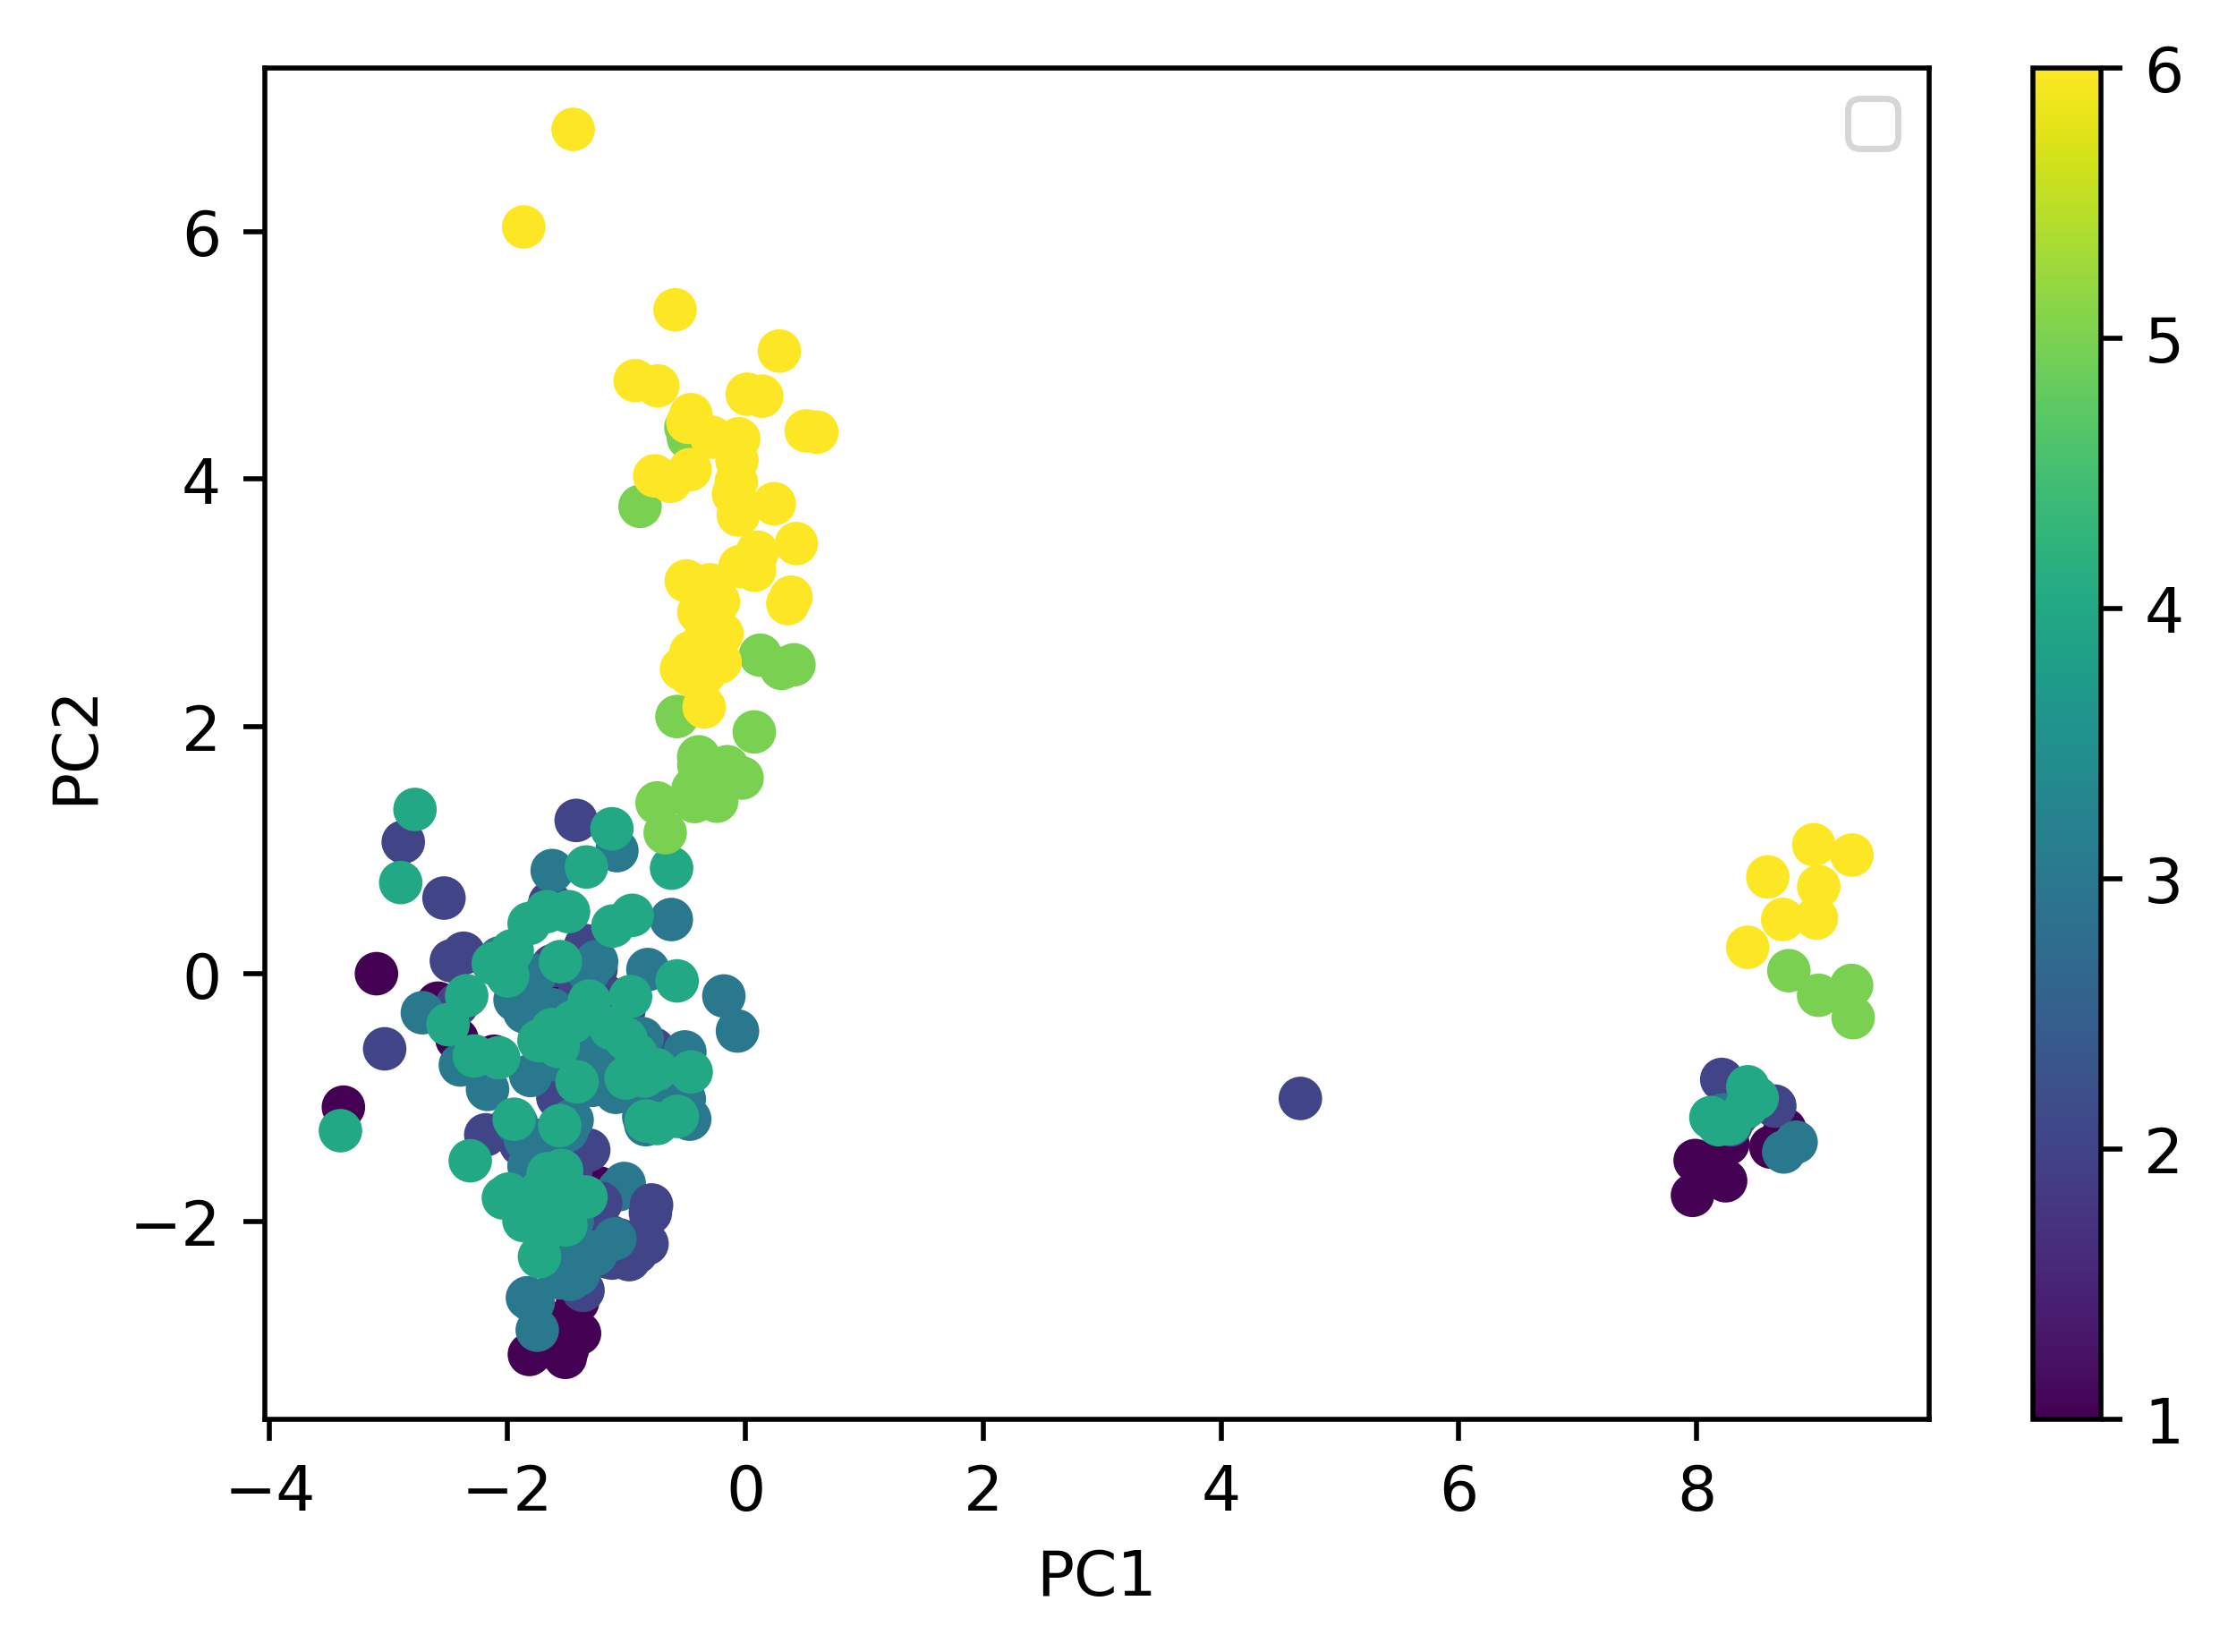

In [11]:
#now 75 percentile shift

d_whole_norm = []
for s in d_whole_imput:
    mi,ma = np.percentile(s,[25,75])
    d_whole_norm.append([(x-mi)/(ma-mi) for x in s])
    
d_whole_norm = np.array(d_whole_norm)

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#separate samples
samp_whole_int = d_whole_norm[:len(samp_int)]
qc_whole_int = d_whole_norm[len(samp_int)+len(blank_int):]

#compute variances
sample_variance = np.var(samp_whole_int,axis=0)
qc_variance = np.var(qc_whole_int,axis=0)

norm_var = np.linalg.norm(sample_variance)/np.linalg.norm(qc_variance)

print(norm_var)

print(np.mean(sample_variance),np.mean(qc_variance),np.mean(norm_var))

No handles with labels found to put in legend.


1.1811839673779612
0.001536541539168792 0.0005561984652582968 1.1811839673779612


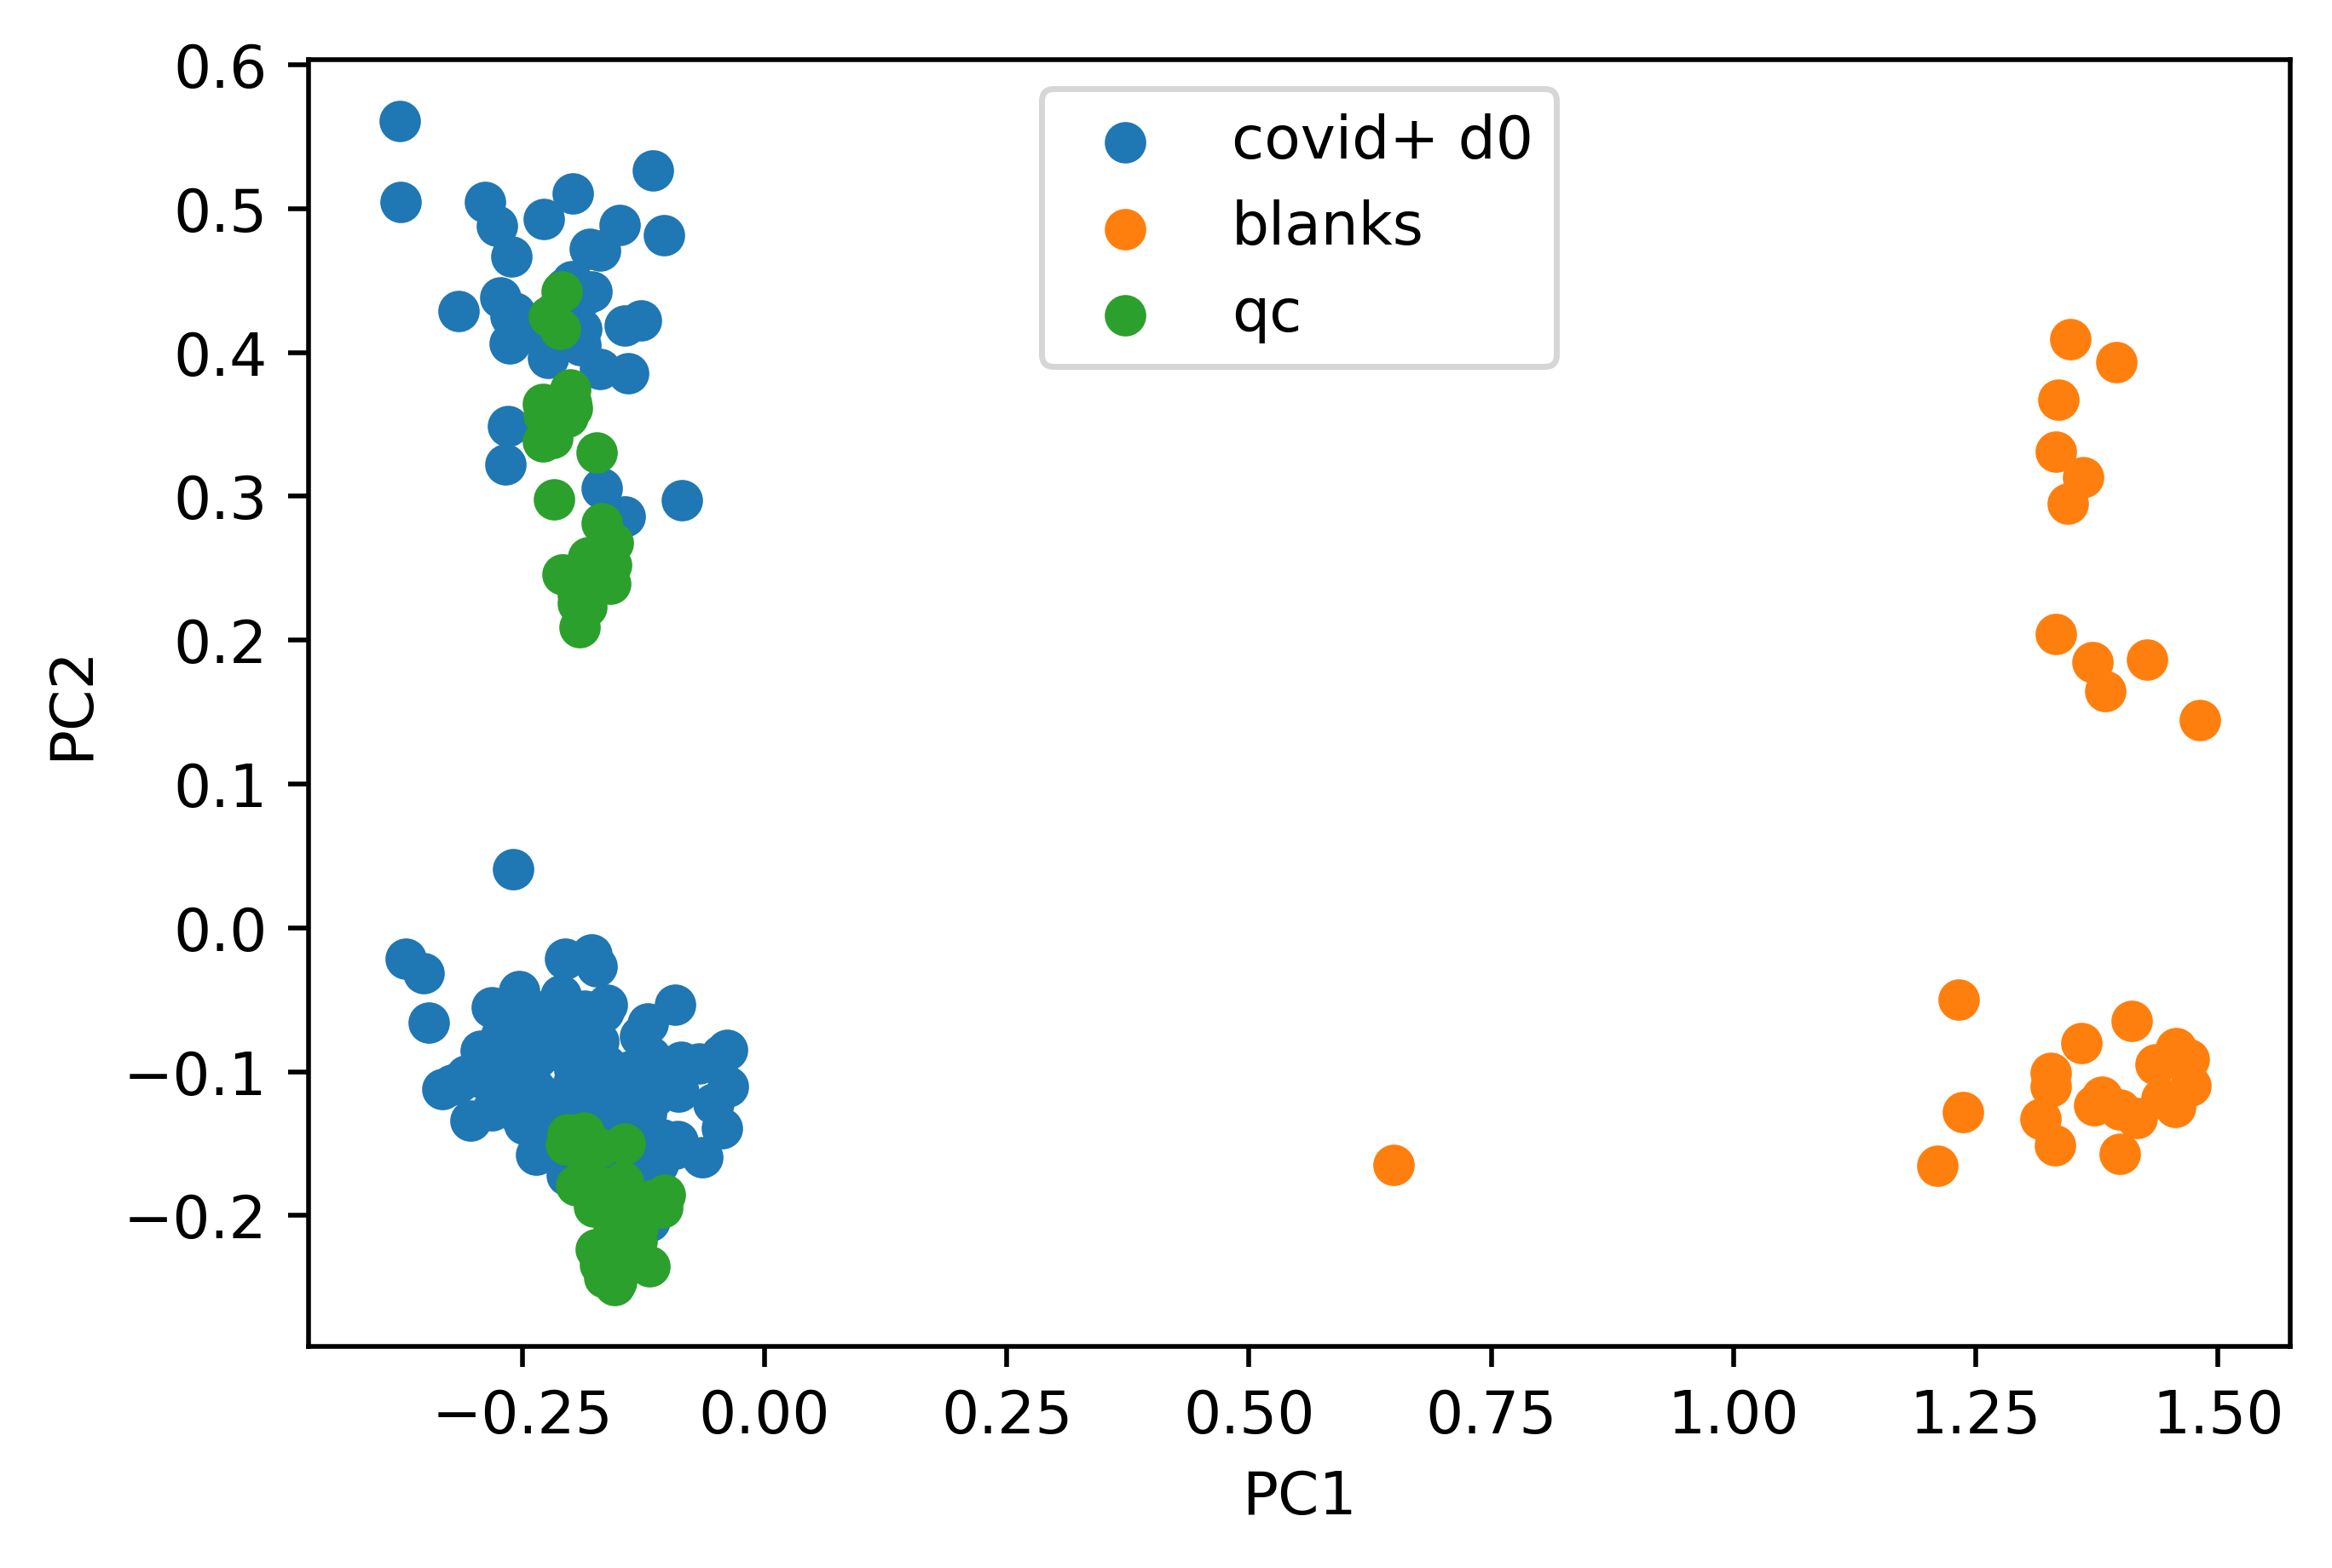

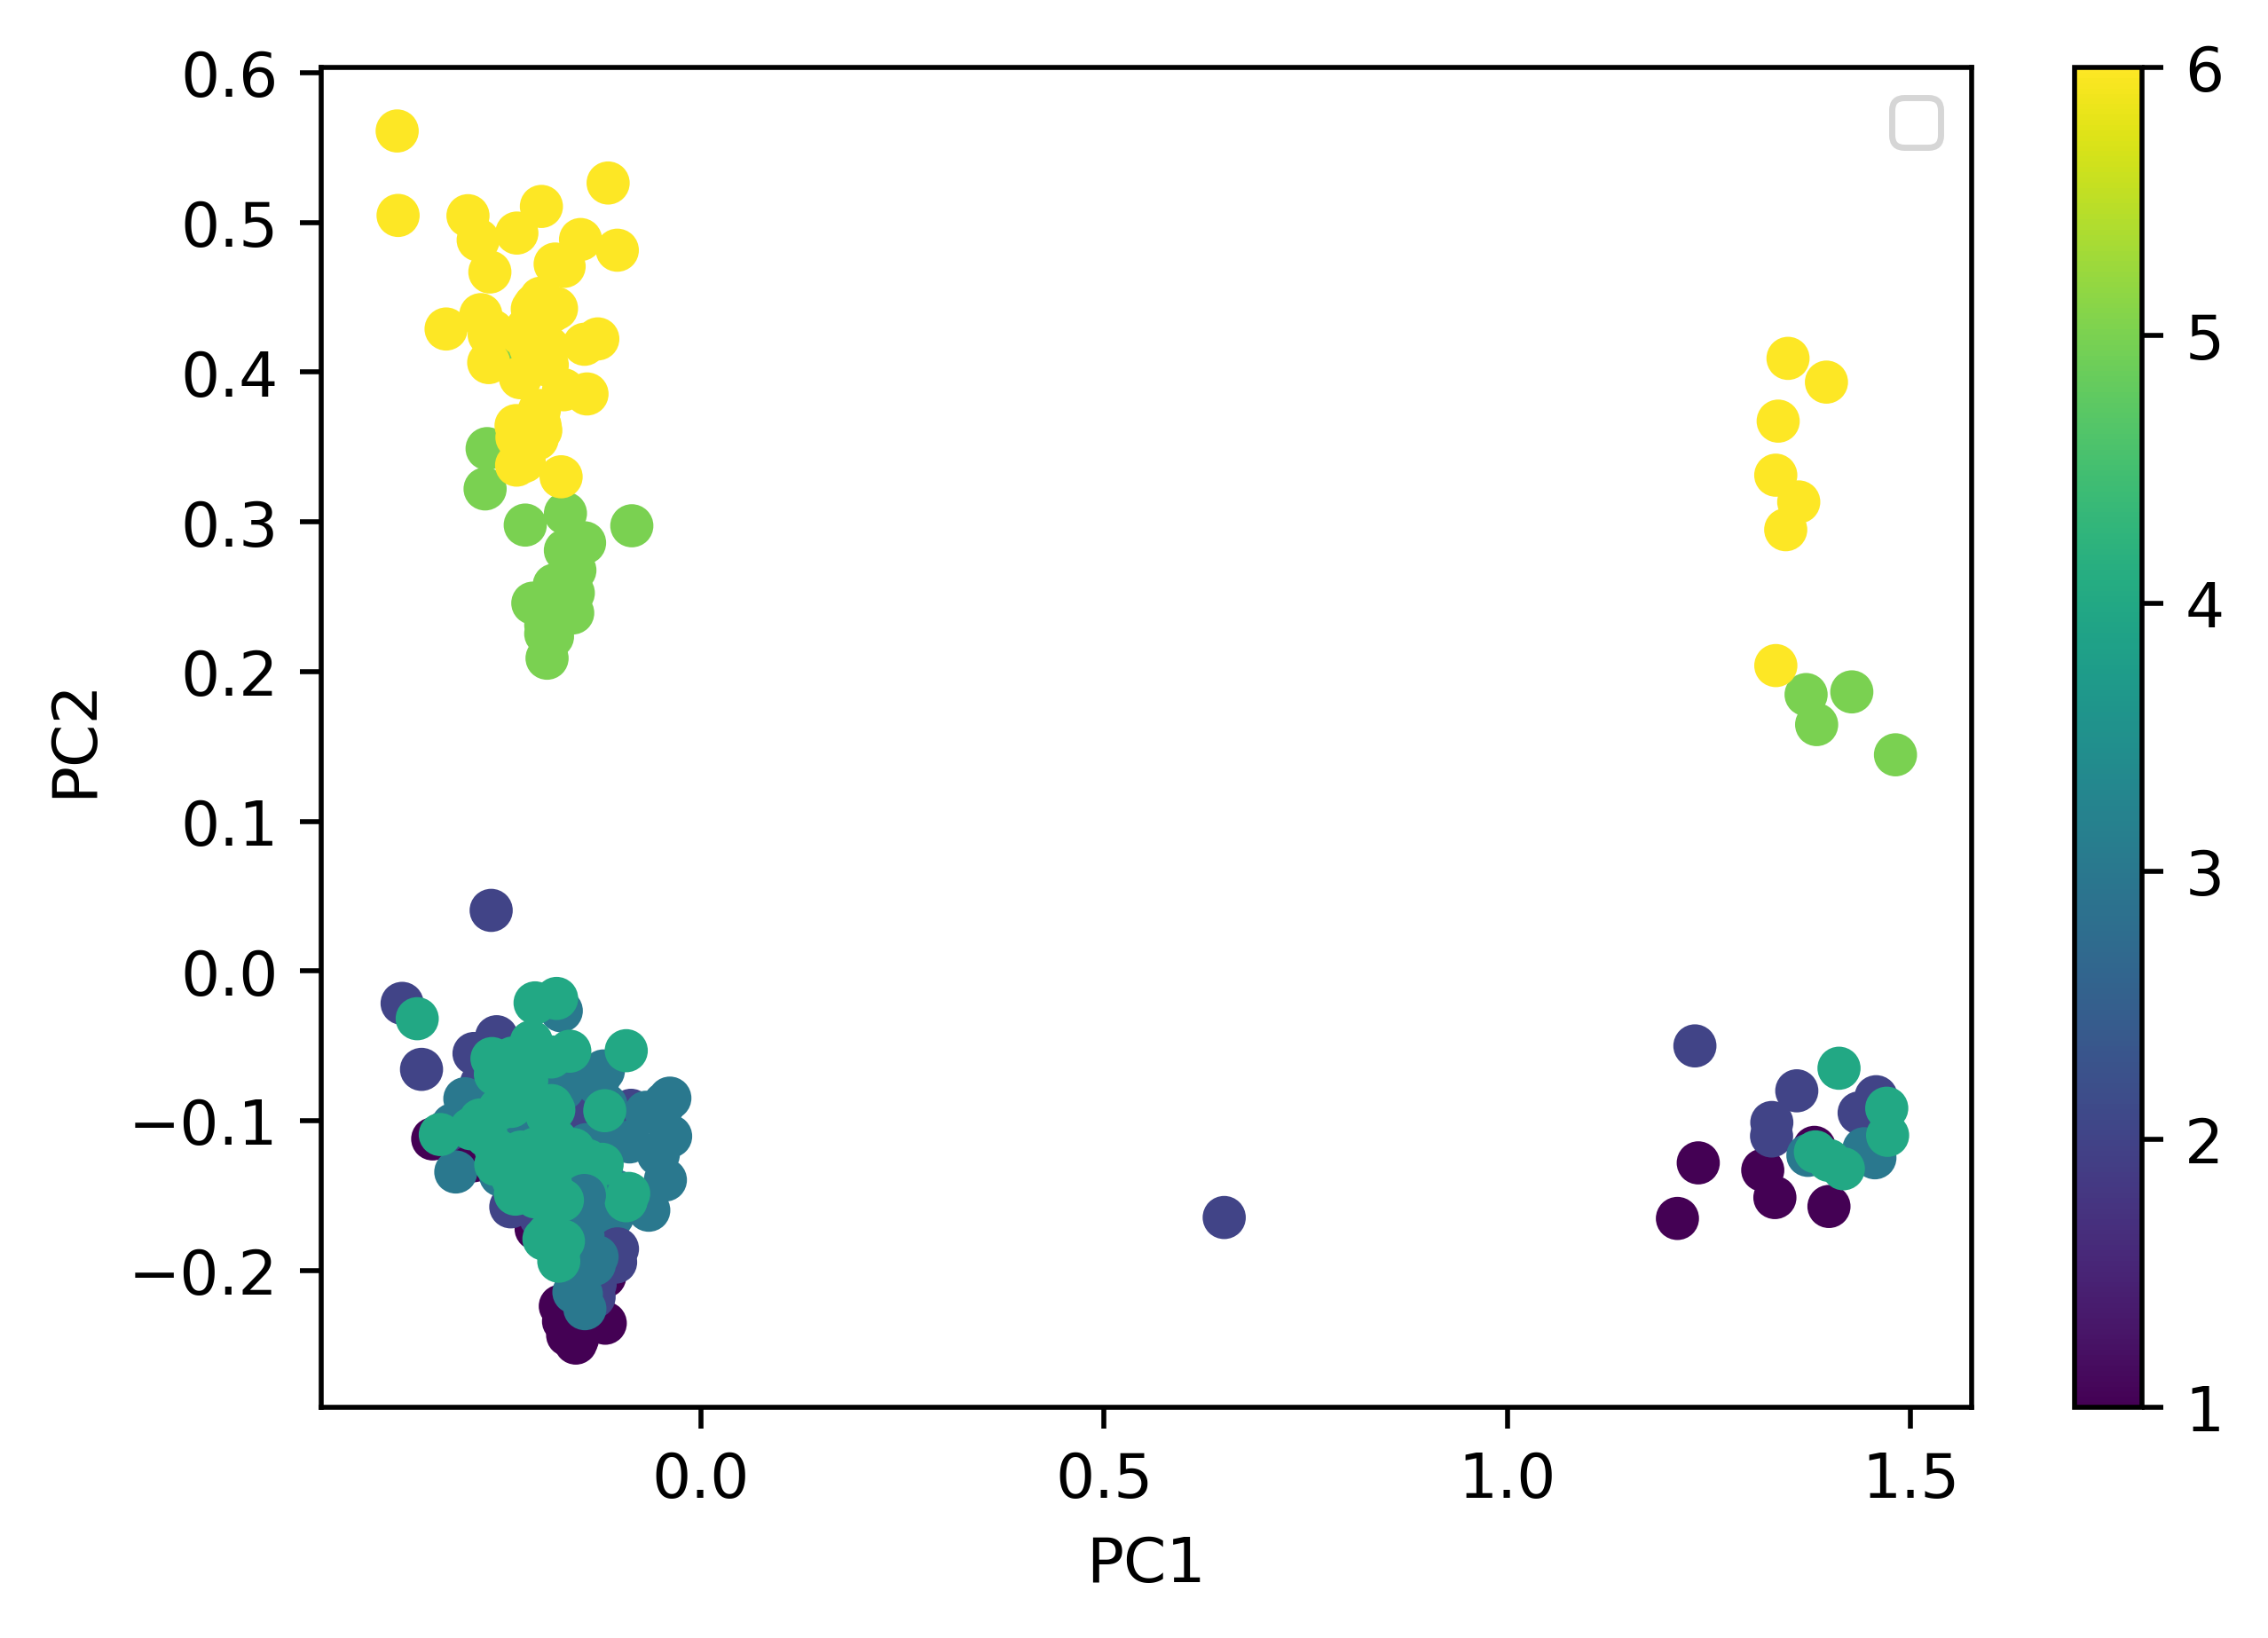

In [12]:
#now QCN scale

#sum normalize
d_whole_norm = 100*sklearn.preprocessing.normalize(d_whole_imput,norm="l1")

#get median qc sample
reference = np.array([np.median(c) for c in d_whole_norm[len(samp_int)+len(blank_int):].transpose()])

d_corr = []
for x in d_whole_norm:
    qs = []
    for f,r in zip(x,reference):
        qs.append(f/r)
    q = np.median(qs)
    d_corr.append([f/q for f in x])
    
d_whole_norm = np.array(d_corr)

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#separate samples
samp_whole_int = d_whole_norm[:len(samp_int)]
qc_whole_int = d_whole_norm[len(samp_int)+len(blank_int):]

#compute variances
sample_variance = np.var(samp_whole_int,axis=0)
qc_variance = np.var(qc_whole_int,axis=0)

norm_var = np.linalg.norm(sample_variance)/np.linalg.norm(qc_variance)

print(norm_var)

print(np.mean(sample_variance),np.mean(qc_variance),np.mean(norm_var))